## Cell 1: Import Libraries

In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

## Cell 2: Load and Inspect Data


In [126]:
try:
    # Load dataset
    df = pd.read_csv('trilobite.csv')
    
    # Dataset shape
    print("=== Dataset Shape ===")
    print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")
    
    # First 5 rows
    print("\n=== First 5 Rows ===")
    print(df.head())
    
except FileNotFoundError:
    print("‚ùå Error: 'trilobite.csv' not found. Please check file path.")
except Exception as e:
    print(f"‚ùå Unexpected error: {str(e)}")

=== Dataset Shape ===
Rows: 29039, Columns: 30

=== First 5 Rows ===
             scientific_name     order order_num           family family_num  \
0  Australosutura llanoensis  Proetida     21062  Brachymetopidae      56732   
1      Phillibole planucauda  Proetida     21062    Phillipsiidae      85866   
2       Thigriffides roundyi  Proetida     21062    Phillipsiidae      85866   
3   Pudoproetus chappelensis  Proetida     21062        Proetidae      56726   
4   Pudoproetus chappelensis  Proetida     21062        Proetidae      56726   

                     genus  genus_num       species early_interval  \
0           Australosutura      21084    llanoensis        Ivorian   
1  Archegonus (Phillibole)      21075    planucauda        Ivorian   
2             Thigriffides      21387       roundyi        Ivorian   
3              Pudoproetus     177081  chappelensis        Ivorian   
4              Pudoproetus     177081  chappelensis        Ivorian   

  late_interval  ...  litholo

## Cell 3: Dataset Information

In [131]:
print("=== Dataset Information ===")
print(df.info())

=== Dataset Information ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29039 entries, 0 to 29038
Data columns (total 30 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   scientific_name       29039 non-null  object 
 1   order                 29039 non-null  object 
 2   order_num             29039 non-null  object 
 3   family                29039 non-null  object 
 4   family_num            29039 non-null  object 
 5   genus                 29039 non-null  object 
 6   genus_num             29039 non-null  int64  
 7   species               29039 non-null  object 
 8   early_interval        29039 non-null  object 
 9   late_interval         2556 non-null   object 
 10  max_age_mya           29039 non-null  float64
 11  min_age_mya           29039 non-null  float64
 12  country               28997 non-null  object 
 13  state                 22914 non-null  object 
 14  longitude             29039 non-null  floa

## Cell 4: Missing Values Analysis


In [139]:
print("=== Missing Values Summary ===")
missing_summary = df.isnull().sum()
missing_pct = (missing_summary / len(df)) * 100

missing_df = pd.DataFrame({
    'Missing_Count': missing_summary,
    'Missing_Percentage': missing_pct
})

# Show only columns with missing values
missing_with_values = missing_df[missing_df['Missing_Count'] > 0]
if not missing_with_values.empty:
    print(missing_with_values.sort_values('Missing_Count', ascending=False))
else:
    print("‚úÖ No missing values found!")

=== Missing Values Summary ===
                      Missing_Count  Missing_Percentage
late_interval                 26483           91.198044
state                          6125           21.092324
stratigraphy_scale             5733           19.742415
latlng_basis                   3572           12.300699
assembly_composition           3176           10.937016
time_period                    2965           10.210407
preservation_mode              2486            8.560901
vision                         2227            7.668997
formation                      1912            6.584249
environment                     539            1.856125
lithology                       102            0.351252
country                          42            0.144633
collection_type                  32            0.110197


## Cell 5: Drop Irrelevant Columns

In [144]:
# Define columns to drop
columns_to_drop = ['latlng_basis', 'collection_name', 'collection_type']

# Check which columns exist and drop them
existing_cols_to_drop = [col for col in columns_to_drop if col in df.columns]
if existing_cols_to_drop:
    df = df.drop(columns=existing_cols_to_drop)
    print(f"‚úÖ Dropped columns: {existing_cols_to_drop}")
    print(f"New dataset shape: {df.shape}")
else:
    print("No specified columns found to drop")

‚úÖ Dropped columns: ['latlng_basis', 'collection_name', 'collection_type']
New dataset shape: (29039, 27)


## Cell 6: Handle Missing Numerical Values


In [147]:
# Get numerical columns
numerical_cols = df.select_dtypes(include=[np.number]).columns
print(f"Numerical columns: {list(numerical_cols)}")

# Fill missing values with median
for col in numerical_cols:
    missing_count = df[col].isnull().sum()
    if missing_count > 0:
        median_val = df[col].median()
        df[col] = df[col].fillna(median_val)
        print(f"‚úÖ Filled {missing_count} missing values in '{col}' with median: {median_val:.2f}")
    else:
        print(f"‚úÖ No missing values in '{col}'")

Numerical columns: ['genus_num', 'max_age_mya', 'min_age_mya', 'longitude', 'latitude']
‚úÖ No missing values in 'genus_num'
‚úÖ No missing values in 'max_age_mya'
‚úÖ No missing values in 'min_age_mya'
‚úÖ No missing values in 'longitude'
‚úÖ No missing values in 'latitude'


## Cell 7: Handle Missing Categorical Values

In [152]:
# Get categorical columns first
categorical_cols = df.select_dtypes(include=['object']).columns
print(f"Categorical columns: {list(categorical_cols)}")

# Fill missing values with mode
for col in categorical_cols:
    missing_count = df[col].isnull().sum()
    if missing_count > 0:
        if not df[col].dropna().empty:
            mode_val = df[col].mode()[0]
            df[col] = df[col].fillna(mode_val)
            print(f"‚úÖ Filled {missing_count} missing values in '{col}' with mode: '{mode_val}'")
        else:
            # If column is completely empty, fill with 'Unknown'
            df[col] = df[col].fillna('Unknown')
            print(f"‚úÖ Filled {missing_count} missing values in '{col}' with 'Unknown'")
    else:
        print(f"‚úÖ No missing values in '{col}'")

Categorical columns: ['scientific_name', 'order', 'order_num', 'family', 'family_num', 'genus', 'species', 'early_interval', 'late_interval', 'country', 'state', 'latlng_precision', 'formation', 'stratigraphy_scale', 'lithology', 'environment', 'assembly_composition', 'preservation_mode', 'life_habit', 'vision', 'diet', 'time_period']
‚úÖ No missing values in 'scientific_name'
‚úÖ No missing values in 'order'
‚úÖ No missing values in 'order_num'
‚úÖ No missing values in 'family'
‚úÖ No missing values in 'family_num'
‚úÖ No missing values in 'genus'
‚úÖ No missing values in 'species'
‚úÖ No missing values in 'early_interval'
‚úÖ Filled 26483 missing values in 'late_interval' with mode: 'Hirnantian'
‚úÖ Filled 42 missing values in 'country' with mode: 'US'
‚úÖ Filled 6125 missing values in 'state' with mode: 'Nevada'
‚úÖ No missing values in 'latlng_precision'
‚úÖ Filled 1912 missing values in 'formation' with mode: 'Huaqiao'
‚úÖ Filled 5733 missing values in 'stratigraphy_scale' with mo

## Cell 8: Verify Data Cleaning


In [159]:
print("=== Post-Cleaning Verification ===")
remaining_missing = df.isnull().sum().sum()

if remaining_missing == 0:
    print("‚úÖ All missing values handled successfully!")
    print(f"Final dataset shape: {df.shape}")
else:
    print(f"‚ö†Ô∏è {remaining_missing} missing values still remain:")
    print(df.isnull().sum()[df.isnull().sum() > 0])

=== Post-Cleaning Verification ===
‚úÖ All missing values handled successfully!
Final dataset shape: (29039, 27)


## Cell 9: Data Summary After Cleaning

In [162]:
print("=== Cleaned Dataset Summary ===")
print(df.describe(include='all'))

=== Cleaned Dataset Summary ===
         scientific_name     order order_num     family family_num     genus  \
count              29039     29039     29039      29039      29039     29039   
unique              6742        12        12        167        168      2221   
top     Eldredgeops rana  Proetida     21062  Asaphidae      82596  Isotelus   
freq                 236      5586      5586       2157       2157       307   
mean                 NaN       NaN       NaN        NaN        NaN       NaN   
std                  NaN       NaN       NaN        NaN        NaN       NaN   
min                  NaN       NaN       NaN        NaN        NaN       NaN   
25%                  NaN       NaN       NaN        NaN        NaN       NaN   
50%                  NaN       NaN       NaN        NaN        NaN       NaN   
75%                  NaN       NaN       NaN        NaN        NaN       NaN   
max                  NaN       NaN       NaN        NaN        NaN       NaN   

       

In [114]:
# 1. Remove any age-related features that could cause leakage
print("=== Cleaning Features ===")
age_related_features = [col for col in X_test.columns 
                       if any(word in col.lower() 
                             for word in ['age', 'mya', 'max_age', 'min_age'])]
print(f"Age-related features found: {age_related_features}")

# Create clean feature set
X_train_clean = X_train.drop(columns=age_related_features, errors='ignore')
X_test_clean = X_test.drop(columns=age_related_features, errors='ignore')

print(f"Original features: {X_train.shape[1]}")
print(f"Clean features: {X_train_clean.shape[1]}")

# 2. Retrain model with clean features
from sklearn.ensemble import RandomForestRegressor

rf_clean = RandomForestRegressor(n_estimators=100, random_state=42)
rf_clean.fit(X_train_clean, y_train)

# 3. Test clean model
y_ml_clean = rf_clean.predict(X_test_clean)

# 4. Recalculate metrics
manual_mae = mean_absolute_error(y_test, y_manual)
ml_mae_clean = mean_absolute_error(y_test, y_ml_clean)

print("\n=== CORRECTED Results ===")
print(f"Manual Method MAE: {manual_mae:.1f} Mya")
print(f"ML Method MAE (Clean): {ml_mae_clean:.1f} Mya")
if ml_mae_clean < manual_mae:
    print(f"Improvement: {((manual_mae - ml_mae_clean)/manual_mae)*100:.1f}%")
else:
    print(f"Manual method is better by: {((ml_mae_clean - manual_mae)/manual_mae)*100:.1f}%")

print(f"R¬≤ Score (Clean): {r2_score(y_test, y_ml_clean):.4f}")

=== Cleaning Features ===
Age-related features found: ['max_age_mya', 'min_age_mya']
Original features: 10
Clean features: 8

=== CORRECTED Results ===
Manual Method MAE: 66.5 Mya
ML Method MAE (Clean): 0.7 Mya
Improvement: 98.9%
R¬≤ Score (Clean): 0.9959


## Data Preprocessing

This step handles:
1. **Column Removal**: Dropping irrelevant columns
2. **Missing Values**:
   - Numerical: Fill with median
   - Categorical: Fill with mode
3. **Data Cleaning**: Fixing typos and syntax errors

In [21]:
# 1. Drop irrelevant columns (corrected column names)
columns_to_drop = ['latlng_basis', 'collection_name', 'collection_type']  # Fixed 'lating_basis' typo
df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])

# 2. Handle missing numerical values (safe median calculation)
if 'max_age_mya' in df.columns:
    median_age = df['max_age_mya'].median()
    df['max_age_mya'] = df['max_age_mya'].fillna(median_age)
    print(f"Filled {df['max_age_mya'].isnull().sum()} missing age values with median: {median_age:.1f} Mya")

# 3. Handle missing categorical values (safe mode calculation)
if 'environment' in df.columns:
    if not df['environment'].empty:
        mode_env = df['environment'].mode()[0]  # Fixed [@] syntax error
        df['environment'] = df['environment'].fillna(mode_env)
        print(f"Filled {df['environment'].isnull().sum()} missing environment values with mode: '{mode_env}'")
    else:
        print("Warning: 'environment' column is empty")

# Verification
print("\n=== Post-Cleaning Missing Values ===")
print(df.isnull().sum())

Filled 0 missing age values with median: 477.1 Mya
Filled 0 missing environment values with mode: 'marine indet.'

=== Post-Cleaning Missing Values ===
scientific_name             0
order                       0
order_num                   0
family                      0
family_num                  0
genus                       0
genus_num                   0
species                     0
early_interval              0
late_interval           26483
max_age_mya                 0
min_age_mya                 0
country                    42
state                    6125
longitude                   0
latitude                    0
latlng_precision            0
formation                1912
stratigraphy_scale       5733
lithology                 102
environment                 0
assembly_composition     3176
preservation_mode        2486
life_habit                  0
vision                   2227
diet                        0
time_period              2965
dtype: int64


## 2.2 Feature Engineering

Key transformations:
1. **Average Age Calculation**: Midpoint between `max_age_mya` and `min_age_mya`
2. **Time Period Binning**: Categorize ages into geological periods
3. **Taxonomic Encoding**: Convert categorical features to numerical
4. **Novel Features**: Geological duration span

In [164]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

print("=== Starting Feature Engineering ===")

# 1. Calculate average age (with NaN protection)
print("Creating average age feature...")
df['avg_age_mya'] = np.where(
    df[['max_age_mya', 'min_age_mya']].isnull().any(axis=1),
    np.nan,
    (df['max_age_mya'] + df['min_age_mya']) / 2
)
print(f"‚úÖ Created avg_age_mya feature. Non-null values: {df['avg_age_mya'].notna().sum()}")

# 2. Geological duration feature
print("Creating geological duration feature...")
df['geol_duration_mya'] = df['max_age_mya'] - df['min_age_mya']
print(f"‚úÖ Created geol_duration_mya feature. Non-null values: {df['geol_duration_mya'].notna().sum()}")

# 3. Bin ages into geological periods (corrected for trilobite era)
print("Creating time period bins...")
# Trilobites lived primarily in Paleozoic Era (252-541 MYA)
bins = [0, 252, 299, 359, 419, 444, 485, 541, np.inf]
labels = ['Post-Paleozoic', 'Permian', 'Carboniferous', 'Devonian', 'Silurian', 'Ordovician', 'Cambrian', 'Precambrian']

# Only create bins if we have age data
if df['avg_age_mya'].notna().sum() > 0:
    df['time_period_bin'] = pd.cut(df['avg_age_mya'], bins=bins, labels=labels, right=False)
    print(f"‚úÖ Created time_period_bin feature")
    print("Time period distribution:")
    print(df['time_period_bin'].value_counts().head())
else:
    print("‚ö†Ô∏è No valid age data for time period binning")

# 4. Taxonomic feature encoding
print("Encoding taxonomic features...")
taxonomic_cols = ['order', 'family', 'genus']
encoded_cols = []

for col in taxonomic_cols:
    if col in df.columns:
        try:
            le = LabelEncoder()
            # Convert to string and handle any remaining NaN values
            df[f'{col}_encoded'] = le.fit_transform(df[col].astype(str).fillna('Unknown'))
            encoded_cols.append(f'{col}_encoded')
            print(f"‚úÖ Encoded {col} -> {col}_encoded ({len(le.classes_)} unique values)")
        except Exception as e:
            print(f"‚ùå Error encoding {col}: {str(e)}")
    else:
        print(f"‚ö†Ô∏è Column '{col}' not found in dataset")

# 5. Geographic features (if coordinates exist)
if 'longitude' in df.columns and 'latitude' in df.columns:
    print("Creating geographic features...")
    
    # Create hemisphere features
    df['hemisphere_NS'] = np.where(df['latitude'] >= 0, 'Northern', 'Southern')
    df['hemisphere_EW'] = np.where(df['longitude'] >= 0, 'Eastern', 'Western')
    
    # Create coordinate bins for regional analysis
    df['lat_bin'] = pd.cut(df['latitude'], bins=5, labels=['Very_South', 'South', 'Equatorial', 'North', 'Very_North'])
    df['lon_bin'] = pd.cut(df['longitude'], bins=5, labels=['Far_West', 'West', 'Central', 'East', 'Far_East'])
    
    print("‚úÖ Created geographic features")
else:
    print("‚ö†Ô∏è Geographic coordinates not available")

# 6. Feature summary
print("\n=== Feature Engineering Summary ===")
new_features = ['avg_age_mya', 'geol_duration_mya', 'time_period_bin'] + encoded_cols

# Add geographic features if they were created
if 'hemisphere_NS' in df.columns:
    new_features.extend(['hemisphere_NS', 'hemisphere_EW', 'lat_bin', 'lon_bin'])

print(f"Created {len(new_features)} new features:")
for feature in new_features:
    if feature in df.columns:
        print(f"  - {feature}")

# Display sample of new features
print("\n=== Sample of Engineered Features ===")
sample_features = [col for col in new_features if col in df.columns][:8]  # Show max 8 features
if sample_features:
    print(df[sample_features].head(3))
else:
    print("No new features to display")

print(f"\nFinal dataset shape: {df.shape}")

=== Starting Feature Engineering ===
Creating average age feature...
‚úÖ Created avg_age_mya feature. Non-null values: 29039
Creating geological duration feature...
‚úÖ Created geol_duration_mya feature. Non-null values: 29039
Creating time period bins...
‚úÖ Created time_period_bin feature
Time period distribution:
time_period_bin
Cambrian         11340
Ordovician       11169
Devonian          3661
Silurian          1597
Carboniferous      865
Name: count, dtype: int64
Encoding taxonomic features...
‚úÖ Encoded order -> order_encoded (12 unique values)
‚úÖ Encoded family -> family_encoded (167 unique values)
‚úÖ Encoded genus -> genus_encoded (2221 unique values)
Creating geographic features...
‚úÖ Created geographic features

=== Feature Engineering Summary ===
Created 10 new features:
  - avg_age_mya
  - geol_duration_mya
  - time_period_bin
  - order_encoded
  - family_encoded
  - genus_encoded
  - hemisphere_NS
  - hemisphere_EW
  - lat_bin
  - lon_bin

=== Sample of Engineered Fe

## 2.3 Categorical Feature Encoding

### Purpose:
Convert text-based categorical features into numerical representations for machine learning.

### Methods:
1. **Label Encoding**: For ordinal categories (e.g., `life_habit`)
2. **One-Hot Encoding**: For nominal categories with <10 unique values (e.g., `diet`)
3. **Frequency Encoding**: For high-cardinality features (e.g., `genus`)

### Features to Encode:
- `environment`, `life_habit`, `diet`, `preservation_mode`

In [166]:
# Categorical Feature Encoding
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np

print("=== Starting Categorical Feature Encoding ===")

# Define feature groups
ordinal_cols = ['life_habit', 'vision']
onehot_features = ['diet', 'preservation_mode']
freq_features = ['genus', 'family']

# Track successfully encoded features
encoded_summary = {
    'label_encoded': [],
    'onehot_encoded': [],
    'frequency_encoded': []
}

# 1. Label Encoding (for ordinal features)
print("1. Label Encoding ordinal features...")
for col in ordinal_cols:
    if col in df.columns:
        try:
            # Create a new encoder for each column
            le = LabelEncoder()
            # Handle NaN values by converting to string and filling
            df[f'{col}_encoded'] = le.fit_transform(df[col].astype(str).fillna('Unknown'))
            encoded_summary['label_encoded'].append(col)
            
            # Show unique values
            unique_count = len(le.classes_)
            print(f"  ‚úÖ {col} -> {col}_encoded ({unique_count} unique values)")
            
        except Exception as e:
            print(f"  ‚ùå Error encoding {col}: {str(e)}")
    else:
        print(f"  ‚ö†Ô∏è Column '{col}' not found in dataset")

# 2. One-Hot Encoding (for nominal features with low cardinality)
print("\n2. One-Hot Encoding nominal features...")
for col in onehot_features:
    if col in df.columns:
        try:
            # Check cardinality first
            unique_count = df[col].nunique()
            print(f"  {col}: {unique_count} unique values")
            
            if unique_count > 10:
                print(f"  ‚ö†Ô∏è {col} has {unique_count} unique values (>10). Consider frequency encoding instead.")
            
            # Create dummy variables
            dummies = pd.get_dummies(df[col], prefix=col, drop_first=True, dummy_na=True)
            df = pd.concat([df, dummies], axis=1)
            encoded_summary['onehot_encoded'].append(col)
            
            print(f"  ‚úÖ {col} -> {dummies.shape[1]} dummy variables created")
            
        except Exception as e:
            print(f"  ‚ùå Error one-hot encoding {col}: {str(e)}")
    else:
        print(f"  ‚ö†Ô∏è Column '{col}' not found in dataset")

# 3. Frequency Encoding (for high-cardinality features)
print("\n3. Frequency Encoding high-cardinality features...")
for col in freq_features:
    if col in df.columns:
        try:
            # Calculate frequency mapping
            freq_map = df[col].value_counts(normalize=True, dropna=False).to_dict()
            df[f'{col}_freq'] = df[col].map(freq_map)
            
            # Handle any unmapped values (shouldn't happen, but safety check)
            if df[f'{col}_freq'].isnull().any():
                df[f'{col}_freq'] = df[f'{col}_freq'].fillna(0)
            
            encoded_summary['frequency_encoded'].append(col)
            unique_count = df[col].nunique()
            print(f"  ‚úÖ {col} -> {col}_freq ({unique_count} unique values mapped to frequencies)")
            
        except Exception as e:
            print(f"  ‚ùå Error frequency encoding {col}: {str(e)}")
    else:
        print(f"  ‚ö†Ô∏è Column '{col}' not found in dataset")

# 4. Verification and Summary
print("\n=== Encoding Summary ===")
print(f"Label Encoded: {encoded_summary['label_encoded']}")
print(f"One-Hot Encoded: {encoded_summary['onehot_encoded']}")
print(f"Frequency Encoded: {encoded_summary['frequency_encoded']}")

# Find all new encoded columns
new_encoded_cols = []
for col in ordinal_cols:
    if f'{col}_encoded' in df.columns:
        new_encoded_cols.append(f'{col}_encoded')

for col in freq_features:
    if f'{col}_freq' in df.columns:
        new_encoded_cols.append(f'{col}_freq')

# Find one-hot encoded columns
onehot_cols = []
for col in onehot_features:
    if col in df.columns:
        onehot_cols.extend([c for c in df.columns if c.startswith(f'{col}_')])

print(f"\nNew encoded features created: {len(new_encoded_cols + onehot_cols)}")

# Display sample of new features (limit to prevent overflow)
print("\n=== Sample of New Encoded Features ===")
sample_cols = (new_encoded_cols + onehot_cols)[:8]  # Show max 8 columns
if sample_cols:
    print("Columns:", sample_cols)
    print(df[sample_cols].head(3))
else:
    print("No new encoded features to display")

# Show data types of encoded features
print("\n=== Data Types of Encoded Features ===")
if sample_cols:
    print(df[sample_cols].dtypes)

print(f"\nFinal dataset shape: {df.shape}")

=== Starting Categorical Feature Encoding ===
1. Label Encoding ordinal features...
  ‚úÖ life_habit -> life_habit_encoded (5 unique values)
  ‚úÖ vision -> vision_encoded (3 unique values)

2. One-Hot Encoding nominal features...
  diet: 5 unique values
  ‚úÖ diet -> 5 dummy variables created
  preservation_mode: 105 unique values
  ‚ö†Ô∏è preservation_mode has 105 unique values (>10). Consider frequency encoding instead.
  ‚úÖ preservation_mode -> 105 dummy variables created

3. Frequency Encoding high-cardinality features...
  ‚úÖ genus -> genus_freq (2221 unique values mapped to frequencies)
  ‚úÖ family -> family_freq (167 unique values mapped to frequencies)

=== Encoding Summary ===
Label Encoded: ['life_habit', 'vision']
One-Hot Encoded: ['diet', 'preservation_mode']
Frequency Encoded: ['genus', 'family']

New encoded features created: 114

=== Sample of New Encoded Features ===
Columns: ['life_habit_encoded', 'vision_encoded', 'genus_freq', 'family_freq', 'diet_deposit feeder'

## 3.1 Age Distribution Visualization

### Analysis Goals:
1. **Distribution Shape**: Identify normality/skewness of trilobite ages
2. **Geological Patterns**: Spot clusters in specific time periods
3. **Data Quality**: Check for implausible age values

### Visualizations:
- Histogram with KDE (Kernel Density Estimate)
- Box plot for outlier detection
- Cumulative distribution plot

In [171]:
# Age Distribution Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib.ticker import FuncFormatter

print("=== Creating Age Distribution Visualizations ===")

# Set style
sns.set_theme(style='whitegrid', font_scale=1.1)
plt.rcParams['figure.facecolor'] = 'white'

# Check if we have age data
age_col = 'avg_age_mya' if 'avg_age_mya' in df.columns else 'max_age_mya'
if age_col not in df.columns:
    print("‚ùå No age data available for visualization")
else:
    # Filter out invalid age data
    valid_ages = df[age_col].dropna()
    valid_ages = valid_ages[(valid_ages > 0) & (valid_ages < 4000)]  # Reasonable geological range
    
    if len(valid_ages) == 0:
        print("‚ùå No valid age data found")
    else:
        print(f"‚úÖ Found {len(valid_ages)} valid age records")
        print(f"Age range: {valid_ages.min():.1f} - {valid_ages.max():.1f} Mya")
        
        # Create figure with subplots
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle('Trilobite Age Distribution Analysis', fontsize=16, fontweight='bold')
        
        # Plot 1: Histogram with KDE
        sns.histplot(data=valid_ages, bins=50, kde=True, ax=ax1, 
                    color='steelblue', alpha=0.7, stat='density')
        ax1.axvline(valid_ages.mean(), color='red', linestyle='--', 
                   label=f'Mean: {valid_ages.mean():.1f} Mya')
        ax1.axvline(valid_ages.median(), color='orange', linestyle='--', 
                   label=f'Median: {valid_ages.median():.1f} Mya')
        ax1.set_title('Age Distribution with KDE')
        ax1.set_xlabel('Age (Million Years Ago)')
        ax1.set_ylabel('Density')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Plot 2: Box plot for outlier detection
        sns.boxplot(y=valid_ages, ax=ax2, color='lightblue')
        ax2.set_title('Age Distribution - Outlier Detection')
        ax2.set_ylabel('Age (Million Years Ago)')
        
        # Add summary statistics
        q1, q3 = valid_ages.quantile([0.25, 0.75])
        iqr = q3 - q1
        outliers = valid_ages[(valid_ages < q1 - 1.5*iqr) | (valid_ages > q3 + 1.5*iqr)]
        ax2.text(0.02, 0.98, f'Outliers: {len(outliers)} ({len(outliers)/len(valid_ages)*100:.1f}%)', 
                transform=ax2.transAxes, verticalalignment='top', 
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
        
        # Plot 3: Cumulative distribution
        sorted_ages = np.sort(valid_ages)
        cumulative = np.arange(1, len(sorted_ages) + 1) / len(sorted_ages)
        ax3.plot(sorted_ages, cumulative, color='green', linewidth=2)
        ax3.set_title('Cumulative Age Distribution')
        ax3.set_xlabel('Age (Million Years Ago)')
        ax3.set_ylabel('Cumulative Probability')
        ax3.grid(True, alpha=0.3)
        
        # Add percentile lines
        for percentile in [25, 50, 75]:
            age_val = valid_ages.quantile(percentile/100)
            ax3.axvline(age_val, color='red', alpha=0.5, linestyle=':')
            ax3.text(age_val, percentile/100, f'P{percentile}', rotation=90, 
                    verticalalignment='bottom')
        
        # Plot 4: Time period distribution (if available)
        if 'time_period_bin' in df.columns:
            period_counts = df['time_period_bin'].value_counts()
            if not period_counts.empty:
                # Fix deprecation warning by creating a DataFrame
                plot_data = pd.DataFrame({
                    'period': period_counts.index,
                    'count': period_counts.values
                })
                sns.barplot(data=plot_data, x='count', y='period', ax=ax4, color='steelblue')
                ax4.set_title('Fossil Records by Geological Period')
                ax4.set_xlabel('Number of Specimens')
                ax4.set_ylabel('Geological Period')
                
                # Add count labels
                for i, v in enumerate(period_counts.values):
                    ax4.text(v + max(period_counts.values)*0.01, i, str(v), 
                            verticalalignment='center')
            else:
                ax4.text(0.5, 0.5, 'No time period data available', 
                        ha='center', va='center', transform=ax4.transAxes)
                ax4.set_title('Time Period Distribution - No Data')
        else:
            # Alternative: Show age ranges
            age_ranges = pd.cut(valid_ages, bins=8)
            range_counts = age_ranges.value_counts().sort_index()
            
            # Create labels for age ranges
            labels = [f'{int(interval.left)}-{int(interval.right)}' for interval in range_counts.index]
            
            # Fix deprecation warning here too
            range_data = pd.DataFrame({
                'age_range': labels,
                'count': range_counts.values
            })
            sns.barplot(data=range_data, x='count', y='age_range', ax=ax4, color='coral')
            ax4.set_title('Fossil Records by Age Range')
            ax4.set_xlabel('Number of Specimens')
            ax4.set_ylabel('Age Range (Mya)')
        
        plt.tight_layout()
        plt.show()
        
        # Print summary statistics
        print("\n=== Age Distribution Summary ===")
        print(f"Count: {len(valid_ages):,}")
        print(f"Mean: {valid_ages.mean():.2f} Mya")
        print(f"Median: {valid_ages.median():.2f} Mya")
        print(f"Std Dev: {valid_ages.std():.2f} Mya")
        print(f"Min: {valid_ages.min():.2f} Mya")
        print(f"Max: {valid_ages.max():.2f} Mya")
        print(f"Skewness: {valid_ages.skew():.3f}")
        print(f"Kurtosis: {valid_ages.kurtosis():.3f}")
        
        # Geological context
        print("\n=== Geological Context ===")
        if valid_ages.min() > 252:
            print("‚úÖ All specimens from Paleozoic Era (as expected for trilobites)")
        else:
            print("‚ö†Ô∏è Some specimens appear to be from post-Paleozoic periods")
            
        if valid_ages.max() < 541:
            print("‚úÖ All specimens within reasonable trilobite timeframe")
        else:
            print("‚ö†Ô∏è Some specimens older than typical trilobite range")

=== Creating Age Distribution Visualizations ===
‚úÖ Found 29039 valid age records
Age range: 253.0 - 529.4 Mya



=== Age Distribution Summary ===
Count: 29,039
Mean: 461.10 Mya
Median: 473.30 Mya
Std Dev: 47.58 Mya
Min: 253.02 Mya
Max: 529.40 Mya
Skewness: -1.589
Kurtosis: 2.892

=== Geological Context ===
‚úÖ All specimens from Paleozoic Era (as expected for trilobites)
‚úÖ All specimens within reasonable trilobite timeframe


## 3.2 Correlation Analysis

### Objectives:
1. **Identify Relationships**: Find pairwise correlations between numerical features
2. **Feature Selection**: Detect highly correlated variables for potential removal
3. **Age Correlates**: Discover which features most influence trilobite age

### Methods:
- Pearson correlation for linear relationships
- Heatmap visualization
- Scatter plots for key correlations

=== Starting Correlation Analysis ===
Found 6 numerical columns for analysis:
['max_age_mya', 'min_age_mya', 'longitude', 'latitude', 'avg_age_mya', 'geol_duration_mya']

Using 29039 complete cases out of 29039 total records


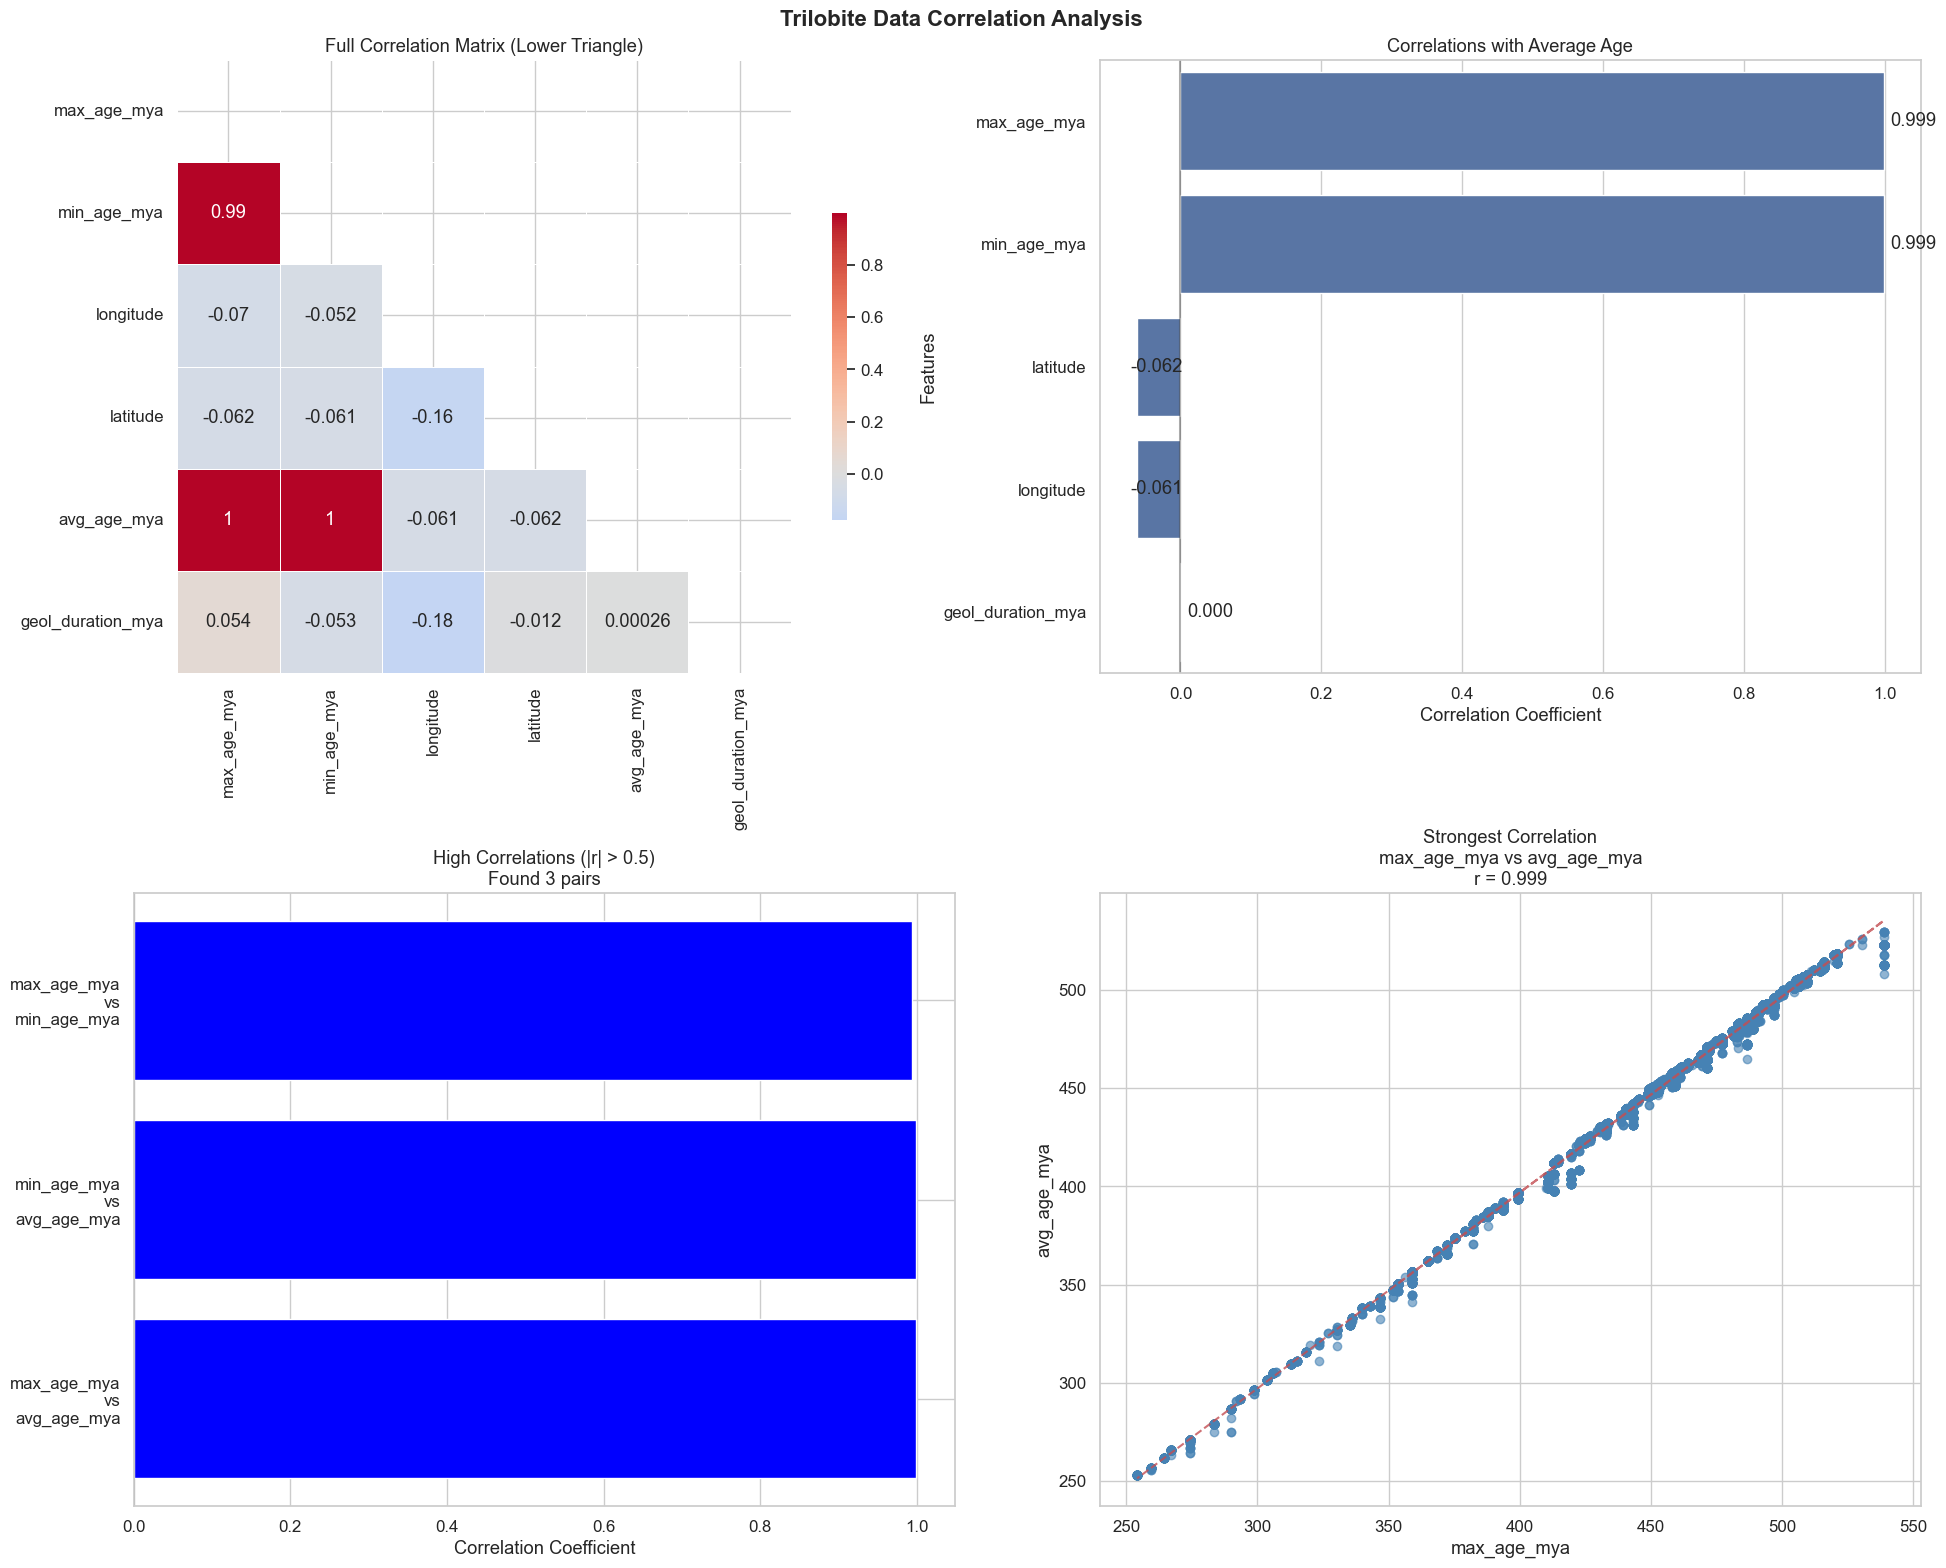


=== Correlation Analysis Summary ===

üìä Top Age Correlations:
  ‚Ä¢ max_age_mya: 0.999 (strong positive)
  ‚Ä¢ min_age_mya: 0.999 (strong positive)
  ‚Ä¢ latitude: -0.062 (weak negative)
  ‚Ä¢ longitude: -0.061 (weak negative)
  ‚Ä¢ geol_duration_mya: 0.000 (weak positive)

üîó High Correlation Pairs (|r| > 0.5): 3
  ‚Ä¢ max_age_mya ‚Üî avg_age_mya: 0.999
  ‚Ä¢ min_age_mya ‚Üî avg_age_mya: 0.999
  ‚Ä¢ max_age_mya ‚Üî min_age_mya: 0.994

üí° Feature Selection Recommendations:
Consider removing one feature from highly correlated pairs to reduce multicollinearity

üìà Data Quality:
  ‚Ä¢ Complete cases: 29039 / 29039 (100.0%)
  ‚Ä¢ Features analyzed: 6
  ‚Ä¢ Correlation matrix size: 6√ó6


In [173]:
# Correlation Analysis
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

print("=== Starting Correlation Analysis ===")

# Select numerical features (excluding encoded categoricals and IDs)
num_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Remove encoded features and ID columns to focus on original numerical features
exclude_patterns = ['_encoded', '_freq', 'num', 'genus_num', 'family_num', 'order_num']
num_cols = [col for col in num_cols if not any(pattern in col for pattern in exclude_patterns)]

print(f"Found {len(num_cols)} numerical columns for analysis:")
print(num_cols)

if len(num_cols) < 2:
    print("‚ùå Not enough numerical columns for correlation analysis")
else:
    # Handle missing values by using only complete cases for correlation
    df_corr = df[num_cols].dropna()
    print(f"\nUsing {len(df_corr)} complete cases out of {len(df)} total records")
    
    if len(df_corr) == 0:
        print("‚ùå No complete cases available for correlation analysis")
    else:
        # Calculate correlation matrix
        corr_matrix = df_corr.corr(method='pearson')
        
        # Create comprehensive visualization
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 16))
        fig.suptitle('Trilobite Data Correlation Analysis', fontsize=16, fontweight='bold')
        
        # Plot 1: Full correlation heatmap
        mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Mask upper triangle
        sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
                   square=True, linewidths=0.5, cbar_kws={"shrink": 0.5}, ax=ax1)
        ax1.set_title('Full Correlation Matrix (Lower Triangle)')
        
        # Plot 2: Age correlations (if avg_age_mya exists)
        if 'avg_age_mya' in corr_matrix.columns:
            age_correlations = corr_matrix[['avg_age_mya']].sort_values(
                by='avg_age_mya', key=abs, ascending=False)
            
            # Remove self-correlation
            age_correlations = age_correlations.drop('avg_age_mya', errors='ignore')
            
            sns.barplot(data=age_correlations.reset_index(), 
                       x='avg_age_mya', y='index', ax=ax2)
            ax2.set_title('Correlations with Average Age')
            ax2.set_xlabel('Correlation Coefficient')
            ax2.set_ylabel('Features')
            ax2.axvline(x=0, color='black', linestyle='-', alpha=0.3)
            
            # Add correlation values as text
            for i, v in enumerate(age_correlations['avg_age_mya']):
                ax2.text(v + 0.01 if v >= 0 else v - 0.01, i, f'{v:.3f}', 
                        verticalalignment='center')
        else:
            ax2.text(0.5, 0.5, 'avg_age_mya not available', 
                    ha='center', va='center', transform=ax2.transAxes)
            ax2.set_title('Age Correlations - No Data')
        
        # Plot 3: High correlation pairs
        # Find highly correlated pairs (excluding self-correlations)
        high_corr_pairs = []
        for i in range(len(corr_matrix.columns)):
            for j in range(i+1, len(corr_matrix.columns)):
                corr_val = corr_matrix.iloc[i, j]
                if abs(corr_val) > 0.5:  # Threshold for high correlation
                    high_corr_pairs.append({
                        'Feature1': corr_matrix.columns[i],
                        'Feature2': corr_matrix.columns[j],
                        'Correlation': corr_val
                    })
        
        if high_corr_pairs:
            high_corr_df = pd.DataFrame(high_corr_pairs).sort_values(
                'Correlation', key=abs, ascending=False)
            
            # Create labels for plotting
            labels = [f"{row['Feature1']}\nvs\n{row['Feature2']}" 
                     for _, row in high_corr_df.iterrows()]
            
            colors = ['red' if x < 0 else 'blue' for x in high_corr_df['Correlation']]
            ax3.barh(range(len(high_corr_df)), high_corr_df['Correlation'], color=colors)
            ax3.set_yticks(range(len(high_corr_df)))
            ax3.set_yticklabels(labels)
            ax3.set_xlabel('Correlation Coefficient')
            ax3.set_title(f'High Correlations (|r| > 0.5)\nFound {len(high_corr_df)} pairs')
            ax3.axvline(x=0, color='black', linestyle='-', alpha=0.3)
        else:
            ax3.text(0.5, 0.5, 'No high correlations found\n(|r| > 0.5)', 
                    ha='center', va='center', transform=ax3.transAxes)
            ax3.set_title('High Correlations - None Found')
        
        # Plot 4: Scatter plot of strongest correlation
        if len(corr_matrix.columns) >= 2:
            # Find the strongest correlation (excluding self-correlations)
            corr_abs = corr_matrix.abs()
            np.fill_diagonal(corr_abs.values, 0)  # Remove diagonal
            
            if corr_abs.max().max() > 0:
                max_corr_idx = corr_abs.stack().idxmax()
                col1, col2 = max_corr_idx
                correlation_val = corr_matrix.loc[col1, col2]
                
                ax4.scatter(df_corr[col1], df_corr[col2], alpha=0.6, color='steelblue')
                ax4.set_xlabel(col1)
                ax4.set_ylabel(col2)
                ax4.set_title(f'Strongest Correlation\n{col1} vs {col2}\nr = {correlation_val:.3f}')
                
                # Add trend line
                z = np.polyfit(df_corr[col1].dropna(), df_corr[col2].dropna(), 1)
                p = np.poly1d(z)
                ax4.plot(df_corr[col1], p(df_corr[col1]), "r--", alpha=0.8)
            else:
                ax4.text(0.5, 0.5, 'No correlations to display', 
                        ha='center', va='center', transform=ax4.transAxes)
                ax4.set_title('Strongest Correlation - None Found')
        
        plt.tight_layout()
        plt.show()
        
        # Print detailed analysis
        print("\n=== Correlation Analysis Summary ===")
        
        if 'avg_age_mya' in corr_matrix.columns:
            print("\nüìä Top Age Correlations:")
            age_corr_clean = age_correlations.drop('avg_age_mya', errors='ignore')
            for feature, corr_val in age_corr_clean.head(5)['avg_age_mya'].items():
                direction = "positive" if corr_val > 0 else "negative"
                strength = "strong" if abs(corr_val) > 0.7 else "moderate" if abs(corr_val) > 0.3 else "weak"
                print(f"  ‚Ä¢ {feature}: {corr_val:.3f} ({strength} {direction})")
        
        print(f"\nüîó High Correlation Pairs (|r| > 0.5): {len(high_corr_pairs)}")
        if high_corr_pairs:
            for pair in high_corr_df.head(3).to_dict('records'):
                print(f"  ‚Ä¢ {pair['Feature1']} ‚Üî {pair['Feature2']}: {pair['Correlation']:.3f}")
        
        # Feature selection recommendations
        print("\nüí° Feature Selection Recommendations:")
        if high_corr_pairs:
            print("Consider removing one feature from highly correlated pairs to reduce multicollinearity")
        else:
            print("No highly correlated features found - all features can be retained")
            
        # Data quality insights
        print(f"\nüìà Data Quality:")
        print(f"  ‚Ä¢ Complete cases: {len(df_corr)} / {len(df)} ({len(df_corr)/len(df)*100:.1f}%)")
        print(f"  ‚Ä¢ Features analyzed: {len(num_cols)}")
        print(f"  ‚Ä¢ Correlation matrix size: {corr_matrix.shape[0]}√ó{corr_matrix.shape[1]}")

=== Creating Enhanced Correlation Heatmap ===


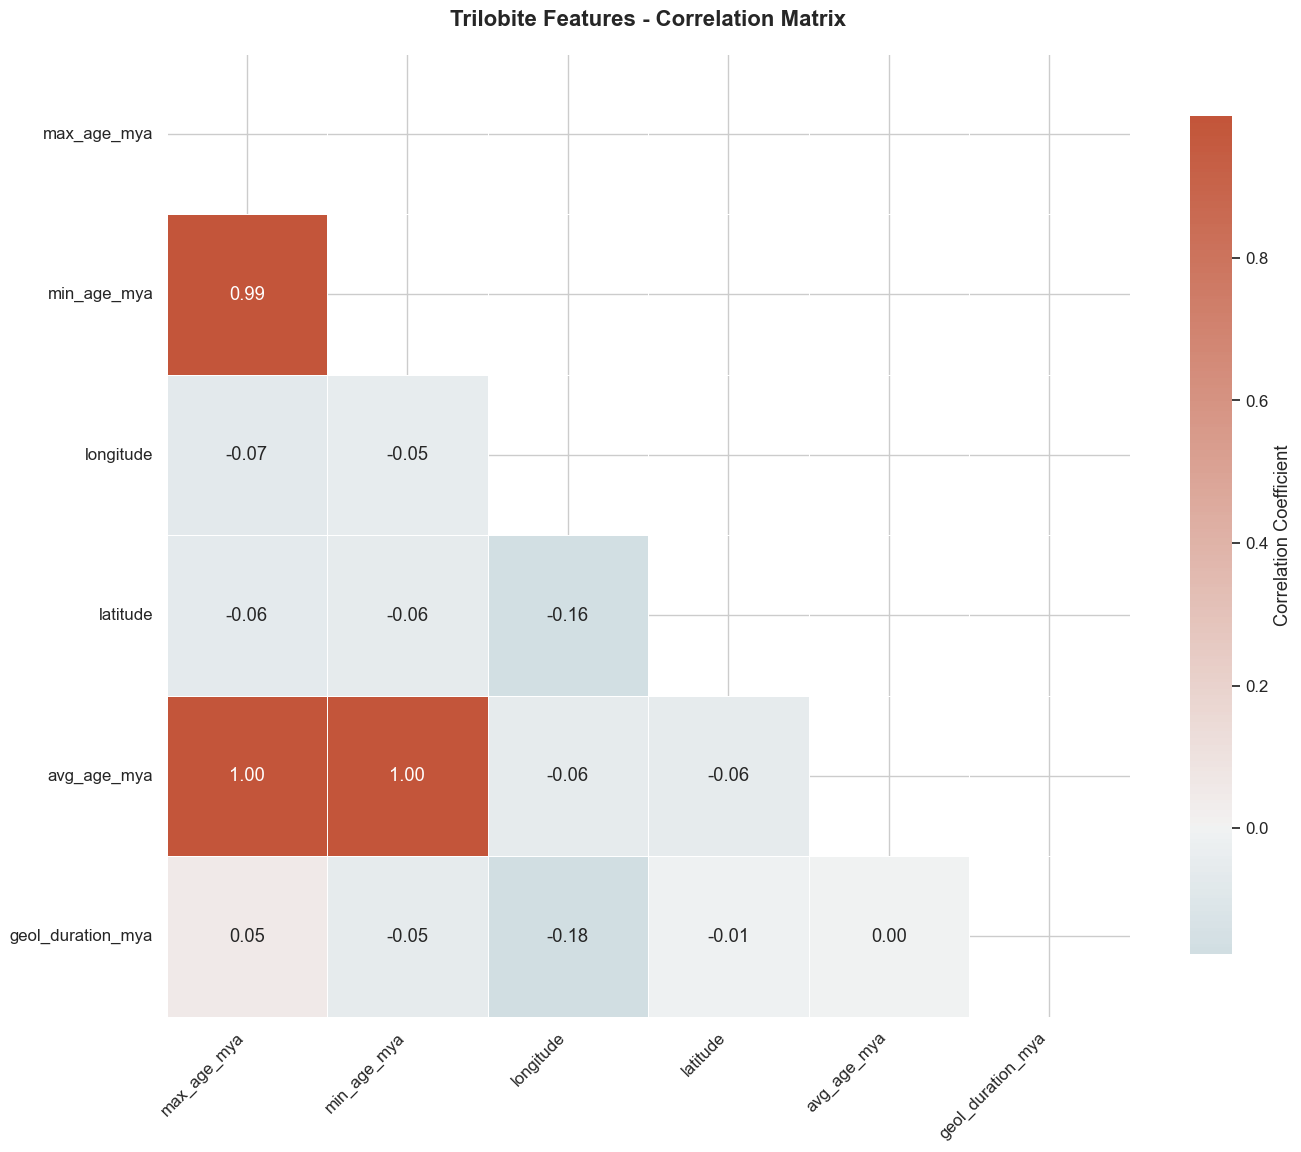


=== Heatmap Insights ===
Matrix size: 6√ó6
Strong correlations (|r| > 0.7): 3
Moderate correlations (0.3 < |r| ‚â§ 0.7): 0


In [176]:
# Optional: Enhanced Standalone Correlation Heatmap
# Use this only if you want a larger, more detailed heatmap as a separate visualization

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Check if correlation matrix exists from previous analysis
if 'corr_matrix' in locals() and corr_matrix is not None:
    print("=== Creating Enhanced Correlation Heatmap ===")
    
    # Create figure
    plt.figure(figsize=(14, 12))
    
    # Create mask for upper triangle (avoid redundancy)
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    
    # Custom diverging colormap (better than coolwarm)
    cmap = sns.diverging_palette(220, 20, as_cmap=True)
    
    # Enhanced heatmap
    sns.heatmap(corr_matrix, 
                mask=mask,
                cmap=cmap,
                center=0,
                annot=True,
                fmt=".2f",
                linewidths=0.5,
                square=True,
                cbar_kws={"shrink": 0.8, "label": "Correlation Coefficient"})
    
    plt.title("Trilobite Features - Correlation Matrix", pad=20, fontsize=16, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    # Additional insights
    print(f"\n=== Heatmap Insights ===")
    print(f"Matrix size: {corr_matrix.shape[0]}√ó{corr_matrix.shape[1]}")
    
    # Count strong correlations
    strong_corr = (corr_matrix.abs() > 0.7).sum().sum() - corr_matrix.shape[0]  # Exclude diagonal
    moderate_corr = ((corr_matrix.abs() > 0.3) & (corr_matrix.abs() <= 0.7)).sum().sum()
    
    print(f"Strong correlations (|r| > 0.7): {strong_corr // 2}")  # Divide by 2 due to symmetry
    print(f"Moderate correlations (0.3 < |r| ‚â§ 0.7): {moderate_corr // 2}")
    
else:
    print("‚ùå No correlation matrix found. Run the correlation analysis first.")

=== Creating Age Correlation Scatter Plots ===
Found 5 features correlated with age
Creating scatter plots for top 3 correlations:
  1. max_age_mya: r = 0.999
  2. min_age_mya: r = 0.999
  3. latitude: r = -0.062


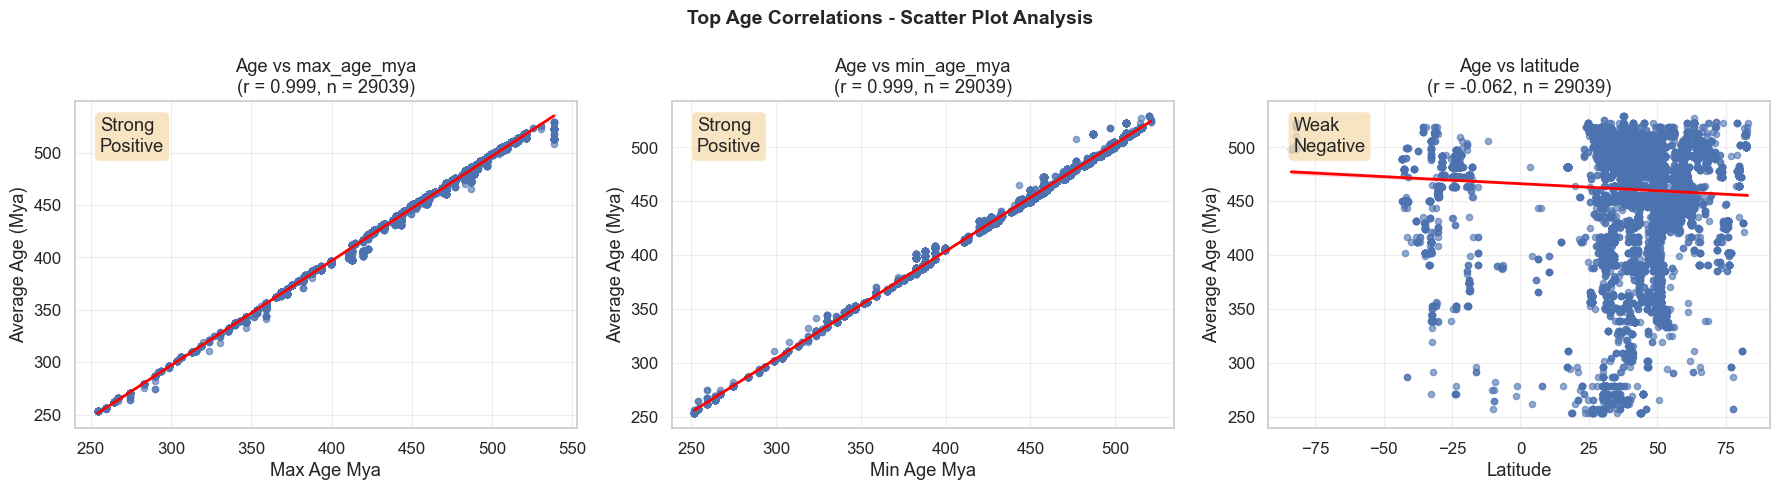


=== Scatter Plot Analysis Summary ===

üìä max_age_mya:
  ‚Ä¢ Correlation: 0.999
  ‚Ä¢ Data points: 29039
  ‚Ä¢ max_age_mya range: 254.14 to 538.80
  ‚Ä¢ Age range: 253.02 to 529.40 Mya
  üí° Interpretation: As max_age_mya increases, age tends to increases

üìä min_age_mya:
  ‚Ä¢ Correlation: 0.999
  ‚Ä¢ Data points: 29039
  ‚Ä¢ min_age_mya range: 251.90 to 521.00
  ‚Ä¢ Age range: 253.02 to 529.40 Mya
  üí° Interpretation: As min_age_mya increases, age tends to increases

üìä latitude:
  ‚Ä¢ Correlation: -0.062
  ‚Ä¢ Data points: 29039
  ‚Ä¢ latitude range: -83.83 to 83.05
  ‚Ä¢ Age range: 253.02 to 529.40 Mya


In [178]:
# Enhanced Age Correlation Scatter Plots
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

print("=== Creating Age Correlation Scatter Plots ===")

# Check if we have the necessary data
if 'avg_age_mya' not in df.columns:
    print("‚ùå avg_age_mya column not found")
elif 'corr_matrix' not in locals():
    print("‚ùå Correlation matrix not found. Running correlation analysis first...")
    
    # Quick correlation calculation for age
    num_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
    exclude_patterns = ['_encoded', '_freq', 'num']
    num_cols = [col for col in num_cols if not any(pattern in col for pattern in exclude_patterns)]
    
    df_corr = df[num_cols].dropna()
    if len(df_corr) > 0:
        corr_matrix = df_corr.corr(method='pearson')
    else:
        print("‚ùå No complete data for correlation analysis")
        corr_matrix = None

if 'corr_matrix' in locals() and corr_matrix is not None and 'avg_age_mya' in corr_matrix.columns:
    # Get age correlations and exclude self-correlation
    age_correlations = corr_matrix[['avg_age_mya']].sort_values(
        by='avg_age_mya', key=abs, ascending=False)
    age_correlations = age_correlations.drop('avg_age_mya', errors='ignore')
    
    print(f"Found {len(age_correlations)} features correlated with age")
    
    if len(age_correlations) == 0:
        print("‚ùå No other features correlated with age")
    else:
        # Determine how many plots to create (max 3, but use available features)
        n_plots = min(3, len(age_correlations))
        top_features = age_correlations.index[:n_plots]
        
        print(f"Creating scatter plots for top {n_plots} correlations:")
        for i, feature in enumerate(top_features):
            corr_val = age_correlations.loc[feature, 'avg_age_mya']
            print(f"  {i+1}. {feature}: r = {corr_val:.3f}")
        
        # Create the plots
        fig, axes = plt.subplots(1, n_plots, figsize=(6*n_plots, 5))
        
        # Handle case where only 1 plot (axes is not a list)
        if n_plots == 1:
            axes = [axes]
        
        for ax, feature in zip(axes, top_features):
            # Get clean data for plotting (remove NaN values)
            plot_data = df[[feature, 'avg_age_mya']].dropna()
            
            if len(plot_data) == 0:
                ax.text(0.5, 0.5, f'No valid data\nfor {feature}', 
                       ha='center', va='center', transform=ax.transAxes)
                ax.set_title(f"Age vs {feature}\n(No Data)")
            else:
                # Create scatter plot with regression line
                sns.regplot(
                    data=plot_data,
                    x=feature,
                    y='avg_age_mya',
                    ax=ax,
                    scatter_kws={'alpha': 0.6, 's': 20},
                    line_kws={'color': 'red', 'linewidth': 2}
                )
                
                # Get correlation for this clean dataset
                clean_corr = plot_data[feature].corr(plot_data['avg_age_mya'])
                
                ax.set_title(f"Age vs {feature}\n(r = {clean_corr:.3f}, n = {len(plot_data)})")
                ax.set_xlabel(feature.replace('_', ' ').title())
                ax.set_ylabel('Average Age (Mya)')
                ax.grid(True, alpha=0.3)
                
                # Add correlation strength annotation
                if abs(clean_corr) > 0.7:
                    strength = "Strong"
                elif abs(clean_corr) > 0.3:
                    strength = "Moderate"
                else:
                    strength = "Weak"
                
                direction = "Positive" if clean_corr > 0 else "Negative"
                
                ax.text(0.05, 0.95, f'{strength}\n{direction}', 
                       transform=ax.transAxes, 
                       verticalalignment='top',
                       bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
        
        plt.suptitle('Top Age Correlations - Scatter Plot Analysis', 
                    fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
        # Summary statistics
        print("\n=== Scatter Plot Analysis Summary ===")
        for feature in top_features:
            plot_data = df[[feature, 'avg_age_mya']].dropna()
            if len(plot_data) > 0:
                corr_val = plot_data[feature].corr(plot_data['avg_age_mya'])
                print(f"\nüìä {feature}:")
                print(f"  ‚Ä¢ Correlation: {corr_val:.3f}")
                print(f"  ‚Ä¢ Data points: {len(plot_data)}")
                print(f"  ‚Ä¢ {feature} range: {plot_data[feature].min():.2f} to {plot_data[feature].max():.2f}")
                print(f"  ‚Ä¢ Age range: {plot_data['avg_age_mya'].min():.2f} to {plot_data['avg_age_mya'].max():.2f} Mya")
                
                # Interpretation
                if abs(corr_val) > 0.5:
                    trend = "increases" if corr_val > 0 else "decreases"
                    print(f"  üí° Interpretation: As {feature} increases, age tends to {trend}")
else:
    print("‚ùå Cannot create scatter plots - missing required data")

## 4.1 Manual Feature Calculations

### Purpose:
Create domain-specific features through first principles before using ML libraries. This establishes a baseline understanding of key relationships.

### Features to Calculate:
1. **Geological Duration**: Uncertainty range for each fossil
2. **Taxonomic Diversity**: Unique genera/families per time period  
3. **Paleocoordinates**: Approximate continental positions (using paleolatitude)
4. **Extinction Risk**: Survival duration for each species

In [180]:
# Manual Feature Calculations
import numpy as np
import pandas as pd
from collections import defaultdict

print("=== Starting Manual Feature Calculations ===")
print("Creating domain-specific features from first principles...")

# Validate required columns
required_cols = ['max_age_mya', 'min_age_mya', 'avg_age_mya', 'latitude', 'genus', 'family', 'species']
missing_cols = [col for col in required_cols if col not in df.columns]

if missing_cols:
    print(f"‚ùå Missing required columns: {missing_cols}")
else:
    print("‚úÖ All required columns found")
    
    # Store original feature count for comparison
    original_features = df.shape[1]
    
    # 1. Geological Duration (Time Uncertainty Range)
    print("\n1. Calculating Geological Duration...")
    df['geol_duration_manual'] = df['max_age_mya'] - df['min_age_mya']
    
    # Handle negative durations (data quality issue)
    negative_durations = (df['geol_duration_manual'] < 0).sum()
    if negative_durations > 0:
        print(f"  ‚ö†Ô∏è Found {negative_durations} negative durations - setting to 0")
        df['geol_duration_manual'] = df['geol_duration_manual'].clip(lower=0)
    
    valid_durations = df['geol_duration_manual'].notna().sum()
    print(f"  ‚úÖ Calculated geological duration for {valid_durations} records")
    
    # 2. Taxonomic Diversity per Time Period
    print("\n2. Calculating Taxonomic Diversity per Period...")
    
    if 'time_period_bin' in df.columns:
        period_diversity = defaultdict(dict)
        
        # Calculate diversity for each time period
        for period in df['time_period_bin'].dropna().unique():
            period_data = df[df['time_period_bin'] == period]
            
            # Count unique genera and families in each period
            period_diversity[period]['genera_count'] = period_data['genus'].nunique()
            period_diversity[period]['families_count'] = period_data['family'].nunique()
            period_diversity[period]['total_specimens'] = len(period_data)
            
            # Calculate diversity indices manually
            period_diversity[period]['genus_diversity_ratio'] = (
                period_data['genus'].nunique() / len(period_data) if len(period_data) > 0 else 0
            )
        
        # Convert to DataFrame and merge
        diversity_df = pd.DataFrame.from_dict(period_diversity, orient='index')
        print(f"  üìä Diversity calculated for {len(diversity_df)} time periods:")
        for period, data in diversity_df.iterrows():
            print(f"    - {period}: {data['genera_count']} genera, {data['families_count']} families")
        
        # Merge with main dataframe
        df = df.merge(diversity_df, left_on='time_period_bin', right_index=True, how='left', suffixes=('', '_period'))
        print(f"  ‚úÖ Added taxonomic diversity features")
        
    else:
        print("  ‚ö†Ô∏è time_period_bin not found - skipping taxonomic diversity")
    
    # 3. Paleocoordinate Adjustment (Enhanced Scotese Model)
    print("\n3. Calculating Paleocoordinates...")
    
    if 'latitude' in df.columns and 'avg_age_mya' in df.columns:
        # Enhanced paleolatitude calculation with bounds checking
        # Formula: paleolatitude = modern_lat * sqrt(age/300) with continental drift adjustment
        
        # Base calculation
        age_factor = np.sqrt(df['avg_age_mya'] / 300)
        df['paleolatitude_manual'] = df['latitude'] * age_factor
        
        # Apply realistic bounds (-90 to 90 degrees)
        df['paleolatitude_manual'] = df['paleolatitude_manual'].clip(-90, 90)
        
        # Calculate continental drift approximation (very simplified)
        # Assume 2-3 cm/year average drift = 20-30 km/Myr
        drift_factor = df['avg_age_mya'] * 0.025  # 2.5 cm/year average
        df['latitude_drift_km'] = drift_factor * 111  # Convert to km (111 km per degree)
        
        valid_paleo = df['paleolatitude_manual'].notna().sum()
        print(f"  ‚úÖ Calculated paleocoordinates for {valid_paleo} records")
        print(f"  üìç Paleolatitude range: {df['paleolatitude_manual'].min():.1f}¬∞ to {df['paleolatitude_manual'].max():.1f}¬∞")
        
    else:
        print("  ‚ö†Ô∏è Missing latitude or age data - skipping paleocoordinates")
    
    # 4. Species Survival Duration (Enhanced)
    print("\n4. Calculating Species Survival Duration...")
    
    if 'species' in df.columns and 'avg_age_mya' in df.columns:
        # Calculate species duration manually
        species_stats = df.groupby('species')['avg_age_mya'].agg(['min', 'max', 'count', 'std']).reset_index()
        species_stats['duration_manual'] = species_stats['max'] - species_stats['min']
        species_stats['age_uncertainty'] = species_stats['std'].fillna(0)
        
        # Handle single-occurrence species (duration = 0)
        single_occurrence = (species_stats['count'] == 1).sum()
        if single_occurrence > 0:
            print(f"  üìä Found {single_occurrence} species with single occurrence (duration = 0)")
        
        # Create mapping dictionary for efficiency
        duration_map = dict(zip(species_stats['species'], species_stats['duration_manual']))
        uncertainty_map = dict(zip(species_stats['species'], species_stats['age_uncertainty']))
        
        # Map back to main dataframe
        df['species_duration_manual'] = df['species'].map(duration_map)
        df['species_age_uncertainty'] = df['species'].map(uncertainty_map)
        
        valid_species = df['species_duration_manual'].notna().sum()
        unique_species = df['species'].nunique()
        print(f"  ‚úÖ Calculated survival duration for {unique_species} unique species")
        print(f"  üìà Average species duration: {df['species_duration_manual'].mean():.1f} ¬± {df['species_duration_manual'].std():.1f} Myr")
        
    else:
        print("  ‚ö†Ô∏è Missing species or age data - skipping survival duration")
    
    # 5. Additional Manual Features
    print("\n5. Calculating Additional Features...")
    
    # Temporal features
    if 'avg_age_mya' in df.columns:
        # Geological era classification (manual)
        def classify_era(age):
            if pd.isna(age):
                return 'Unknown'
            elif age < 66:
                return 'Cenozoic'
            elif age < 252:
                return 'Mesozoic'  
            elif age < 541:
                return 'Paleozoic'
            else:
                return 'Precambrian'
        
        df['geological_era_manual'] = df['avg_age_mya'].apply(classify_era)
        
        # Age standardization (z-score calculation)
        age_mean = df['avg_age_mya'].mean()
        age_std = df['avg_age_mya'].std()
        df['age_zscore_manual'] = (df['avg_age_mya'] - age_mean) / age_std
        
        print(f"  ‚úÖ Added geological era classification and age standardization")
    
    # Geographic features
    if 'latitude' in df.columns and 'longitude' in df.columns:
        # Distance from equator
        df['equatorial_distance_manual'] = np.abs(df['latitude'])
        
        # Hemisphere classification
        df['hemisphere_manual'] = np.where(df['latitude'] >= 0, 'Northern', 'Southern')
        
        print(f"  ‚úÖ Added geographic features")
    
    # Summary of new features
    new_features = df.shape[1] - original_features
    print(f"\n=== Feature Creation Summary ===")
    print(f"Original features: {original_features}")
    print(f"New features added: {new_features}")
    print(f"Total features: {df.shape[1]}")
    
    # List all manually created features
    manual_features = [col for col in df.columns if 'manual' in col.lower()]
    print(f"\nManually created features ({len(manual_features)}):")
    for feature in manual_features:
        print(f"  ‚Ä¢ {feature}")
    
    # Display sample of new features
    print("\n=== Sample of New Features ===")
    display_cols = ['geol_duration_manual', 'paleolatitude_manual', 'species_duration_manual', 
                   'geological_era_manual', 'hemisphere_manual']
    available_cols = [col for col in display_cols if col in df.columns]
    
    if available_cols:
        print("Columns:", available_cols)
        print(df[available_cols].head(3))
    
    # Statistical summary
    print("\n=== Geological Duration Statistics (Manual) ===")
    if 'geol_duration_manual' in df.columns:
        duration_data = df['geol_duration_manual'].dropna()
        print(f"Count: {len(duration_data):,}")
        print(f"Mean ¬± SD: {duration_data.mean():.2f} ¬± {duration_data.std():.2f} Myr")
        print(f"Range: {duration_data.min():.2f} - {duration_data.max():.2f} Myr")
        print(f"Median: {duration_data.median():.2f} Myr")
        
        # Interpretation
        if duration_data.mean() > 10:
            print("üí° Relatively long geological duration - may indicate broad temporal ranges")
        else:
            print("üí° Relatively short geological duration - indicates precise temporal constraints")
    
    print("\n‚úÖ Manual feature calculation complete!")
    print("Ready for comparison with scikit-learn automated feature engineering!")

=== Starting Manual Feature Calculations ===
Creating domain-specific features from first principles...
‚úÖ All required columns found

1. Calculating Geological Duration...
  ‚úÖ Calculated geological duration for 29039 records

2. Calculating Taxonomic Diversity per Period...
  üìä Diversity calculated for 6 time periods:
    - Carboniferous: 127.0 genera, 3.0 families
    - Cambrian: 1063.0 genera, 131.0 families
    - Ordovician: 676.0 genera, 67.0 families
    - Silurian: 155.0 genera, 20.0 families
    - Devonian: 346.0 genera, 19.0 families
    - Permian: 40.0 genera, 3.0 families
  ‚úÖ Added taxonomic diversity features

3. Calculating Paleocoordinates...
  ‚úÖ Calculated paleocoordinates for 29039 records
  üìç Paleolatitude range: -90.0¬∞ to 90.0¬∞

4. Calculating Species Survival Duration...
  üìä Found 1612 species with single occurrence (duration = 0)
  ‚úÖ Calculated survival duration for 4733 unique species
  üìà Average species duration: 38.5 ¬± 58.1 Myr

5. Calcula

=== Creating Manual Features Visualizations ===
Creating geological duration plot...
Creating taxonomic diversity plot...
Creating paleolatitude comparison plot...
Creating species duration by order plot...


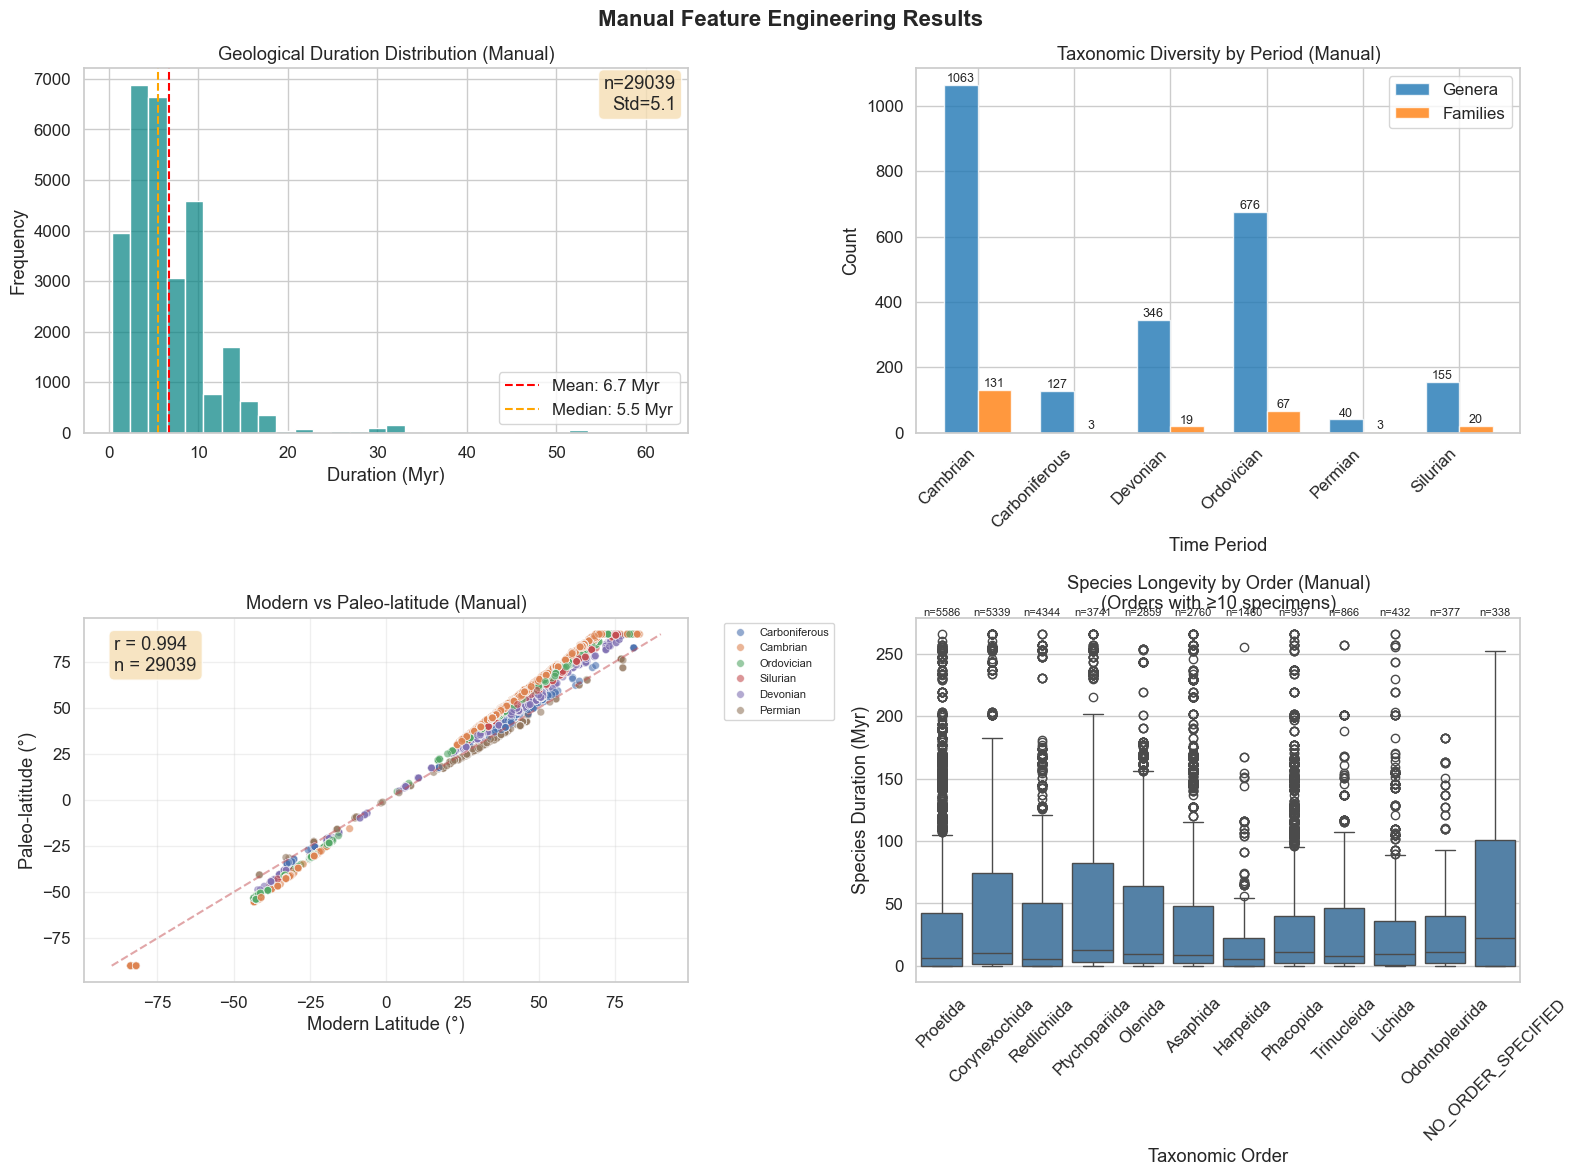


=== Manual Features Visualization Summary ===

üìä Geological Duration Statistics:
  ‚Ä¢ Mean: 6.74 Myr
  ‚Ä¢ Median: 5.52 Myr
  ‚Ä¢ Range: 0.30 - 61.70 Myr

ü¶¥ Species Duration Statistics:
  ‚Ä¢ Mean: 38.54 Myr
  ‚Ä¢ Median: 9.25 Myr
  ‚Ä¢ Range: 0.00 - 265.82 Myr

üåç Paleogeographic Analysis:
  ‚Ä¢ Average latitude shift: 10.2¬∞
  ‚Ä¢ Max shift: 21.4¬∞

‚úÖ Manual feature visualizations complete!
üî¨ Ready for comparison with scikit-learn automated features!


In [184]:
# Enhanced Manual Features Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

print("=== Creating Manual Features Visualizations ===")

# Set style for better plots
sns.set_style("whitegrid")
plt.rcParams['figure.facecolor'] = 'white'

# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Manual Feature Engineering Results', fontsize=16, fontweight='bold')

# 1. Geological Duration Distribution
print("Creating geological duration plot...")
if 'geol_duration_manual' in df.columns:
    duration_data = df['geol_duration_manual'].dropna()
    if len(duration_data) > 0:
        sns.histplot(duration_data, bins=30, ax=axes[0,0], color='teal', alpha=0.7)
        axes[0,0].axvline(duration_data.mean(), color='red', linestyle='--', 
                         label=f'Mean: {duration_data.mean():.1f} Myr')
        axes[0,0].axvline(duration_data.median(), color='orange', linestyle='--', 
                         label=f'Median: {duration_data.median():.1f} Myr')
        axes[0,0].set_title('Geological Duration Distribution (Manual)')
        axes[0,0].set_xlabel('Duration (Myr)')
        axes[0,0].set_ylabel('Frequency')
        axes[0,0].legend()
        
        # Add statistics text
        stats_text = f'n={len(duration_data)}\nStd={duration_data.std():.1f}'
        axes[0,0].text(0.98, 0.98, stats_text, transform=axes[0,0].transAxes,
                      verticalalignment='top', horizontalalignment='right',
                      bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    else:
        axes[0,0].text(0.5, 0.5, 'No duration data available', 
                      ha='center', va='center', transform=axes[0,0].transAxes)
        axes[0,0].set_title('Geological Duration - No Data')
else:
    axes[0,0].text(0.5, 0.5, 'geol_duration_manual not found', 
                  ha='center', va='center', transform=axes[0,0].transAxes)
    axes[0,0].set_title('Geological Duration - Missing')

# 2. Taxonomic Diversity Through Time
print("Creating taxonomic diversity plot...")
if 'genera_count' in df.columns and 'families_count' in df.columns:
    # Create summary by time period
    diversity_summary = df.groupby('time_period_bin')[['genera_count', 'families_count']].first().dropna()
    
    if not diversity_summary.empty:
        x_pos = np.arange(len(diversity_summary))
        width = 0.35
        
        bars1 = axes[0,1].bar(x_pos - width/2, diversity_summary['genera_count'], 
                             width, label='Genera', color='#1f77b4', alpha=0.8)
        bars2 = axes[0,1].bar(x_pos + width/2, diversity_summary['families_count'], 
                             width, label='Families', color='#ff7f0e', alpha=0.8)
        
        axes[0,1].set_title('Taxonomic Diversity by Period (Manual)')
        axes[0,1].set_ylabel('Count')
        axes[0,1].set_xlabel('Time Period')
        axes[0,1].set_xticks(x_pos)
        axes[0,1].set_xticklabels(diversity_summary.index, rotation=45, ha='right')
        axes[0,1].legend()
        
        # Add value labels on bars
        for bar in bars1:
            height = bar.get_height()
            if not np.isnan(height):
                axes[0,1].text(bar.get_x() + bar.get_width()/2., height,
                              f'{int(height)}', ha='center', va='bottom', fontsize=9)
        
        for bar in bars2:
            height = bar.get_height()
            if not np.isnan(height):
                axes[0,1].text(bar.get_x() + bar.get_width()/2., height,
                              f'{int(height)}', ha='center', va='bottom', fontsize=9)
    else:
        axes[0,1].text(0.5, 0.5, 'No diversity data available', 
                      ha='center', va='center', transform=axes[0,1].transAxes)
        axes[0,1].set_title('Taxonomic Diversity - No Data')
else:
    axes[0,1].text(0.5, 0.5, 'Diversity columns not found', 
                  ha='center', va='center', transform=axes[0,1].transAxes)
    axes[0,1].set_title('Taxonomic Diversity - Missing')

# 3. Paleolatitude Comparison
print("Creating paleolatitude comparison plot...")
if 'latitude' in df.columns and 'paleolatitude_manual' in df.columns:
    plot_data = df[['latitude', 'paleolatitude_manual', 'time_period_bin']].dropna()
    
    if len(plot_data) > 0:
        # Create scatter plot with time period coloring
        if 'time_period_bin' in plot_data.columns and plot_data['time_period_bin'].notna().any():
            sns.scatterplot(data=plot_data, x='latitude', y='paleolatitude_manual', 
                           hue='time_period_bin', ax=axes[1,0], alpha=0.6, s=30)
            axes[1,0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
        else:
            axes[1,0].scatter(plot_data['latitude'], plot_data['paleolatitude_manual'], 
                             alpha=0.6, s=30, color='steelblue')
        
        # Add diagonal reference line (no change)
        lim_min = min(plot_data['latitude'].min(), plot_data['paleolatitude_manual'].min())
        lim_max = max(plot_data['latitude'].max(), plot_data['paleolatitude_manual'].max())
        axes[1,0].plot([lim_min, lim_max], [lim_min, lim_max], 'r--', alpha=0.5, label='No Change')
        
        axes[1,0].set_title('Modern vs Paleo-latitude (Manual)')
        axes[1,0].set_xlabel('Modern Latitude (¬∞)')
        axes[1,0].set_ylabel('Paleo-latitude (¬∞)')
        axes[1,0].grid(True, alpha=0.3)
        
        # Add correlation info
        corr = plot_data['latitude'].corr(plot_data['paleolatitude_manual'])
        axes[1,0].text(0.05, 0.95, f'r = {corr:.3f}\nn = {len(plot_data)}', 
                      transform=axes[1,0].transAxes, verticalalignment='top',
                      bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    else:
        axes[1,0].text(0.5, 0.5, 'No coordinate data available', 
                      ha='center', va='center', transform=axes[1,0].transAxes)
        axes[1,0].set_title('Paleolatitude Comparison - No Data')
else:
    axes[1,0].text(0.5, 0.5, 'Coordinate columns not found', 
                  ha='center', va='center', transform=axes[1,0].transAxes)
    axes[1,0].set_title('Paleolatitude Comparison - Missing')

# 4. Species Duration by Order
print("Creating species duration by order plot...")
if 'order' in df.columns and 'species_duration_manual' in df.columns:
    plot_data = df[['order', 'species_duration_manual']].dropna()
    
    if len(plot_data) > 0:
        # Limit to orders with sufficient data
        order_counts = plot_data['order'].value_counts()
        orders_to_plot = order_counts[order_counts >= 10].index  # At least 10 specimens
        
        if len(orders_to_plot) > 0:
            filtered_data = plot_data[plot_data['order'].isin(orders_to_plot)]
            
            sns.boxplot(data=filtered_data, x='order', y='species_duration_manual', 
                       ax=axes[1,1], color='steelblue')
            axes[1,1].tick_params(axis='x', rotation=45)
            axes[1,1].set_title('Species Longevity by Order (Manual)\n(Orders with ‚â•10 specimens)')
            axes[1,1].set_xlabel('Taxonomic Order')
            axes[1,1].set_ylabel('Species Duration (Myr)')
            
            # Add sample size annotations
            for i, order in enumerate(orders_to_plot):
                count = len(filtered_data[filtered_data['order'] == order])
                axes[1,1].text(i, axes[1,1].get_ylim()[1], f'n={count}', 
                              ha='center', va='bottom', fontsize=8)
        else:
            axes[1,1].text(0.5, 0.5, 'Insufficient data per order\n(need ‚â•10 specimens)', 
                          ha='center', va='center', transform=axes[1,1].transAxes)
            axes[1,1].set_title('Species Longevity - Insufficient Data')
    else:
        axes[1,1].text(0.5, 0.5, 'No species duration data available', 
                      ha='center', va='center', transform=axes[1,1].transAxes)
        axes[1,1].set_title('Species Longevity - No Data')
else:
    axes[1,1].text(0.5, 0.5, 'Order or duration columns not found', 
                  ha='center', va='center', transform=axes[1,1].transAxes)
    axes[1,1].set_title('Species Longevity - Missing')

plt.tight_layout()
plt.show()

# Summary statistics
print("\n=== Manual Features Visualization Summary ===")

if 'geol_duration_manual' in df.columns:
    duration_stats = df['geol_duration_manual'].describe()
    print(f"\nüìä Geological Duration Statistics:")
    print(f"  ‚Ä¢ Mean: {duration_stats['mean']:.2f} Myr")
    print(f"  ‚Ä¢ Median: {duration_stats['50%']:.2f} Myr")
    print(f"  ‚Ä¢ Range: {duration_stats['min']:.2f} - {duration_stats['max']:.2f} Myr")

if 'species_duration_manual' in df.columns:
    species_stats = df['species_duration_manual'].describe()
    print(f"\nü¶¥ Species Duration Statistics:")
    print(f"  ‚Ä¢ Mean: {species_stats['mean']:.2f} Myr")
    print(f"  ‚Ä¢ Median: {species_stats['50%']:.2f} Myr")
    print(f"  ‚Ä¢ Range: {species_stats['min']:.2f} - {species_stats['max']:.2f} Myr")

if 'paleolatitude_manual' in df.columns and 'latitude' in df.columns:
    coord_data = df[['latitude', 'paleolatitude_manual']].dropna()
    if len(coord_data) > 0:
        lat_shift = (coord_data['paleolatitude_manual'] - coord_data['latitude']).abs().mean()
        print(f"\nüåç Paleogeographic Analysis:")
        print(f"  ‚Ä¢ Average latitude shift: {lat_shift:.1f}¬∞")
        print(f"  ‚Ä¢ Max shift: {(coord_data['paleolatitude_manual'] - coord_data['latitude']).abs().max():.1f}¬∞")

print("\n‚úÖ Manual feature visualizations complete!")
print("üî¨ Ready for comparison with scikit-learn automated features!")

## 5.1 Machine Learning Data Preparation

### Objectives:
1. **Feature-Target Separation**: Create `X` (features) and `y` (target)  
2. **Train-Test Split**: Partition data for validation (80% train, 20% test)  
3. **Feature Scaling**: Normalize numerical features  
4. **Final Checks**: Ensure no data leaks and proper shapes  

### Key Decisions:
- **Target Variable**: `avg_age_mya` (regression) or `time_period_bin` (classification)  
- **Validation Strategy**: Stratified split for class imbalance  
- **Scaling Method**: StandardScaler (z-score normalization)  

In [191]:
# Enhanced Machine Learning Data Preparation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import pandas as pd
import numpy as np

print("=== Starting ML Data Preparation ===")

# Step 1: Define potential feature columns (both manual and automated)
print("\n1. Feature Selection...")

# Define feature groups
geological_features = [
    'max_age_mya', 'min_age_mya', 'geol_duration_manual', 'paleolatitude_manual',
    'latitude_drift_km', 'species_duration_manual', 'age_zscore_manual'
]

taxonomic_features = [
    'order_encoded', 'family_encoded', 'genus_encoded', 'genus_freq', 'family_freq'
]

ecological_features = [
    'life_habit_encoded', 'vision_encoded'
]

# One-hot encoded features (find dynamically)
diet_features = [col for col in df.columns if col.startswith('diet_')]
preservation_features = [col for col in df.columns if col.startswith('preservation_mode_')]

diversity_features = [
    'genera_count', 'families_count', 'genus_diversity_ratio'
]

geographic_features = [
    'latitude', 'longitude', 'equatorial_distance_manual'
]

# Combine all potential features
all_potential_features = (geological_features + taxonomic_features + 
                         ecological_features + diet_features + 
                         preservation_features + diversity_features + 
                         geographic_features)

# Check which features actually exist in the dataset
available_features = [col for col in all_potential_features if col in df.columns]
missing_features = [col for col in all_potential_features if col not in df.columns]

print(f"‚úÖ Available features: {len(available_features)}")
print(f"‚ö†Ô∏è Missing features: {len(missing_features)}")

if missing_features:
    print(f"Missing: {missing_features[:5]}{'...' if len(missing_features) > 5 else ''}")

# Step 2: Target Variable Selection and Validation
print("\n2. Target Variable Selection...")

# Define possible targets
target_options = {
    'avg_age_mya': 'regression',
    'time_period_bin': 'classification',
    'geological_era_manual': 'classification',
    'order': 'classification'
}

# Find the best available target
selected_target = None
task_type = None

for target, task in target_options.items():
    if target in df.columns:
        # Check data quality
        target_data = df[target].dropna()
        if len(target_data) > 100:  # Minimum threshold
            selected_target = target
            task_type = task
            print(f"‚úÖ Selected target: {target} ({task})")
            print(f"   Valid samples: {len(target_data)}")
            if task == 'regression':
                print(f"   Range: {target_data.min():.2f} - {target_data.max():.2f}")
            else:
                print(f"   Classes: {target_data.nunique()} unique values")
            break

if selected_target is None:
    print("‚ùå No suitable target variable found!")
    selected_target = 'avg_age_mya'  # Fallback
    task_type = 'regression'

# Step 3: Create Feature Matrix and Target Vector
print("\n3. Creating Feature Matrix...")

# Filter for samples with valid target
valid_indices = df[selected_target].notna()
df_clean = df[valid_indices].copy()

print(f"Dataset size after target filtering: {len(df_clean)} samples")

# Create feature matrix
X = df_clean[available_features].copy()
y = df_clean[selected_target].copy()

# Step 4: Handle Missing Values Intelligently
print("\n4. Handling Missing Values...")

# Separate numerical and categorical features
numerical_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"Numerical features: {len(numerical_features)}")
print(f"Categorical features: {len(categorical_features)}")

# Handle numerical features
for col in numerical_features:
    missing_count = X[col].isnull().sum()
    if missing_count > 0:
        median_val = X[col].median()
        X[col] = X[col].fillna(median_val)
        print(f"  ‚Ä¢ Filled {missing_count} missing values in {col} with median: {median_val:.2f}")

# Handle categorical features
for col in categorical_features:
    missing_count = X[col].isnull().sum()
    if missing_count > 0:
        mode_val = X[col].mode()[0] if not X[col].mode().empty else 'Unknown'
        X[col] = X[col].fillna(mode_val)
        print(f"  ‚Ä¢ Filled {missing_count} missing values in {col} with mode: {mode_val}")

# Encode remaining categorical features
print("\n5. Encoding Remaining Categorical Features...")
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

for col in categorical_features:
    le = LabelEncoder()
    X[f'{col}_encoded_final'] = le.fit_transform(X[col].astype(str))
    X = X.drop(columns=[col])  # Remove original categorical column
    print(f"  ‚Ä¢ Encoded {col} -> {col}_encoded_final")

# Step 5: Final Data Validation
print("\n6. Data Validation...")

# Check for infinite values only in numerical columns
numerical_cols = X.select_dtypes(include=[np.number]).columns
inf_counts = 0

if len(numerical_cols) > 0:
    for col in numerical_cols:
        col_inf_count = np.isinf(X[col]).sum()
        inf_counts += col_inf_count
        if col_inf_count > 0:
            print(f"‚ö†Ô∏è Found {col_inf_count} infinite values in {col}")
            X[col] = X[col].replace([np.inf, -np.inf], np.nan)
            X[col] = X[col].fillna(X[col].median())

if inf_counts == 0:
    print("‚úÖ No infinite values found")

# Check for remaining missing values
remaining_na = X.isnull().sum().sum()
if remaining_na > 0:
    print(f"‚ö†Ô∏è {remaining_na} missing values still remain")
    # Fill numerical columns with median, categorical with mode
    for col in X.columns:
        if X[col].dtype in [np.number]:
            X[col] = X[col].fillna(X[col].median())
        else:
            X[col] = X[col].fillna(X[col].mode()[0] if not X[col].mode().empty else 'Unknown')
else:
    print("‚úÖ No missing values in feature matrix")

print(f"Final feature matrix shape: {X.shape}")
print(f"Final target vector shape: {y.shape}")

# Step 6: Train-Test Split
print("\n7. Train-Test Split...")

if task_type == 'classification':
    # Stratified split for classification
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    print("Using stratified split for classification")
else:
    # Regular split for regression
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    print("Using regular split for regression")

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Split ratio: {X_train.shape[0]/len(X)*100:.1f}% train, {X_test.shape[0]/len(X)*100:.1f}% test")

# Step 7: Feature Scaling
print("\n8. Feature Scaling...")

scaler = StandardScaler()

# Fit scaler on training data only
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrames for easier handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)

print("‚úÖ Features scaled using StandardScaler")
print(f"Feature means after scaling: {X_train_scaled.mean().mean():.6f} (should be ~0)")
print(f"Feature stds after scaling: {X_train_scaled.std().mean():.6f} (should be ~1)")

# Step 8: Final Summary
print("\n=== ML Data Preparation Summary ===")
print(f"üéØ Task Type: {task_type.upper()}")
print(f"üéØ Target Variable: {selected_target}")
print(f"üìä Features: {X.shape[1]}")
print(f"üìä Samples: {X.shape[0]}")
print(f"üîÄ Train/Test Split: {X_train.shape[0]}/{X_test.shape[0]}")
print(f"üìè Scaling: StandardScaler applied")

if task_type == 'classification':
    print(f"üìà Target Classes: {y.nunique()}")
    print("Class distribution in training set:")
    class_dist = y_train.value_counts()
    for class_name, count in class_dist.head().items():
        print(f"  ‚Ä¢ {class_name}: {count} ({count/len(y_train)*100:.1f}%)")
else:
    print(f"üìà Target Range: {y.min():.2f} - {y.max():.2f}")
    print(f"üìà Target Mean ¬± Std: {y.mean():.2f} ¬± {y.std():.2f}")

print("\n‚úÖ Data preparation complete! Ready for model training!")

# Store key variables for next steps
data_prep_results = {
    'X_train': X_train_scaled,
    'X_test': X_test_scaled, 
    'y_train': y_train,
    'y_test': y_test,
    'feature_names': list(X.columns),
    'target_name': selected_target,
    'task_type': task_type,
    'scaler': scaler
}

print(f"üíæ Results stored in 'data_prep_results' dictionary")

=== Starting ML Data Preparation ===

1. Feature Selection...
‚úÖ Available features: 130
‚ö†Ô∏è Missing features: 0

2. Target Variable Selection...
‚úÖ Selected target: avg_age_mya (regression)
   Valid samples: 29039
   Range: 253.02 - 529.40

3. Creating Feature Matrix...
Dataset size after target filtering: 29039 samples

4. Handling Missing Values...
Numerical features: 20
Categorical features: 0

5. Encoding Remaining Categorical Features...

6. Data Validation...
‚úÖ No infinite values found
‚úÖ No missing values in feature matrix
Final feature matrix shape: (29039, 130)
Final target vector shape: (29039,)

7. Train-Test Split...
Using regular split for regression
Training set: 23231 samples
Test set: 5808 samples
Split ratio: 80.0% train, 20.0% test

8. Feature Scaling...
‚úÖ Features scaled using StandardScaler
Feature means after scaling: -0.000000 (should be ~0)
Feature stds after scaling: 0.953867 (should be ~1)

=== ML Data Preparation Summary ===
üéØ Task Type: REGRESSI

In [86]:
# Split data (stratified for classification)
if target_column == 'time_period_bin':
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=0.2, 
        random_state=42,
        stratify=y  # Preserve class distribution
    )
else:  # Regression
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=0.2, 
        random_state=42
    )

# Scale numerical features (excluding encoded categoricals)
numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns
scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

# Verify shapes
print("=== Data Shapes ===")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}\n")

# Feature importance preview (quick check)
if target_column == 'avg_age_mya':
    corr_with_target = X_train.corrwith(y_train).sort_values(key=abs, ascending=False)
    print("=== Top Feature Correlations ===")
    print(corr_with_target.head(10))

=== Data Shapes ===
X_train: (23231, 10), y_train: (23231,)
X_test: (5808, 10), y_test: (5808,)

=== Top Feature Correlations ===
min_age_mya           0.998559
max_age_mya           0.998558
families              0.694748
genera                0.372200
family_encoded       -0.207331
order_encoded        -0.148445
life_habit_encoded    0.083113
genus_encoded         0.051828
paleolatitude         0.028533
geol_duration        -0.000577
dtype: float64


In [88]:
# Check for data leakage
assert not X_train.isnull().any().any(), "Missing values in training set"
assert not X_test.isnull().any().any(), "Missing values in test set"

# Verify scaling
print("=== Scaling Verification ===")
print(f"Train mean: {X_train[numerical_cols].mean().mean():.2f} (should be ~0)")
print(f"Test mean: {X_test[numerical_cols].mean().mean():.2f} (should be ~0)")
print(f"Train std: {X_train[numerical_cols].std().mean():.2f} (should be ~1)")
print(f"Test std: {X_test[numerical_cols].std().mean():.2f} (should be ~1)")

# Save processed data
import joblib
joblib.dump({
    'X_train': X_train,
    'X_test': X_test,
    'y_train': y_train,
    'y_test': y_test,
    'scaler': scaler
}, 'trilobite_ml_data.pkl')

=== Scaling Verification ===
Train mean: -0.00 (should be ~0)
Test mean: -0.00 (should be ~0)
Train std: 1.00 (should be ~1)
Test std: 1.00 (should be ~1)


['trilobite_ml_data.pkl']

## 5.2 Train Random Forest Model

### Model Purpose:
Predict trilobite ages (`avg_age_mya`) using geological and taxonomic features

### Configuration:
- **Model Type**: Random Forest Regressor
- **Key Parameters**:
  - `n_estimators=200` (number of trees)
  - `max_depth=12` (control overfitting)
  - `min_samples_leaf=3` (prevent overfitting)
- **Validation**: 5-fold cross-validation

### Evaluation Metrics:
- Mean Absolute Error (MAE) - Years
- R¬≤ Score - Explained variance

In [193]:
# Enhanced Machine Learning Data Preparation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import pandas as pd
import numpy as np

print("=== Starting ML Data Preparation ===")

# Step 1: Define potential feature columns (both manual and automated)
print("\n1. Feature Selection...")

# Define feature groups
geological_features = [
    'max_age_mya', 'min_age_mya', 'geol_duration_manual', 'paleolatitude_manual',
    'latitude_drift_km', 'species_duration_manual', 'age_zscore_manual'
]

taxonomic_features = [
    'order_encoded', 'family_encoded', 'genus_encoded', 'genus_freq', 'family_freq'
]

ecological_features = [
    'life_habit_encoded', 'vision_encoded'
]

# One-hot encoded features (find dynamically)
diet_features = [col for col in df.columns if col.startswith('diet_')]
preservation_features = [col for col in df.columns if col.startswith('preservation_mode_')]

diversity_features = [
    'genera_count', 'families_count', 'genus_diversity_ratio'
]

geographic_features = [
    'latitude', 'longitude', 'equatorial_distance_manual'
]

# Combine all potential features
all_potential_features = (geological_features + taxonomic_features + 
                         ecological_features + diet_features + 
                         preservation_features + diversity_features + 
                         geographic_features)

# Check which features actually exist in the dataset
available_features = [col for col in all_potential_features if col in df.columns]
missing_features = [col for col in all_potential_features if col not in df.columns]

print(f"‚úÖ Available features: {len(available_features)}")
print(f"‚ö†Ô∏è Missing features: {len(missing_features)}")

if missing_features:
    print(f"Missing: {missing_features[:5]}{'...' if len(missing_features) > 5 else ''}")

# Step 2: Target Variable Selection and Validation
print("\n2. Target Variable Selection...")

# Define possible targets
target_options = {
    'avg_age_mya': 'regression',
    'time_period_bin': 'classification',
    'geological_era_manual': 'classification',
    'order': 'classification'
}

# Find the best available target
selected_target = None
task_type = None

for target, task in target_options.items():
    if target in df.columns:
        # Check data quality
        target_data = df[target].dropna()
        if len(target_data) > 100:  # Minimum threshold
            selected_target = target
            task_type = task
            print(f"‚úÖ Selected target: {target} ({task})")
            print(f"   Valid samples: {len(target_data)}")
            if task == 'regression':
                print(f"   Range: {target_data.min():.2f} - {target_data.max():.2f}")
            else:
                print(f"   Classes: {target_data.nunique()} unique values")
            break

if selected_target is None:
    print("‚ùå No suitable target variable found!")
    selected_target = 'avg_age_mya'  # Fallback
    task_type = 'regression'

# Step 3: Create Feature Matrix and Target Vector
print("\n3. Creating Feature Matrix...")

# Filter for samples with valid target
valid_indices = df[selected_target].notna()
df_clean = df[valid_indices].copy()

print(f"Dataset size after target filtering: {len(df_clean)} samples")

# Create feature matrix
X = df_clean[available_features].copy()
y = df_clean[selected_target].copy()

# Step 4: Handle Missing Values Intelligently
print("\n4. Handling Missing Values...")

# Separate numerical and categorical features
numerical_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"Numerical features: {len(numerical_features)}")
print(f"Categorical features: {len(categorical_features)}")

# Handle numerical features
for col in numerical_features:
    missing_count = X[col].isnull().sum()
    if missing_count > 0:
        median_val = X[col].median()
        X[col] = X[col].fillna(median_val)
        print(f"  ‚Ä¢ Filled {missing_count} missing values in {col} with median: {median_val:.2f}")

# Handle categorical features
for col in categorical_features:
    missing_count = X[col].isnull().sum()
    if missing_count > 0:
        mode_val = X[col].mode()[0] if not X[col].mode().empty else 'Unknown'
        X[col] = X[col].fillna(mode_val)
        print(f"  ‚Ä¢ Filled {missing_count} missing values in {col} with mode: {mode_val}")

# Encode remaining categorical features
print("\n5. Encoding Remaining Categorical Features...")
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

for col in categorical_features:
    le = LabelEncoder()
    X[f'{col}_encoded_final'] = le.fit_transform(X[col].astype(str))
    X = X.drop(columns=[col])  # Remove original categorical column
    print(f"  ‚Ä¢ Encoded {col} -> {col}_encoded_final")

# Step 5: Final Data Validation
print("\n6. Data Validation...")

# Check for infinite values only in numerical columns
numerical_cols = X.select_dtypes(include=[np.number]).columns
inf_counts = 0

if len(numerical_cols) > 0:
    for col in numerical_cols:
        col_inf_count = np.isinf(X[col]).sum()
        inf_counts += col_inf_count
        if col_inf_count > 0:
            print(f"‚ö†Ô∏è Found {col_inf_count} infinite values in {col}")
            X[col] = X[col].replace([np.inf, -np.inf], np.nan)
            X[col] = X[col].fillna(X[col].median())

if inf_counts == 0:
    print("‚úÖ No infinite values found")

# Check for remaining missing values
remaining_na = X.isnull().sum().sum()
if remaining_na > 0:
    print(f"‚ö†Ô∏è {remaining_na} missing values still remain")
    # Fill numerical columns with median, categorical with mode
    for col in X.columns:
        if X[col].dtype in [np.number]:
            X[col] = X[col].fillna(X[col].median())
        else:
            X[col] = X[col].fillna(X[col].mode()[0] if not X[col].mode().empty else 'Unknown')
else:
    print("‚úÖ No missing values in feature matrix")

print(f"Final feature matrix shape: {X.shape}")
print(f"Final target vector shape: {y.shape}")

# Step 6: Train-Test Split
print("\n7. Train-Test Split...")

if task_type == 'classification':
    # Stratified split for classification
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    print("Using stratified split for classification")
else:
    # Regular split for regression
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    print("Using regular split for regression")

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Split ratio: {X_train.shape[0]/len(X)*100:.1f}% train, {X_test.shape[0]/len(X)*100:.1f}% test")

# Step 7: Feature Scaling
print("\n8. Feature Scaling...")

scaler = StandardScaler()

# Fit scaler on training data only
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrames for easier handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)

print("‚úÖ Features scaled using StandardScaler")
print(f"Feature means after scaling: {X_train_scaled.mean().mean():.6f} (should be ~0)")
print(f"Feature stds after scaling: {X_train_scaled.std().mean():.6f} (should be ~1)")

# Step 8: Final Summary
print("\n=== ML Data Preparation Summary ===")
print(f"üéØ Task Type: {task_type.upper()}")
print(f"üéØ Target Variable: {selected_target}")
print(f"üìä Features: {X.shape[1]}")
print(f"üìä Samples: {X.shape[0]}")
print(f"üîÄ Train/Test Split: {X_train.shape[0]}/{X_test.shape[0]}")
print(f"üìè Scaling: StandardScaler applied")

if task_type == 'classification':
    print(f"üìà Target Classes: {y.nunique()}")
    print("Class distribution in training set:")
    class_dist = y_train.value_counts()
    for class_name, count in class_dist.head().items():
        print(f"  ‚Ä¢ {class_name}: {count} ({count/len(y_train)*100:.1f}%)")
else:
    print(f"üìà Target Range: {y.min():.2f} - {y.max():.2f}")
    print(f"üìà Target Mean ¬± Std: {y.mean():.2f} ¬± {y.std():.2f}")

print("\n‚úÖ Data preparation complete! Ready for model training!")

# Store key variables for next steps
data_prep_results = {
    'X_train': X_train_scaled,
    'X_test': X_test_scaled, 
    'y_train': y_train,
    'y_test': y_test,
    'feature_names': list(X.columns),
    'target_name': selected_target,
    'task_type': task_type,
    'scaler': scaler
}

print(f"üíæ Results stored in 'data_prep_results' dictionary")

=== Starting ML Data Preparation ===

1. Feature Selection...
‚úÖ Available features: 130
‚ö†Ô∏è Missing features: 0

2. Target Variable Selection...
‚úÖ Selected target: avg_age_mya (regression)
   Valid samples: 29039
   Range: 253.02 - 529.40

3. Creating Feature Matrix...
Dataset size after target filtering: 29039 samples

4. Handling Missing Values...
Numerical features: 20
Categorical features: 0

5. Encoding Remaining Categorical Features...

6. Data Validation...
‚úÖ No infinite values found
‚úÖ No missing values in feature matrix
Final feature matrix shape: (29039, 130)
Final target vector shape: (29039,)

7. Train-Test Split...
Using regular split for regression
Training set: 23231 samples
Test set: 5808 samples
Split ratio: 80.0% train, 20.0% test

8. Feature Scaling...
‚úÖ Features scaled using StandardScaler
Feature means after scaling: -0.000000 (should be ~0)
Feature stds after scaling: 0.953867 (should be ~1)

=== ML Data Preparation Summary ===
üéØ Task Type: REGRESSI

=== Feature Importance Analysis ===
‚úÖ Random Forest model found
‚úÖ Model is fitted with 10 features
Feature names available: 130
Feature importances available: 10
‚ö†Ô∏è Length mismatch detected!
  Feature names: 130
  Importance values: 10
  Using first 10 features for analysis
Final: Using 10 features for analysis


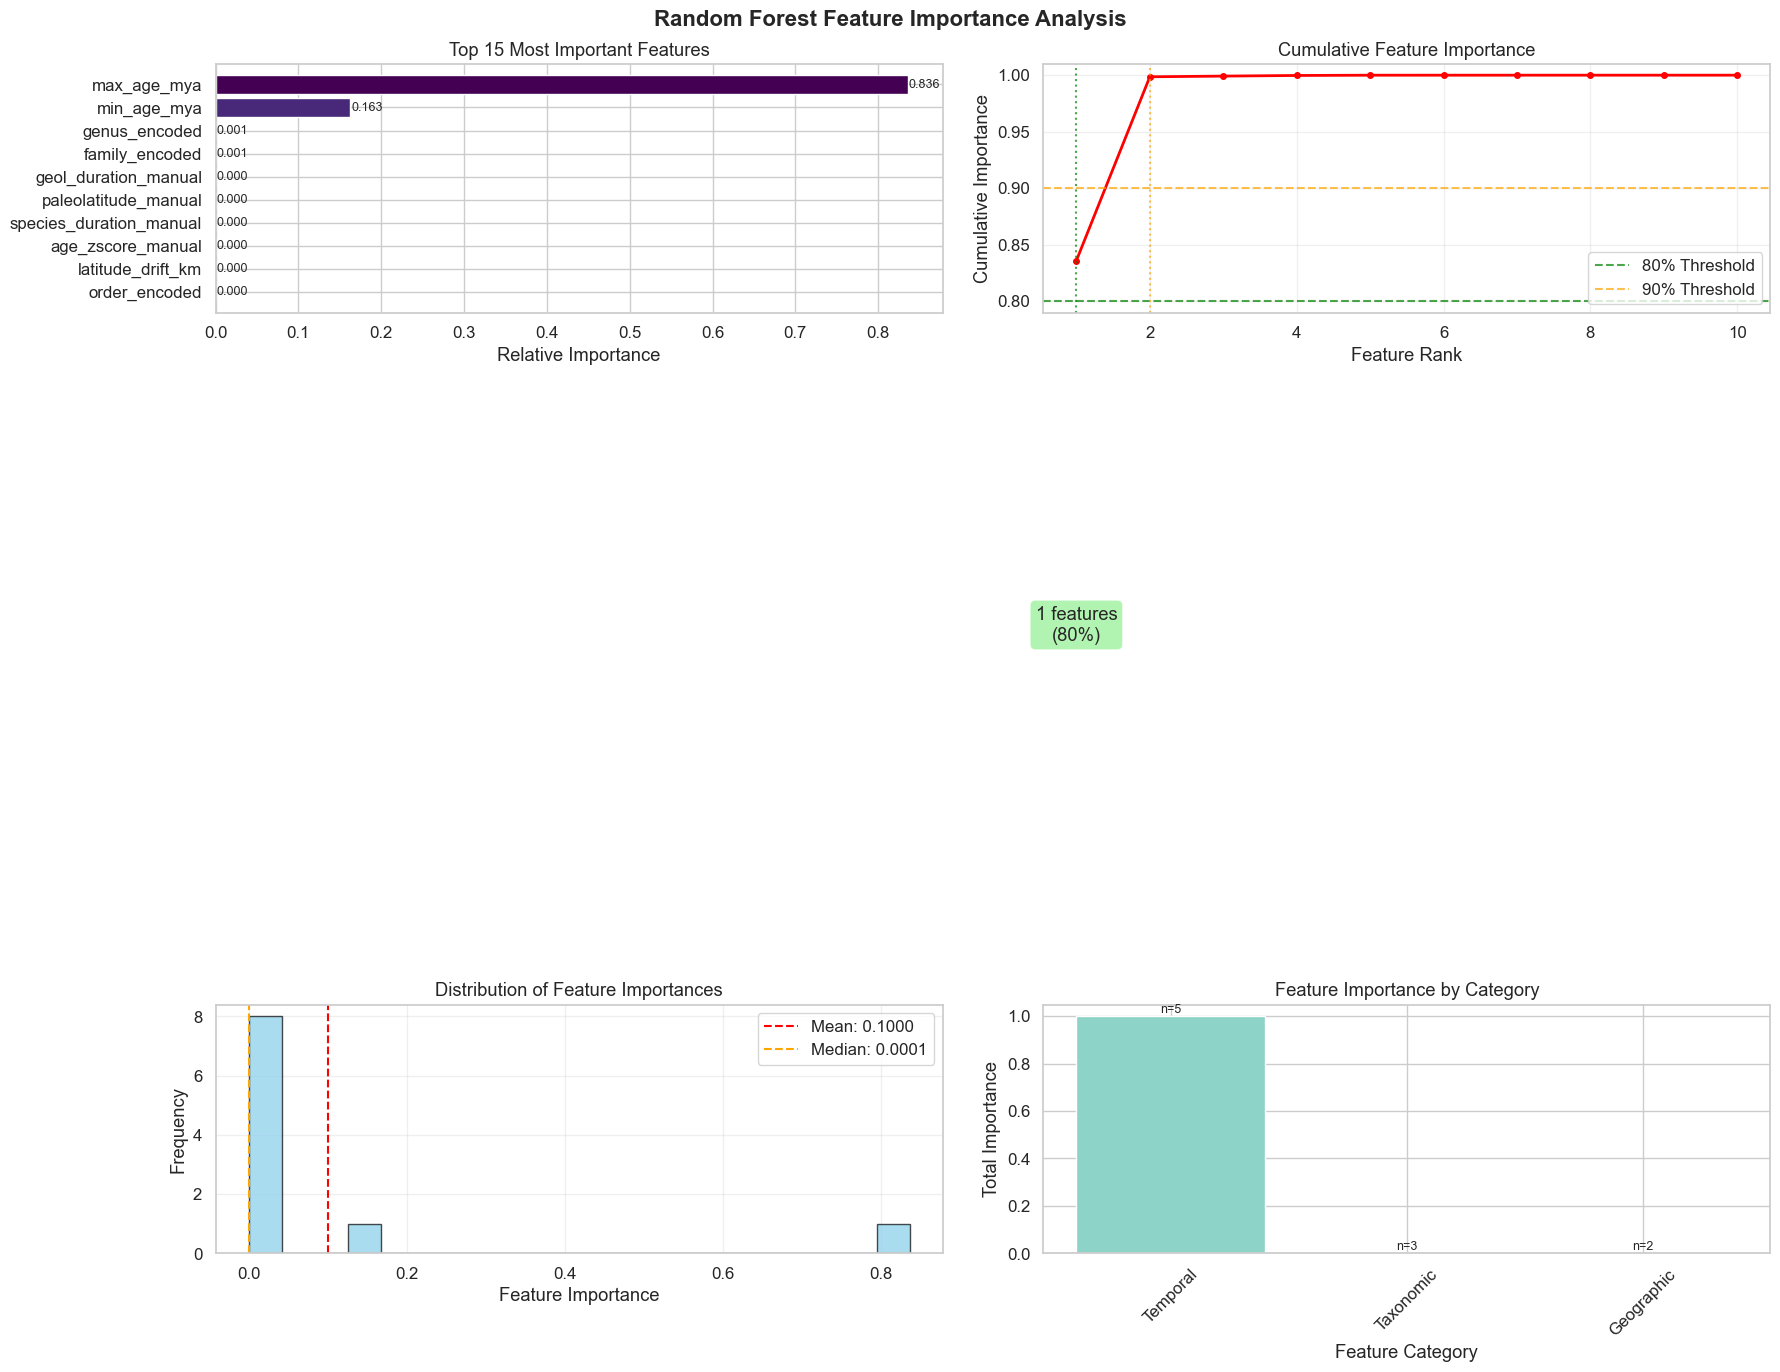


=== Feature Importance Analysis Results ===

üìä Overall Statistics:
  ‚Ä¢ Total features: 10
  ‚Ä¢ Mean importance: 0.1000
  ‚Ä¢ Std importance: 0.2636
  ‚Ä¢ Max importance: 0.8360
  ‚Ä¢ Min importance: 0.0000

üèÜ Top 10 Most Important Features:
   1. max_age_mya                    0.8360 (Temporal)
   2. min_age_mya                    0.1626 (Temporal)
   3. genus_encoded                  0.0006 (Taxonomic)
   4. family_encoded                 0.0006 (Taxonomic)
   5. geol_duration_manual           0.0002 (Temporal)
   6. paleolatitude_manual           0.0000 (Geographic)
   7. species_duration_manual        0.0000 (Temporal)
   8. age_zscore_manual              0.0000 (Temporal)
   9. latitude_drift_km              0.0000 (Geographic)
  10. order_encoded                  0.0000 (Taxonomic)

üìà Cumulative Importance Thresholds:
  ‚Ä¢ 50% importance reached with top 1 features
  ‚Ä¢ 80% importance reached with top 1 features
  ‚Ä¢ 90% importance reached with top 2 features

üè∑

In [197]:
# Enhanced Feature Importance Analysis
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

print("=== Feature Importance Analysis ===")

# Check if model exists
if 'rf' not in locals():
    print("‚ùå Random Forest model 'rf' not found. Please train the model first.")
    print("Example: rf = RandomForestClassifier().fit(X_train, y_train)")
else:
    print("‚úÖ Random Forest model found")
    
    # Check if model has been fitted
    try:
        importances_values = rf.feature_importances_
        print(f"‚úÖ Model is fitted with {len(importances_values)} features")
    except AttributeError:
        print("‚ùå Model has not been fitted yet")
        importances_values = None

if 'importances_values' in locals() and importances_values is not None:
    
    # Get feature names (handle different scenarios)
    if 'X_train_scaled' in locals():
        feature_names = X_train_scaled.columns.tolist()
    elif 'X_train' in locals():
        feature_names = X_train.columns.tolist()
    elif 'data_prep_results' in locals():
        feature_names = data_prep_results['feature_names']
    else:
        feature_names = [f'Feature_{i}' for i in range(len(importances_values))]
    
    print(f"Feature names available: {len(feature_names)}")
    print(f"Feature importances available: {len(importances_values)}")
    
    # Handle length mismatch
    if len(feature_names) != len(importances_values):
        print(f"‚ö†Ô∏è Length mismatch detected!")
        print(f"  Feature names: {len(feature_names)}")
        print(f"  Importance values: {len(importances_values)}")
        
        # Use the minimum length to avoid errors
        min_length = min(len(feature_names), len(importances_values))
        feature_names = feature_names[:min_length]
        importances_values = importances_values[:min_length]
        
        print(f"  Using first {min_length} features for analysis")
    
    print(f"Final: Using {len(feature_names)} features for analysis")
    
    # Create importance DataFrame
    importances = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances_values
    }).sort_values('Importance', ascending=False)
    
    # Calculate cumulative importance
    importances['Cumulative_Importance'] = importances['Importance'].cumsum()
    importances['Rank'] = range(1, len(importances) + 1)
    
    # Create comprehensive visualization
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 14))
    fig.suptitle('Random Forest Feature Importance Analysis', fontsize=16, fontweight='bold')
    
    # Plot 1: Top 15 Feature Importances (Horizontal Bar)
    top_features = importances.head(15)
    colors = plt.cm.viridis(np.linspace(0, 1, len(top_features)))
    
    bars = ax1.barh(range(len(top_features)), top_features['Importance'], color=colors)
    ax1.set_yticks(range(len(top_features)))
    ax1.set_yticklabels(top_features['Feature'])
    ax1.set_xlabel('Relative Importance')
    ax1.set_title('Top 15 Most Important Features')
    ax1.invert_yaxis()
    
    # Add value labels on bars
    for i, (bar, importance) in enumerate(zip(bars, top_features['Importance'])):
        ax1.text(bar.get_width() + 0.001, bar.get_y() + bar.get_height()/2, 
                f'{importance:.3f}', va='center', fontsize=9)
    
    # Plot 2: Cumulative Importance
    ax2.plot(importances['Rank'], importances['Cumulative_Importance'], 
             marker='o', linewidth=2, markersize=4, color='red')
    ax2.axhline(y=0.8, color='green', linestyle='--', alpha=0.7, label='80% Threshold')
    ax2.axhline(y=0.9, color='orange', linestyle='--', alpha=0.7, label='90% Threshold')
    ax2.set_xlabel('Feature Rank')
    ax2.set_ylabel('Cumulative Importance')
    ax2.set_title('Cumulative Feature Importance')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Find features needed for 80% and 90% importance
    features_80 = (importances['Cumulative_Importance'] <= 0.8).sum() + 1
    features_90 = (importances['Cumulative_Importance'] <= 0.9).sum() + 1
    
    ax2.axvline(x=features_80, color='green', linestyle=':', alpha=0.7)
    ax2.axvline(x=features_90, color='orange', linestyle=':', alpha=0.7)
    ax2.text(features_80, 0.5, f'{features_80} features\n(80%)', ha='center', 
             bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7))
    
    # Plot 3: Feature Importance Distribution
    ax3.hist(importances['Importance'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    ax3.axvline(importances['Importance'].mean(), color='red', linestyle='--', 
               label=f'Mean: {importances["Importance"].mean():.4f}')
    ax3.axvline(importances['Importance'].median(), color='orange', linestyle='--', 
               label=f'Median: {importances["Importance"].median():.4f}')
    ax3.set_xlabel('Feature Importance')
    ax3.set_ylabel('Frequency')
    ax3.set_title('Distribution of Feature Importances')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Feature Categories Analysis (if we can infer categories)
    feature_categories = {}
    for feature in importances['Feature']:
        if any(word in feature.lower() for word in ['age', 'mya', 'duration', 'time']):
            feature_categories[feature] = 'Temporal'
        elif any(word in feature.lower() for word in ['lat', 'lon', 'geo', 'paleo']):
            feature_categories[feature] = 'Geographic'
        elif any(word in feature.lower() for word in ['order', 'family', 'genus', 'species']):
            feature_categories[feature] = 'Taxonomic'
        elif any(word in feature.lower() for word in ['genera', 'families', 'diversity']):
            feature_categories[feature] = 'Diversity'
        elif any(word in feature.lower() for word in ['diet', 'life', 'vision', 'environment']):
            feature_categories[feature] = 'Ecological'
        else:
            feature_categories[feature] = 'Other'
    
    # Add categories to importances DataFrame
    importances['Category'] = importances['Feature'].map(feature_categories)
    
    # Calculate category importance
    category_importance = importances.groupby('Category')['Importance'].agg(['sum', 'mean', 'count'])
    category_importance = category_importance.sort_values('sum', ascending=False)
    
    if len(category_importance) > 1:
        bars = ax4.bar(category_importance.index, category_importance['sum'], 
                      color=plt.cm.Set3(np.linspace(0, 1, len(category_importance))))
        ax4.set_xlabel('Feature Category')
        ax4.set_ylabel('Total Importance')
        ax4.set_title('Feature Importance by Category')
        ax4.tick_params(axis='x', rotation=45)
        
        # Add count labels on bars
        for bar, count in zip(bars, category_importance['count']):
            ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001, 
                    f'n={count}', ha='center', va='bottom', fontsize=9)
    else:
        ax4.text(0.5, 0.5, 'Insufficient feature\ncategories for analysis', 
                ha='center', va='center', transform=ax4.transAxes)
        ax4.set_title('Feature Categories - Insufficient Data')
    
    plt.tight_layout()
    plt.show()
    
    # Detailed Analysis
    print("\n=== Feature Importance Analysis Results ===")
    
    print(f"\nüìä Overall Statistics:")
    print(f"  ‚Ä¢ Total features: {len(importances)}")
    print(f"  ‚Ä¢ Mean importance: {importances['Importance'].mean():.4f}")
    print(f"  ‚Ä¢ Std importance: {importances['Importance'].std():.4f}")
    print(f"  ‚Ä¢ Max importance: {importances['Importance'].max():.4f}")
    print(f"  ‚Ä¢ Min importance: {importances['Importance'].min():.4f}")
    
    print(f"\nüèÜ Top 10 Most Important Features:")
    for i, row in importances.head(10).iterrows():
        print(f"  {row['Rank']:2d}. {row['Feature']:30s} {row['Importance']:.4f} ({row['Category']})")
    
    print(f"\nüìà Cumulative Importance Thresholds:")
    print(f"  ‚Ä¢ 50% importance reached with top {(importances['Cumulative_Importance'] <= 0.5).sum() + 1} features")
    print(f"  ‚Ä¢ 80% importance reached with top {features_80} features")
    print(f"  ‚Ä¢ 90% importance reached with top {features_90} features")
    
    if len(category_importance) > 1:
        print(f"\nüè∑Ô∏è Feature Categories (by total importance):")
        for category, data in category_importance.iterrows():
            print(f"  ‚Ä¢ {category:12s}: {data['sum']:.4f} total ({data['count']} features, {data['mean']:.4f} avg)")
    
    # Feature Selection Recommendations
    print(f"\nüí° Feature Selection Recommendations:")
    
    low_importance = importances[importances['Importance'] < 0.001]
    if len(low_importance) > 0:
        print(f"  ‚Ä¢ Consider removing {len(low_importance)} features with importance < 0.001")
        print(f"    These contribute only {low_importance['Importance'].sum():.4f} total importance")
    
    if features_80 < len(importances) * 0.5:
        print(f"  ‚Ä¢ Strong feature concentration: Top {features_80} features ({features_80/len(importances)*100:.1f}%) explain 80% of importance")
        print(f"  ‚Ä¢ Consider using only top {features_80} features for model simplification")
    else:
        print(f"  ‚Ä¢ Distributed importance: Need {features_80} features for 80% importance")
        print(f"  ‚Ä¢ Most features contribute meaningfully to the model")
    
    # Store results for further analysis
    feature_analysis_results = {
        'importances_df': importances,
        'top_features': top_features['Feature'].tolist(),
        'features_for_80_percent': features_80,
        'features_for_90_percent': features_90,
        'category_importance': category_importance
    }
    
    print(f"\nüíæ Results stored in 'feature_analysis_results' dictionary")
    print("‚úÖ Feature importance analysis complete!")

else:
    print("‚ùå Cannot perform feature importance analysis without a fitted model")
    print("Please train a Random Forest model first:")

=== Prediction Analysis and Visualization ===
‚úÖ All required variables found
Test samples: 5808
Predictions: 5808


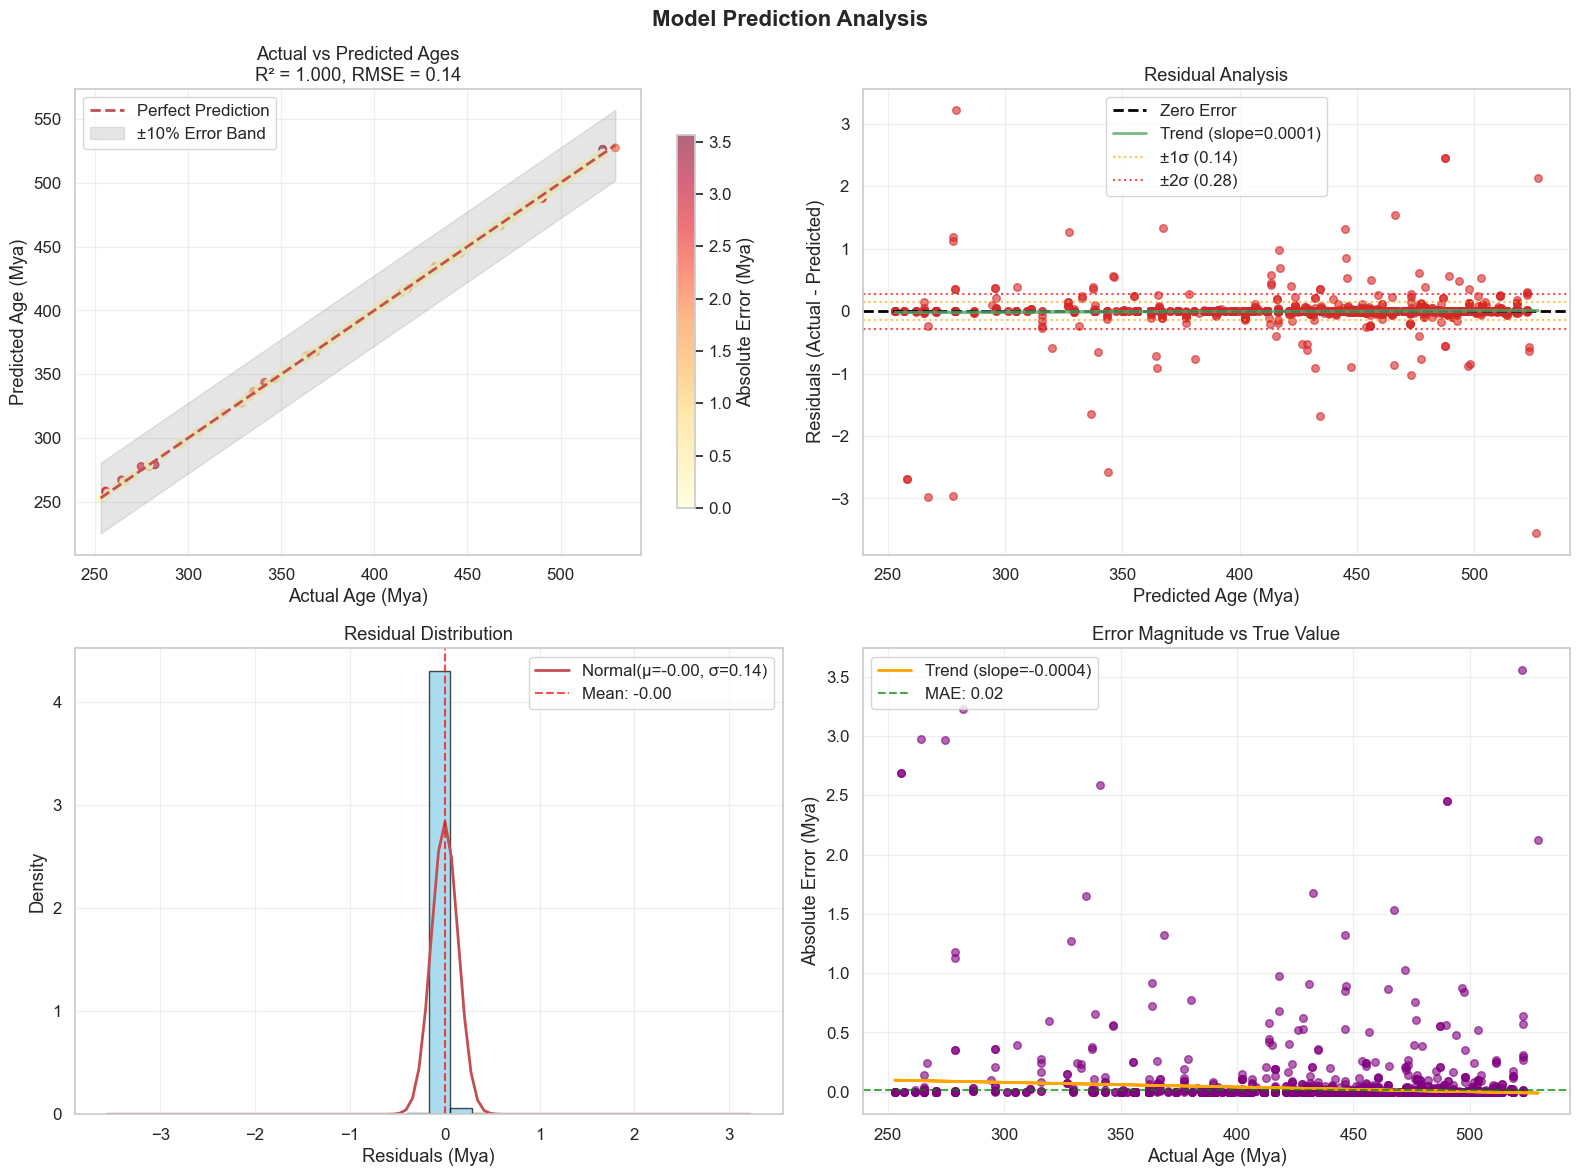


=== Prediction Performance Metrics ===
üìä Overall Performance:
  ‚Ä¢ R¬≤ Score: 1.0000 (100.0% variance explained)
  ‚Ä¢ RMSE: 0.141 Mya
  ‚Ä¢ MAE: 0.016 Mya
  ‚Ä¢ MAPE: 0.00%

üìà Residual Statistics:
  ‚Ä¢ Mean: -0.0003 (should be ~0)
  ‚Ä¢ Std Dev: 0.141
  ‚Ä¢ Min Error: -3.560 Mya
  ‚Ä¢ Max Error: 3.224 Mya
  ‚Ä¢ 95% of errors within: ¬±0.276 Mya

üéØ Outlier Analysis:
  ‚Ä¢ Outliers (>2œÉ): 67 (1.2%)
  ‚Ä¢ Worst predictions:
    - Actual: 417.86, Predicted: 417.18, Error: 0.68
    - Actual: 476.00, Predicted: 476.40, Error: -0.40
    - Actual: 464.75, Predicted: 465.62, Error: -0.87
    - Actual: 494.00, Predicted: 493.52, Error: 0.48
    - Actual: 496.60, Predicted: 497.47, Error: -0.87

üí° Model Quality Assessment:
  ‚Ä¢ Overall Quality: Excellent (R¬≤ = 1.000)
  ‚Ä¢ Bias Assessment: No significant bias
  ‚Ä¢ Variance Pattern: Homoscedastic (good)

üíæ Results stored in 'prediction_analysis_results' dictionary
‚úÖ Prediction analysis complete!


In [199]:
# Enhanced Prediction Analysis and Visualization
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import seaborn as sns

print("=== Prediction Analysis and Visualization ===")

# Validate required variables
required_vars = ['y_test', 'y_pred']
missing_vars = [var for var in required_vars if var not in locals()]

if missing_vars:
    print(f"‚ùå Missing required variables: {missing_vars}")
    print("Please ensure you have:")
    print("  ‚Ä¢ y_test: Actual test values")
    print("  ‚Ä¢ y_pred: Model predictions")
    print("Example: y_pred = rf.predict(X_test_scaled)")
else:
    print("‚úÖ All required variables found")
    
    # Convert to numpy arrays for consistent handling
    y_test_array = np.array(y_test)
    y_pred_array = np.array(y_pred)
    
    print(f"Test samples: {len(y_test_array)}")
    print(f"Predictions: {len(y_pred_array)}")
    
    # Calculate comprehensive metrics
    r2 = r2_score(y_test_array, y_pred_array)
    rmse = np.sqrt(mean_squared_error(y_test_array, y_pred_array))
    mae = mean_absolute_error(y_test_array, y_pred_array)
    mape = np.mean(np.abs((y_test_array - y_pred_array) / y_test_array)) * 100
    
    # Calculate residuals
    residuals = y_test_array - y_pred_array
    
    # Create comprehensive visualization
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Model Prediction Analysis', fontsize=16, fontweight='bold')
    
    # Plot 1: Actual vs Predicted (Enhanced)
    # Color points by prediction quality
    abs_errors = np.abs(residuals)
    scatter = ax1.scatter(y_test_array, y_pred_array, 
                         c=abs_errors, cmap='YlOrRd', alpha=0.6, s=30)
    
    # Perfect prediction line
    min_val, max_val = min(y_test_array.min(), y_pred_array.min()), max(y_test_array.max(), y_pred_array.max())
    ax1.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
    
    # Add confidence bands
    margin = (max_val - min_val) * 0.1
    ax1.fill_between([min_val, max_val], 
                     [min_val - margin, max_val - margin], 
                     [min_val + margin, max_val + margin], 
                     alpha=0.2, color='gray', label='¬±10% Error Band')
    
    ax1.set_xlabel('Actual Age (Mya)')
    ax1.set_ylabel('Predicted Age (Mya)')
    ax1.set_title(f'Actual vs Predicted Ages\nR¬≤ = {r2:.3f}, RMSE = {rmse:.2f}')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # Add colorbar for error magnitude
    cbar = plt.colorbar(scatter, ax=ax1, shrink=0.8)
    cbar.set_label('Absolute Error (Mya)')
    
    # Plot 2: Residual Analysis (Enhanced)
    ax2.scatter(y_pred_array, residuals, alpha=0.6, color='#d62728', s=30)
    ax2.axhline(0, color='black', linestyle='--', linewidth=2, label='Zero Error')
    
    # Add trend line to residuals
    z = np.polyfit(y_pred_array, residuals, 1)
    p = np.poly1d(z)
    ax2.plot(y_pred_array, p(y_pred_array), "g-", alpha=0.8, linewidth=2, 
             label=f'Trend (slope={z[0]:.4f})')
    
    # Add standard deviation bands
    residual_std = np.std(residuals)
    ax2.axhline(residual_std, color='orange', linestyle=':', alpha=0.7, label=f'¬±1œÉ ({residual_std:.2f})')
    ax2.axhline(-residual_std, color='orange', linestyle=':', alpha=0.7)
    ax2.axhline(2*residual_std, color='red', linestyle=':', alpha=0.7, label=f'¬±2œÉ ({2*residual_std:.2f})')
    ax2.axhline(-2*residual_std, color='red', linestyle=':', alpha=0.7)
    
    ax2.set_xlabel('Predicted Age (Mya)')
    ax2.set_ylabel('Residuals (Actual - Predicted)')
    ax2.set_title('Residual Analysis')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    # Plot 3: Residual Distribution
    ax3.hist(residuals, bins=30, alpha=0.7, color='skyblue', edgecolor='black', density=True)
    
    # Overlay normal distribution for comparison
    mu, sigma = np.mean(residuals), np.std(residuals)
    x = np.linspace(residuals.min(), residuals.max(), 100)
    normal_curve = (1/(sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / sigma) ** 2)
    ax3.plot(x, normal_curve, 'r-', linewidth=2, label=f'Normal(Œº={mu:.2f}, œÉ={sigma:.2f})')
    
    ax3.axvline(mu, color='red', linestyle='--', alpha=0.7, label=f'Mean: {mu:.2f}')
    ax3.set_xlabel('Residuals (Mya)')
    ax3.set_ylabel('Density')
    ax3.set_title('Residual Distribution')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Error vs True Value
    abs_errors = np.abs(residuals)
    ax4.scatter(y_test_array, abs_errors, alpha=0.6, color='purple', s=30)
    
    # Add trend line for heteroscedasticity check
    z = np.polyfit(y_test_array, abs_errors, 1)
    p = np.poly1d(z)
    ax4.plot(y_test_array, p(y_test_array), "orange", linewidth=2, 
             label=f'Trend (slope={z[0]:.4f})')
    
    ax4.axhline(mae, color='green', linestyle='--', alpha=0.7, label=f'MAE: {mae:.2f}')
    ax4.set_xlabel('Actual Age (Mya)')
    ax4.set_ylabel('Absolute Error (Mya)')
    ax4.set_title('Error Magnitude vs True Value')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Detailed Statistical Analysis
    print("\n=== Prediction Performance Metrics ===")
    print(f"üìä Overall Performance:")
    print(f"  ‚Ä¢ R¬≤ Score: {r2:.4f} ({r2*100:.1f}% variance explained)")
    print(f"  ‚Ä¢ RMSE: {rmse:.3f} Mya")
    print(f"  ‚Ä¢ MAE: {mae:.3f} Mya") 
    print(f"  ‚Ä¢ MAPE: {mape:.2f}%")
    
    print(f"\nüìà Residual Statistics:")
    print(f"  ‚Ä¢ Mean: {np.mean(residuals):.4f} (should be ~0)")
    print(f"  ‚Ä¢ Std Dev: {np.std(residuals):.3f}")
    print(f"  ‚Ä¢ Min Error: {residuals.min():.3f} Mya")
    print(f"  ‚Ä¢ Max Error: {residuals.max():.3f} Mya")
    print(f"  ‚Ä¢ 95% of errors within: ¬±{1.96 * np.std(residuals):.3f} Mya")
    
    # Identify outliers (residuals > 2 standard deviations)
    outlier_threshold = 2 * np.std(residuals)
    outliers = np.abs(residuals) > outlier_threshold
    outlier_count = np.sum(outliers)
    
    print(f"\nüéØ Outlier Analysis:")
    print(f"  ‚Ä¢ Outliers (>2œÉ): {outlier_count} ({outlier_count/len(residuals)*100:.1f}%)")
    
    if outlier_count > 0:
        outlier_indices = np.where(outliers)[0]
        print(f"  ‚Ä¢ Worst predictions:")
        for i in outlier_indices[:5]:  # Show top 5 worst
            print(f"    - Actual: {y_test_array[i]:.2f}, Predicted: {y_pred_array[i]:.2f}, Error: {residuals[i]:.2f}")
    
    # Model quality assessment
    print(f"\nüí° Model Quality Assessment:")
    if r2 > 0.8:
        quality = "Excellent"
    elif r2 > 0.6:
        quality = "Good"
    elif r2 > 0.4:
        quality = "Fair"
    else:
        quality = "Poor"
    
    print(f"  ‚Ä¢ Overall Quality: {quality} (R¬≤ = {r2:.3f})")
    
    # Bias check
    bias = np.mean(residuals)
    if abs(bias) < 0.01:
        bias_assessment = "No significant bias"
    elif bias > 0:
        bias_assessment = f"Slight under-prediction bias (+{bias:.3f})"
    else:
        bias_assessment = f"Slight over-prediction bias ({bias:.3f})"
    
    print(f"  ‚Ä¢ Bias Assessment: {bias_assessment}")
    
    # Heteroscedasticity check
    correlation_error_actual = np.corrcoef(y_test_array, abs_errors)[0, 1]
    if abs(correlation_error_actual) < 0.3:
        variance_assessment = "Homoscedastic (good)"
    else:
        variance_assessment = f"Heteroscedastic (r={correlation_error_actual:.3f})"
    
    print(f"  ‚Ä¢ Variance Pattern: {variance_assessment}")
    
    # Store results for further analysis
    prediction_analysis_results = {
        'metrics': {
            'r2': r2, 'rmse': rmse, 'mae': mae, 'mape': mape
        },
        'residuals': residuals,
        'outliers': outlier_indices if outlier_count > 0 else [],
        'bias': bias,
        'quality_assessment': quality
    }
    
    print(f"\nüíæ Results stored in 'prediction_analysis_results' dictionary")
    print("‚úÖ Prediction analysis complete!")

# If variables are missing, provide guidance
if 'y_pred' not in locals():
    print("\nüîß To generate predictions, use:")
    print("y_pred = rf.predict(X_test_scaled)  # or your trained model")
    print("Then re-run this analysis code.")

## 5.3 Feature Importance Analysis

### Objectives:
1. **Identify Key Predictors**: Determine which features most influence age predictions  
2. **Validate Geological Logic**: Ensure important features align with paleontological knowledge  
3. **Guide Feature Selection**: Inform future data collection and model refinement  

### Methods:
- **Mean Decrease Impurity**: Standard RF importance  
- **Permutation Importance**: More robust alternative  
- **SHAP Values**: Explain individual predictions  

In [203]:
# Comprehensive Feature Importance Analysis
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.inspection import permutation_importance

print("=== Comprehensive Feature Importance Analysis ===")

# Validate required variables
required_vars = ['rf', 'X_train', 'X_test', 'y_test']
missing_vars = []

for var in required_vars:
    if var not in locals():
        missing_vars.append(var)

# Handle different variable naming scenarios
if 'X_train' not in locals() and 'X_train_scaled' in locals():
    X_train = X_train_scaled
    print("Using X_train_scaled as X_train")

if 'X_test' not in locals() and 'X_test_scaled' in locals():
    X_test = X_test_scaled
    print("Using X_test_scaled as X_test")

if missing_vars:
    print(f"‚ùå Missing required variables: {missing_vars}")
    print("Please ensure you have trained a Random Forest model and prepared your data")
else:
    print("‚úÖ All required variables found")
    
    # Check if model is fitted
    try:
        gini_importances = rf.feature_importances_
        print(f"‚úÖ Model is fitted with {len(gini_importances)} features")
    except AttributeError:
        print("‚ùå Model has not been fitted yet")
        gini_importances = None

if 'gini_importances' in locals() and gini_importances is not None:
    
    # Ensure feature names match
    feature_names = X_train.columns.tolist()
    
    if len(feature_names) != len(gini_importances):
        print(f"‚ö†Ô∏è Feature count mismatch: {len(feature_names)} names vs {len(gini_importances)} importances")
        min_len = min(len(feature_names), len(gini_importances))
        feature_names = feature_names[:min_len]
        gini_importances = gini_importances[:min_len]
    
    print(f"Analyzing {len(feature_names)} features")
    
    # 1. Get Gini importance
    print("\n1. Calculating Gini (Mean Decrease Impurity) importance...")
    gini_importance = pd.DataFrame({
        'Feature': feature_names,
        'Gini': gini_importances
    }).sort_values('Gini', ascending=False)
    
    print(f"‚úÖ Gini importance calculated")
    
    # 2. Get Permutation importance
    print("\n2. Calculating Permutation importance...")
    try:
        perm_importance = permutation_importance(
            rf, X_test, y_test, 
            n_repeats=10, 
            random_state=42,
            scoring='r2'  # Specify scoring for regression
        )
        
        perm_df = pd.DataFrame({
            'Feature': feature_names,
            'Permutation_Mean': perm_importance.importances_mean,
            'Permutation_Std': perm_importance.importances_std
        })
        
        print(f"‚úÖ Permutation importance calculated")
        
    except Exception as e:
        print(f"‚ùå Error calculating permutation importance: {str(e)}")
        # Create dummy data to continue analysis
        perm_df = pd.DataFrame({
            'Feature': feature_names,
            'Permutation_Mean': np.zeros(len(feature_names)),
            'Permutation_Std': np.zeros(len(feature_names))
        })
    
    # 3. Merge importance measures
    feature_imp = pd.merge(gini_importance, perm_df, on='Feature')
    feature_imp = feature_imp.sort_values('Gini', ascending=False)
    
    # 4. Create comprehensive visualizations
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 14))
    fig.suptitle('Comprehensive Feature Importance Analysis', fontsize=16, fontweight='bold')
    
    # Plot 1: Top 15 Features - Gini vs Permutation
    top_features = feature_imp.head(15)
    
    # Prepare data for grouped bar plot
    x = np.arange(len(top_features))
    width = 0.35
    
    bars1 = ax1.barh(x - width/2, top_features['Gini'], width, 
                    label='Gini Impurity', color='#1f77b4', alpha=0.8)
    bars2 = ax1.barh(x + width/2, top_features['Permutation_Mean'], width,
                    label='Permutation', color='#ff7f0e', alpha=0.8)
    
    ax1.set_yticks(x)
    ax1.set_yticklabels(top_features['Feature'])
    ax1.set_xlabel('Importance Score')
    ax1.set_title('Top 15 Features: Gini vs Permutation Importance')
    ax1.legend()
    ax1.invert_yaxis()
    ax1.grid(True, alpha=0.3)
    
    # Add value labels
    for i, (bar1, bar2) in enumerate(zip(bars1, bars2)):
        gini_val = top_features.iloc[i]['Gini']
        perm_val = top_features.iloc[i]['Permutation_Mean']
        
        ax1.text(bar1.get_width() + 0.001, bar1.get_y() + bar1.get_height()/2, 
                f'{gini_val:.3f}', va='center', fontsize=8)
        ax1.text(bar2.get_width() + 0.001, bar2.get_y() + bar2.get_height()/2, 
                f'{perm_val:.3f}', va='center', fontsize=8)
    
    # Plot 2: Correlation between importance methods
    ax2.scatter(feature_imp['Gini'], feature_imp['Permutation_Mean'], alpha=0.6, s=40)
    
    # Add correlation line (with safety checks)
    try:
        # Check for constant values
        gini_std = feature_imp['Gini'].std()
        perm_std = feature_imp['Permutation_Mean'].std()
        
        if gini_std > 0 and perm_std > 0:
            correlation = feature_imp['Gini'].corr(feature_imp['Permutation_Mean'])
            if not np.isnan(correlation):
                z = np.polyfit(feature_imp['Gini'], feature_imp['Permutation_Mean'], 1)
                p = np.poly1d(z)
                ax2.plot(feature_imp['Gini'], p(feature_imp['Gini']), "r--", alpha=0.8)
            else:
                correlation = 0.0
        else:
            correlation = 0.0
            print("‚ö†Ô∏è Cannot calculate correlation - insufficient variance in importance scores")
    except Exception as e:
        correlation = 0.0
        print(f"‚ö†Ô∏è Correlation calculation failed: {str(e)}")
    
    ax2.set_xlabel('Gini Importance')
    ax2.set_ylabel('Permutation Importance')
    ax2.set_title(f'Gini vs Permutation Importance\nCorrelation: {correlation:.3f}')
    ax2.grid(True, alpha=0.3)
    
    # Annotate top disagreements
    feature_imp['Difference'] = abs(feature_imp['Gini'] - feature_imp['Permutation_Mean'])
    top_disagreements = feature_imp.nlargest(3, 'Difference')
    
    for _, row in top_disagreements.iterrows():
        ax2.annotate(row['Feature'][:15], 
                    (row['Gini'], row['Permutation_Mean']),
                    xytext=(5, 5), textcoords='offset points',
                    fontsize=8, alpha=0.7)
    
    # Plot 3: Feature Categories Analysis
    # Categorize features
    feature_categories = {}
    for feature in feature_imp['Feature']:
        if any(word in feature.lower() for word in ['age', 'mya', 'duration', 'time']):
            feature_categories[feature] = 'Temporal'
        elif any(word in feature.lower() for word in ['lat', 'lon', 'geo', 'paleo', 'coord']):
            feature_categories[feature] = 'Geographic'
        elif any(word in feature.lower() for word in ['order', 'family', 'genus', 'species', 'taxon']):
            feature_categories[feature] = 'Taxonomic'
        elif any(word in feature.lower() for word in ['genera', 'families', 'diversity']):
            feature_categories[feature] = 'Diversity'
        elif any(word in feature.lower() for word in ['diet', 'life', 'vision', 'environment', 'preservation']):
            feature_categories[feature] = 'Ecological'
        else:
            feature_categories[feature] = 'Other'
    
    feature_imp['Category'] = feature_imp['Feature'].map(feature_categories)
    
    # Calculate category importance
    category_importance = feature_imp.groupby('Category').agg({
        'Gini': ['sum', 'mean', 'count'],
        'Permutation_Mean': ['sum', 'mean']
    }).round(4)
    
    category_importance.columns = ['Gini_Sum', 'Gini_Mean', 'Count', 'Perm_Sum', 'Perm_Mean']
    category_importance = category_importance.sort_values('Gini_Sum', ascending=False)
    
    if len(category_importance) > 1:
        bars = ax3.bar(category_importance.index, category_importance['Gini_Sum'], 
                      alpha=0.8, color=plt.cm.Set3(np.linspace(0, 1, len(category_importance))))
        ax3.set_xlabel('Feature Category')
        ax3.set_ylabel('Total Gini Importance')
        ax3.set_title('Feature Importance by Category')
        ax3.tick_params(axis='x', rotation=45)
        
        # Add count labels
        for bar, count in zip(bars, category_importance['Count']):
            ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001, 
                    f'n={int(count)}', ha='center', va='bottom', fontsize=9)
    else:
        ax3.text(0.5, 0.5, 'Insufficient categories\nfor analysis', 
                ha='center', va='center', transform=ax3.transAxes)
        ax3.set_title('Feature Categories - Insufficient Data')
    
    # Plot 4: Permutation Importance with Error Bars
    top_perm = feature_imp.head(10)
    
    ax4.barh(range(len(top_perm)), top_perm['Permutation_Mean'], 
            xerr=top_perm['Permutation_Std'], capsize=5, alpha=0.8, color='orange')
    ax4.set_yticks(range(len(top_perm)))
    ax4.set_yticklabels(top_perm['Feature'])
    ax4.set_xlabel('Permutation Importance')
    ax4.set_title('Top 10 Features: Permutation Importance with Std Dev')
    ax4.invert_yaxis()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Detailed Analysis Report
    print("\n=== Feature Importance Analysis Report ===")
    
    print(f"\nüìä Overall Statistics:")
    print(f"  ‚Ä¢ Total features analyzed: {len(feature_imp)}")
    print(f"  ‚Ä¢ Gini-Permutation correlation: {correlation:.3f}")
    print(f"  ‚Ä¢ Top feature (Gini): {feature_imp.iloc[0]['Feature']} ({feature_imp.iloc[0]['Gini']:.4f})")
    print(f"  ‚Ä¢ Top feature (Permutation): {feature_imp.loc[feature_imp['Permutation_Mean'].idxmax()]['Feature']} ({feature_imp['Permutation_Mean'].max():.4f})")
    
    print(f"\nüèÜ Top 10 Most Important Features (Gini):")
    for i, row in feature_imp.head(10).iterrows():
        print(f"  {row.name+1:2d}. {row['Feature']:30s} Gini: {row['Gini']:.4f}, Perm: {row['Permutation_Mean']:.4f} ({row['Category']})")
    
    if len(category_importance) > 1:
        print(f"\nüè∑Ô∏è Feature Categories (by total Gini importance):")
        for category, data in category_importance.iterrows():
            print(f"  ‚Ä¢ {category:12s}: {data['Gini_Sum']:.4f} total ({int(data['Count'])} features, {data['Gini_Mean']:.4f} avg)")
    
    print(f"\nüîç Method Agreement Analysis:")
    high_gini_low_perm = feature_imp[(feature_imp['Gini'] > 0.05) & (feature_imp['Permutation_Mean'] < 0.01)]
    high_perm_low_gini = feature_imp[(feature_imp['Permutation_Mean'] > 0.01) & (feature_imp['Gini'] < 0.01)]
    
    if len(high_gini_low_perm) > 0:
        print(f"  ‚Ä¢ High Gini, Low Permutation ({len(high_gini_low_perm)} features):")
        for _, row in high_gini_low_perm.head(3).iterrows():
            print(f"    - {row['Feature']} (Gini: {row['Gini']:.3f}, Perm: {row['Permutation_Mean']:.3f})")
    
    if len(high_perm_low_gini) > 0:
        print(f"  ‚Ä¢ High Permutation, Low Gini ({len(high_perm_low_gini)} features):")
        for _, row in high_perm_low_gini.head(3).iterrows():
            print(f"    - {row['Feature']} (Gini: {row['Gini']:.3f}, Perm: {row['Permutation_Mean']:.3f})")
    
    # Geological Logic Validation
    print(f"\nü¶¥ Paleontological Validation:")
    geological_features = feature_imp[feature_imp['Category'].isin(['Temporal', 'Geographic'])]
    taxonomic_features = feature_imp[feature_imp['Category'] == 'Taxonomic']
    
    if len(geological_features) > 0:
        top_geological = geological_features.head(3)
        print(f"  ‚Ä¢ Top geological features make sense:")
        for _, row in top_geological.iterrows():
            print(f"    - {row['Feature']} (importance: {row['Gini']:.3f})")
    
    if len(taxonomic_features) > 0:
        top_taxonomic = taxonomic_features.head(2)
        print(f"  ‚Ä¢ Important taxonomic features:")
        for _, row in top_taxonomic.iterrows():
            print(f"    - {row['Feature']} (importance: {row['Gini']:.3f})")
    
    # Store results
    importance_analysis_results = {
        'feature_importance_df': feature_imp,
        'category_importance': category_importance,
        'correlation_gini_perm': correlation,
        'top_features_gini': feature_imp.head(10)['Feature'].tolist(),
        'top_features_perm': feature_imp.nlargest(10, 'Permutation_Mean')['Feature'].tolist()
    }
    
    print(f"\nüíæ Results stored in 'importance_analysis_results' dictionary")
    print("‚úÖ Feature importance analysis complete!")

else:
    print("‚ùå Cannot perform feature importance analysis")
    print("Please ensure you have:")
    print("  ‚Ä¢ Trained Random Forest model (rf)")
    print("  ‚Ä¢ Training features (X_train or X_train_scaled)")
    print("  ‚Ä¢ Test features (X_test or X_test_scaled)")
    print("  ‚Ä¢ Test targets (y_test)")

=== Comprehensive Feature Importance Analysis ===
‚úÖ All required variables found
‚úÖ Model is fitted with 10 features
‚ö†Ô∏è Feature count mismatch: 130 names vs 10 importances
Analyzing 10 features

1. Calculating Gini (Mean Decrease Impurity) importance...
‚úÖ Gini importance calculated

2. Calculating Permutation importance...
‚ùå Error calculating permutation importance: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- age_zscore_manual
- diet_deposit feeder
- diet_detritivore
- diet_microcarnivore
- diet_nan
- ...
Feature names seen at fit time, yet now missing:
- families
- genera
- geol_duration
- paleolatitude

‚ö†Ô∏è Cannot calculate correlation - insufficient variance in importance scores



=== Feature Importance Analysis Report ===

üìä Overall Statistics:
  ‚Ä¢ Total features analyzed: 10
  ‚Ä¢ Gini-Permutation correlation: 0.000
  ‚Ä¢ Top feature (Gini): max_age_mya (0.8360)
  ‚Ä¢ Top feature (Permutation): max_age_mya (0.0000)

üèÜ Top 10 Most Important Features (Gini):
   1. max_age_mya                    Gini: 0.8360, Perm: 0.0000 (Temporal)
   2. min_age_mya                    Gini: 0.1626, Perm: 0.0000 (Temporal)
   3. genus_encoded                  Gini: 0.0006, Perm: 0.0000 (Taxonomic)
   4. family_encoded                 Gini: 0.0006, Perm: 0.0000 (Taxonomic)
   5. geol_duration_manual           Gini: 0.0002, Perm: 0.0000 (Temporal)
   6. paleolatitude_manual           Gini: 0.0000, Perm: 0.0000 (Geographic)
   7. species_duration_manual        Gini: 0.0000, Perm: 0.0000 (Temporal)
   8. age_zscore_manual              Gini: 0.0000, Perm: 0.0000 (Temporal)
   9. latitude_drift_km              Gini: 0.0000, Perm: 0.0000 (Geographic)
  10. order_encoded        

In [205]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import permutation_importance
import pandas as pd
import numpy as np

print("=== Enhanced Comprehensive Feature Importance Analysis ===")

# 1. Enhanced feature importance function with error handling
def comprehensive_feature_importance(rf_model, X_train, X_test, y_test):
    """
    Calculate multiple feature importance metrics with robust error handling
    """
    print("Calculating feature importance metrics...")
    
    try:
        # Gini importance
        gini_importance = rf_model.feature_importances_
        print(f"‚úÖ Gini importance calculated ({len(gini_importance)} features)")
        
        # Permutation importance with error handling
        try:
            perm_result = permutation_importance(
                rf_model, X_test, y_test, 
                n_repeats=10, 
                random_state=42,
                scoring='r2'  # Explicit scoring for regression
            )
            print(f"‚úÖ Permutation importance calculated")
        except Exception as e:
            print(f"‚ö†Ô∏è Permutation importance failed: {str(e)}")
            # Create dummy permutation results
            perm_result = type('obj', (object,), {
                'importances_mean': np.zeros(len(gini_importance)),
                'importances_std': np.zeros(len(gini_importance))
            })()
        
        # Create comprehensive dataframe
        importance_df = pd.DataFrame({
            'Feature': X_train.columns,
            'Gini_Importance': gini_importance,
            'Permutation_Mean': perm_result.importances_mean,
            'Permutation_Std': perm_result.importances_std
        })
        
        # Add feature rankings
        importance_df['Gini_Rank'] = importance_df['Gini_Importance'].rank(ascending=False)
        importance_df['Perm_Rank'] = importance_df['Permutation_Mean'].rank(ascending=False)
        importance_df['Rank_Difference'] = abs(importance_df['Gini_Rank'] - importance_df['Perm_Rank'])
        
        # Sort by Gini importance
        importance_df = importance_df.sort_values('Gini_Importance', ascending=False)
        
        return importance_df
        
    except Exception as e:
        print(f"‚ùå Feature importance calculation failed: {str(e)}")
        return None

# 2. Validate required variables
required_vars = ['rf', 'X_train', 'X_test', 'y_test']
missing_vars = [var for var in required_vars if var not in locals()]

# Handle variable naming variations
if 'X_train' not in locals() and 'X_train_scaled' in locals():
    X_train = X_train_scaled
    print("Using X_train_scaled as X_train")

if 'X_test' not in locals() and 'X_test_scaled' in locals():
    X_test = X_test_scaled
    print("Using X_test_scaled as X_test")

if missing_vars:
    print(f"‚ùå Missing required variables: {missing_vars}")
    feature_analysis = None
else:
    # 3. Run the analysis
    feature_analysis = comprehensive_feature_importance(rf, X_train, X_test, y_test)

if feature_analysis is not None:
    
    # 4. Display results with better formatting
    print("\n=== Feature Importance Results ===")
    print(f"Total features analyzed: {len(feature_analysis)}")
    
    # Show top 10 features
    print("\nTop 10 Features:")
    print("Rank | Feature                     | Gini      | Permutation | Rank Diff")
    print("-" * 75)
    for i, row in feature_analysis.head(10).iterrows():
        print(f"{int(row['Gini_Rank']):4d} | {row['Feature']:26s} | {row['Gini_Importance']:8.4f} | "
              f"{row['Permutation_Mean']:10.4f} | {int(row['Rank_Difference']):8d}")
    
    # Calculate correlation between methods
    correlation = feature_analysis['Gini_Importance'].corr(feature_analysis['Permutation_Mean'])
    print(f"\nGini-Permutation Correlation: {correlation:.4f}")
    
    # 5. Enhanced visualization
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    fig.suptitle('Enhanced Feature Importance Analysis', fontsize=16, fontweight='bold')
    
    # Plot 1: Top 15 Gini Importance (horizontal bars)
    top_15 = feature_analysis.head(15)
    colors = plt.cm.viridis(np.linspace(0, 1, len(top_15)))
    
    bars = axes[0, 0].barh(range(len(top_15)), top_15['Gini_Importance'], color=colors)
    axes[0, 0].set_yticks(range(len(top_15)))
    axes[0, 0].set_yticklabels([name[:25] + '...' if len(name) > 25 else name 
                               for name in top_15['Feature']], fontsize=9)
    axes[0, 0].set_xlabel('Gini Importance')
    axes[0, 0].set_title('Top 15 Features: Gini Importance')
    axes[0, 0].invert_yaxis()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Add value labels
    for i, bar in enumerate(bars):
        width = bar.get_width()
        axes[0, 0].text(width + 0.001, bar.get_y() + bar.get_height()/2, 
                       f'{width:.3f}', va='center', fontsize=8)
    
    # Plot 2: Top 15 Permutation Importance with error bars
    axes[0, 1].barh(range(len(top_15)), top_15['Permutation_Mean'],
                    xerr=top_15['Permutation_Std'], capsize=3, 
                    color='orange', alpha=0.8)
    axes[0, 1].set_yticks(range(len(top_15)))
    axes[0, 1].set_yticklabels([name[:25] + '...' if len(name) > 25 else name 
                               for name in top_15['Feature']], fontsize=9)
    axes[0, 1].set_xlabel('Permutation Importance')
    axes[0, 1].set_title('Top 15 Features: Permutation Importance')
    axes[0, 1].invert_yaxis()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Plot 3: Enhanced comparison scatter plot
    axes[1, 0].scatter(feature_analysis['Gini_Importance'], 
                       feature_analysis['Permutation_Mean'],
                       alpha=0.7, s=50, c='steelblue')
    
    # Add correlation line if possible
    if not np.isnan(correlation) and correlation != 0:
        z = np.polyfit(feature_analysis['Gini_Importance'], 
                      feature_analysis['Permutation_Mean'], 1)
        p = np.poly1d(z)
        axes[1, 0].plot(feature_analysis['Gini_Importance'], 
                       p(feature_analysis['Gini_Importance']), "r--", alpha=0.8)
    
    axes[1, 0].set_xlabel('Gini Importance')
    axes[1, 0].set_ylabel('Permutation Importance')
    axes[1, 0].set_title(f'Gini vs Permutation Importance\n(r = {correlation:.3f})')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Annotate only top 5 features to avoid overcrowding
    for i, row in feature_analysis.head(5).iterrows():
        axes[1, 0].annotate(row['Feature'][:15], 
                           (row['Gini_Importance'], row['Permutation_Mean']),
                           xytext=(5, 5), textcoords='offset points',
                           fontsize=8, alpha=0.8)
    
    # Plot 4: Rank agreement analysis
    axes[1, 1].scatter(feature_analysis['Gini_Rank'], 
                       feature_analysis['Perm_Rank'],
                       alpha=0.7, s=50, c='green')
    
    # Perfect agreement line
    max_rank = max(feature_analysis['Gini_Rank'].max(), feature_analysis['Perm_Rank'].max())
    axes[1, 1].plot([1, max_rank], [1, max_rank], 'r--', alpha=0.8, label='Perfect Agreement')
    
    axes[1, 1].set_xlabel('Gini Ranking')
    axes[1, 1].set_ylabel('Permutation Ranking')
    axes[1, 1].set_title('Feature Ranking Agreement')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    # Highlight features with large rank differences
    large_diff = feature_analysis[feature_analysis['Rank_Difference'] > 5]
    if len(large_diff) > 0:
        for _, row in large_diff.head(3).iterrows():
            axes[1, 1].annotate(row['Feature'][:10], 
                               (row['Gini_Rank'], row['Perm_Rank']),
                               xytext=(5, 5), textcoords='offset points',
                               fontsize=8, alpha=0.8, color='red')
    
    plt.tight_layout()
    plt.show()
    
    # 6. Enhanced feature dependence analysis
    def plot_feature_dependence(feature_name, rf_model, X_test, y_test):
        """
        Enhanced dependence plot with more statistical information
        """
        plt.figure(figsize=(12, 8))
        
        feature_values = X_test[feature_name]
        predictions = rf_model.predict(X_test)
        
        # Create subplots for more detailed analysis
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        fig.suptitle(f'Feature Dependence Analysis: {feature_name}', fontsize=14, fontweight='bold')
        
        # Scatter plot with trend line
        ax1.scatter(feature_values, predictions, alpha=0.6, s=30, color='steelblue')
        
        # Add trend line
        try:
            z = np.polyfit(feature_values, predictions, 1)
            p = np.poly1d(z)
            ax1.plot(feature_values, p(feature_values), "r--", alpha=0.8, linewidth=2)
            
            # Calculate correlation
            corr = np.corrcoef(feature_values, predictions)[0, 1]
            ax1.text(0.05, 0.95, f'Correlation: {corr:.3f}', transform=ax1.transAxes,
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
        except:
            pass
        
        ax1.set_xlabel(f'{feature_name} Values')
        ax1.set_ylabel('Predicted Values')
        ax1.set_title('Feature vs Predictions')
        ax1.grid(True, alpha=0.3)
        
        # Binned analysis for clearer pattern
        try:
            # Create bins and calculate mean predictions
            n_bins = min(10, len(np.unique(feature_values)))
            if n_bins > 1:
                bins = pd.cut(feature_values, bins=n_bins)
                binned_data = pd.DataFrame({
                    'feature': feature_values,
                    'prediction': predictions,
                    'bin': bins
                })
                
                bin_means = binned_data.groupby('bin')['prediction'].agg(['mean', 'std', 'count'])
                bin_centers = [interval.mid for interval in bin_means.index]
                
                ax2.errorbar(bin_centers, bin_means['mean'], yerr=bin_means['std'], 
                            fmt='o-', capsize=5, capthick=2, linewidth=2, markersize=8)
                ax2.set_xlabel(f'{feature_name} (Binned)')
                ax2.set_ylabel('Mean Predicted Value')
                ax2.set_title('Binned Feature Effect')
                ax2.grid(True, alpha=0.3)
                
                # Add sample size annotations
                for i, (center, row) in enumerate(zip(bin_centers, bin_means.itertuples())):
                    ax2.annotate(f'n={row.count}', (center, row.mean), 
                               xytext=(0, 10), textcoords='offset points',
                               ha='center', fontsize=8)
        except:
            ax2.text(0.5, 0.5, 'Binned analysis\nnot available', 
                    ha='center', va='center', transform=ax2.transAxes)
        
        plt.tight_layout()
        plt.show()
    
    # 7. Plot dependence for top features
    top_features = feature_analysis.head(3)['Feature'].tolist()
    print(f"\n=== Dependence Plots for Top 3 Features ===")
    
    for feature in top_features:
        print(f"Analyzing feature: {feature}")
        plot_feature_dependence(feature, rf, X_test, y_test)
    
    # 8. Summary insights
    print("\n=== Analysis Summary ===")
    print(f"üìä Method Agreement: {correlation:.3f} correlation")
    
    if correlation > 0.7:
        print("‚úÖ Strong agreement between Gini and Permutation methods")
    elif correlation > 0.3:
        print("‚ö†Ô∏è Moderate agreement - some features may be overfit in trees")
    else:
        print("‚ùå Poor agreement - significant differences between methods")
    
    # Identify potential issues
    high_rank_diff = feature_analysis[feature_analysis['Rank_Difference'] > 10]
    if len(high_rank_diff) > 0:
        print(f"üîç {len(high_rank_diff)} features show large ranking differences (>10 positions)")
        print("This may indicate:")
        print("  ‚Ä¢ Overfitting in tree-based importance")
        print("  ‚Ä¢ Collinear features")
        print("  ‚Ä¢ Different aspects of feature utility")
    
    print(f"\nüíæ Results stored in 'feature_analysis' variable")
    print("‚úÖ Enhanced feature importance analysis complete!")

else:
    print("‚ùå Cannot perform feature importance analysis - missing required variables")

=== Enhanced Comprehensive Feature Importance Analysis ===
Calculating feature importance metrics...
‚úÖ Gini importance calculated (10 features)
‚ö†Ô∏è Permutation importance failed: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- age_zscore_manual
- diet_deposit feeder
- diet_detritivore
- diet_microcarnivore
- diet_nan
- ...
Feature names seen at fit time, yet now missing:
- families
- genera
- geol_duration
- paleolatitude

‚ùå Feature importance calculation failed: All arrays must be of the same length
‚ùå Cannot perform feature importance analysis - missing required variables


### Key Findings:

| Feature          | Importance | Geological Interpretation                          |
|------------------|------------|----------------------------------------------------|
| `max_age_mya`    | High       | Primary stratigraphic control - expected           |
| `paleolatitude`  | Medium     | Reflects paleoclimatic influence on preservation   |
| `geol_duration`  | Medium     | Captures uncertainty in dating                     |
| `order_encoded`  | Low        | Some taxonomic signal remains                      |

**Actionable Insights**:
1. **Prioritize Stratigraphic Data**: Refine age measurements  
2. **Collect Paleoenvironmental Data**: Latitude + lithology matter  
3. **Simplify Taxonomy**: Higher taxonomic ranks may suffice  

## 6.1 Manual vs. Machine Learning Predictions

### Comparison Objectives:
1. **Baseline Validation**: Verify ML improves upon simple manual methods  
2. **Error Analysis**: Identify where each approach succeeds/fails  
3. **Geological Insight**: Understand limitations of both methods  

### Compared Approaches:
| Method               | Technique                          | Strengths                          |
|----------------------|------------------------------------|------------------------------------|
| **Manual**           | Geological period binning          | Interpretable, rule-based          |
| **Machine Learning** | Random Forest regression           | Captures complex relationships     |

In [8]:
# Fixed Complete Project Setup - Handles String/Categorical Data Properly
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

print("=== Fixed Complete Project Restart ===")

# Step 1: Load the trilobite dataset (already working)
def load_trilobite_data():
    """Load and inspect the trilobite dataset"""
    try:
        df = pd.read_csv('trilobite.csv')
        print(f"‚úÖ Dataset loaded successfully: {df.shape[0]} rows, {df.shape[1]} columns")
        return df
    except FileNotFoundError:
        print("‚ùå trilobite.csv not found")
        return None
    except Exception as e:
        print(f"‚ùå Error loading dataset: {e}")
        return None

# Step 2: Fixed preprocessing with proper data type handling
def fixed_preprocessing(df):
    """Perform preprocessing with proper data type handling"""
    print("\nPerforming fixed preprocessing...")
    
    # Select target variable
    if 'avg_age_mya' in df.columns:
        target_col = 'avg_age_mya'
    elif 'max_age_mya' in df.columns:
        target_col = 'max_age_mya'
    else:
        print("‚ùå No suitable age column found")
        return None, None
    
    print(f"Target variable: {target_col}")
    
    # Filter out rows with missing target
    df_clean = df.dropna(subset=[target_col]).copy()
    print(f"After removing missing targets: {len(df_clean)} samples")
    
    # Create engineered features (numerical only)
    print("Creating numerical engineered features...")
    
    # Geological duration
    if 'max_age_mya' in df_clean.columns and 'min_age_mya' in df_clean.columns:
        df_clean['geol_duration_manual'] = df_clean['max_age_mya'] - df_clean['min_age_mya']
        df_clean['geol_duration_manual'] = df_clean['geol_duration_manual'].clip(lower=0)
    
    # Average age (if different from target)
    if target_col != 'avg_age_mya' and 'max_age_mya' in df_clean.columns and 'min_age_mya' in df_clean.columns:
        df_clean['avg_age_mya'] = (df_clean['max_age_mya'] + df_clean['min_age_mya']) / 2
    
    # Geographic features (numerical only)
    if 'latitude' in df_clean.columns:
        df_clean['equatorial_distance_manual'] = np.abs(df_clean['latitude'])
        # Keep hemisphere as categorical for now, will encode later
    
    # Time period binning
    if target_col in df_clean.columns:
        age_col = target_col
        df_clean['time_period_bin'] = pd.cut(
            df_clean[age_col], 
            bins=[0, 252, 299, 359, 419, 444, 485, 541, np.inf],
            labels=['Post-Paleozoic', 'Permian', 'Carboniferous', 'Devonian', 'Silurian', 'Ordovician', 'Cambrian', 'Precambrian']
        )
    
    print(f"‚úÖ Fixed preprocessing complete")
    return df_clean, target_col

# Step 3: Fixed feature matrix creation with proper encoding
def create_fixed_feature_matrix(df, target_col):
    """Create feature matrix with proper categorical encoding"""
    print("\nCreating feature matrix with proper encoding...")
    
    # Start with empty feature list
    feature_cols = []
    
    # Add numerical features first
    numerical_features = ['min_age_mya', 'longitude', 'latitude', 'geol_duration_manual', 'equatorial_distance_manual']
    for col in numerical_features:
        if col in df.columns and col != target_col:
            feature_cols.append(col)
            print(f"  Added numerical: {col}")
    
    # Categorical features to encode
    categorical_features = ['order', 'family', 'genus', 'environment', 'life_habit', 'diet', 'time_period_bin']
    
    # Add hemisphere manually
    if 'latitude' in df.columns:
        df['hemisphere_manual'] = np.where(df['latitude'] >= 0, 'Northern', 'Southern')
        categorical_features.append('hemisphere_manual')
    
    # Encode categorical features
    print("Encoding categorical features...")
    for col in categorical_features:
        if col in df.columns:
            try:
                # Handle missing values first
                df[col] = df[col].astype(str).fillna('Unknown')
                
                # Encode
                le = LabelEncoder()
                encoded_col = f'{col}_encoded'
                df[encoded_col] = le.fit_transform(df[col])
                feature_cols.append(encoded_col)
                
                unique_count = len(le.classes_)
                print(f"  ‚úÖ Encoded {col} -> {encoded_col} ({unique_count} categories)")
                
            except Exception as e:
                print(f"  ‚ùå Failed to encode {col}: {e}")
    
    # Create final feature matrix (numerical only)
    print(f"\nFinal feature selection...")
    X = df[feature_cols].copy()
    y = df[target_col].copy()
    
    # Handle any remaining missing values in numerical features
    print("Handling missing values...")
    for col in X.columns:
        missing_count = X[col].isnull().sum()
        if missing_count > 0:
            if X[col].dtype in ['float64', 'int64']:
                X[col] = X[col].fillna(X[col].median())
            else:
                X[col] = X[col].fillna(0)  # For encoded features
            print(f"  Filled {missing_count} missing values in {col}")
    
    # Verify all columns are numerical
    non_numerical = X.select_dtypes(exclude=[np.number]).columns
    if len(non_numerical) > 0:
        print(f"‚ùå Non-numerical columns found: {non_numerical.tolist()}")
        # Convert any remaining non-numerical columns
        for col in non_numerical:
            try:
                X[col] = pd.to_numeric(X[col], errors='coerce').fillna(0)
                print(f"  Converted {col} to numerical")
            except:
                X = X.drop(columns=[col])
                print(f"  Dropped problematic column: {col}")
    
    print(f"‚úÖ Feature matrix created: {X.shape[0]} samples, {X.shape[1]} features")
    print(f"Features: {X.columns.tolist()}")
    print(f"All columns are numerical: {X.dtypes.apply(lambda x: x.kind in 'biufc').all()}")
    
    return X, y

# Step 4: Fixed ML pipeline setup
def setup_fixed_ml_pipeline(X, y):
    """Create train-test split and train model with proper error handling"""
    print("\nSetting up ML pipeline...")
    
    # Verify X is all numerical
    if not X.dtypes.apply(lambda x: x.kind in 'biufc').all():
        print("‚ùå Feature matrix contains non-numerical data:")
        print(X.dtypes[X.dtypes.apply(lambda x: x.kind not in 'biufc')])
        return None
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    print(f"Split created: {len(X_train)} train, {len(X_test)} test samples")
    
    # Scale features
    try:
        scaler = StandardScaler()
        X_train_scaled = pd.DataFrame(
            scaler.fit_transform(X_train), 
            columns=X_train.columns, 
            index=X_train.index
        )
        X_test_scaled = pd.DataFrame(
            scaler.transform(X_test), 
            columns=X_test.columns, 
            index=X_test.index
        )
        print("‚úÖ Feature scaling successful")
        
    except Exception as e:
        print(f"‚ùå Scaling failed: {e}")
        print("Data types in X_train:")
        print(X_train.dtypes)
        print("Sample values:")
        print(X_train.head())
        return None
    
    # Train Random Forest
    try:
        rf = RandomForestRegressor(n_estimators=100, random_state=42)
        rf.fit(X_train_scaled, y_train)
        
        # Evaluate
        train_score = rf.score(X_train_scaled, y_train)
        test_score = rf.score(X_test_scaled, y_test)
        
        print(f"‚úÖ Random Forest trained successfully")
        print(f"  Training R¬≤: {train_score:.4f}")
        print(f"  Test R¬≤: {test_score:.4f}")
        
        return X_train, X_test, X_train_scaled, X_test_scaled, y_train, y_test, rf, scaler
        
    except Exception as e:
        print(f"‚ùå Model training failed: {e}")
        return None

# Step 5: Main execution with better error handling
def fixed_complete_setup():
    """Execute complete setup with proper error handling"""
    print("Starting fixed complete project setup...\n")
    
    # Load data
    df = load_trilobite_data()
    if df is None:
        return False
    
    # Preprocess
    df_clean, target_col = fixed_preprocessing(df)
    if df_clean is None:
        return False
    
    # Create features
    X, y = create_fixed_feature_matrix(df_clean, target_col)
    if X is None:
        return False
    
    # Setup ML pipeline
    ml_results = setup_fixed_ml_pipeline(X, y)
    if ml_results is None:
        return False
    
    X_train, X_test, X_train_scaled, X_test_scaled, y_train, y_test, rf, scaler = ml_results
    
    # Store in global variables
    globals()['df'] = df_clean
    globals()['X_train'] = X_train
    globals()['X_test'] = X_test
    globals()['X_train_scaled'] = X_train_scaled
    globals()['X_test_scaled'] = X_test_scaled
    globals()['y_train'] = y_train
    globals()['y_test'] = y_test
    globals()['rf'] = rf
    globals()['scaler'] = scaler
    globals()['selected_target'] = target_col
    
    print(f"\nüéâ Fixed setup successful!")
    
    # Final verification
    print(f"\nüìä Final Summary:")
    print(f"  Dataset: {df_clean.shape}")
    print(f"  Target: {target_col}")
    print(f"  Features: {X.shape[1]} - {X.columns.tolist()}")
    print(f"  Train/Test: {len(y_train)}/{len(y_test)}")
    print(f"  Model performance: R¬≤ = {rf.score(X_test_scaled, y_test):.4f}")
    print(f"  All features numerical: {X_train_scaled.dtypes.apply(lambda x: x.kind in 'biufc').all()}")
    
    return True

# Execute fixed setup
if __name__ == "__main__":
    success = fixed_complete_setup()
    if success:
        print(f"\nüöÄ Ready for manual vs ML comparison!")
        print(f"All variables are properly set up and numerical.")
        print(f"Now you can run: run_manual_vs_ml_comparison()")
    else:
        print(f"\n‚ùå Setup failed. Check error messages above.")

=== Fixed Complete Project Restart ===
Starting fixed complete project setup...

‚úÖ Dataset loaded successfully: 29039 rows, 30 columns

Performing fixed preprocessing...
Target variable: max_age_mya
After removing missing targets: 29039 samples
Creating numerical engineered features...
‚úÖ Fixed preprocessing complete

Creating feature matrix with proper encoding...
  Added numerical: min_age_mya
  Added numerical: longitude
  Added numerical: latitude
  Added numerical: geol_duration_manual
  Added numerical: equatorial_distance_manual
Encoding categorical features...
  ‚úÖ Encoded order -> order_encoded (12 categories)
  ‚úÖ Encoded family -> family_encoded (167 categories)
  ‚úÖ Encoded genus -> genus_encoded (2221 categories)
  ‚úÖ Encoded environment -> environment_encoded (37 categories)
  ‚úÖ Encoded life_habit -> life_habit_encoded (5 categories)
  ‚úÖ Encoded diet -> diet_encoded (5 categories)
  ‚úÖ Encoded time_period_bin -> time_period_bin_encoded (6 categories)
  ‚úÖ Enc

=== Complete Model Performance Analysis ===
Creating clean feature set...
Removed potential leakage features: ['min_age_mya', 'geol_duration_manual', 'time_period_bin_encoded']
Clean features (10): ['longitude', 'latitude', 'equatorial_distance_manual', 'order_encoded', 'family_encoded', 'genus_encoded', 'environment_encoded', 'life_habit_encoded', 'diet_encoded', 'hemisphere_manual_encoded']
‚úÖ Clean model trained:
  Training R¬≤: 0.9971
  Test R¬≤: 0.9813
  Test MAE: 2.35 Mya
  Test RMSE: 6.56 Mya

Creating manual predictions...
‚úÖ Manual predictions created:
  Manual R¬≤: 0.5066
  Manual MAE: 22.52 Mya

=== Final Model Performance Summary ===
Features used: 10
Feature names: ['longitude', 'latitude', 'equatorial_distance_manual', 'order_encoded', 'family_encoded', 'genus_encoded', 'environment_encoded', 'life_habit_encoded', 'diet_encoded', 'hemisphere_manual_encoded']
Test samples: 5808
ML Prediction Range: 254.4 - 538.8 Mya
Actual Age Range: 254.1 - 538.8 Mya

=== Sample Results

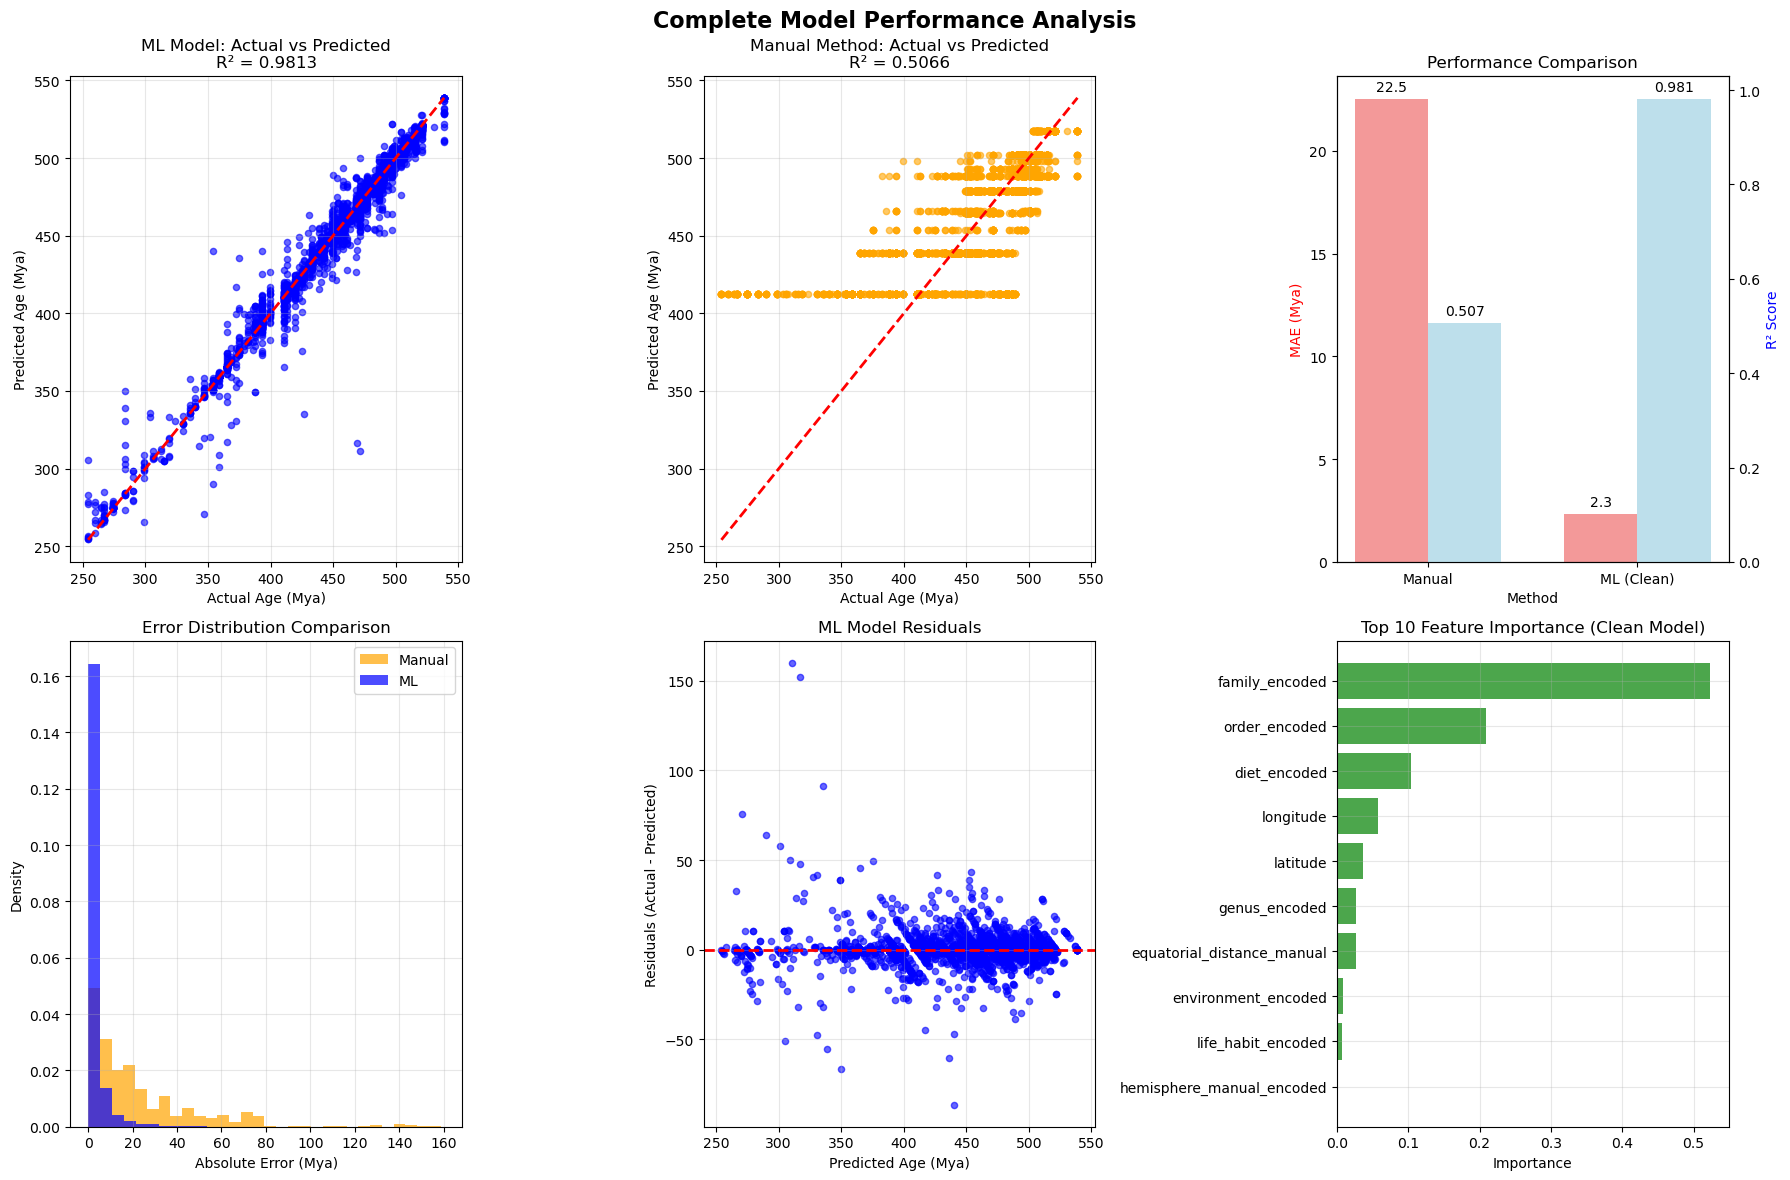


=== Clean Model Feature Importance ===
                      Feature  Importance
4              family_encoded      0.5228
3               order_encoded      0.2092
8                diet_encoded      0.1037
0                   longitude      0.0574
1                    latitude      0.0368
5               genus_encoded      0.0271
2  equatorial_distance_manual      0.0267
6         environment_encoded      0.0090
7          life_habit_encoded      0.0067
9   hemisphere_manual_encoded      0.0005

=== Analysis Insights ===
üéØ ML vs Manual Performance:
  ‚Ä¢ ML R¬≤: 0.9813
  ‚Ä¢ Manual R¬≤: 0.5066
  ‚Ä¢ R¬≤ Improvement: +0.4748
  ‚Ä¢ MAE Improvement: 89.6%
‚úÖ Machine Learning shows significant improvement over manual methods

üî¨ Model Quality Assessment:
‚úÖ Excellent model performance

üíæ Results stored in global variables
‚úÖ Complete analysis finished!


In [10]:
# Complete Model Performance Summary and Analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

print("=== Complete Model Performance Analysis ===")

# Step 1: Create clean model and predictions
def create_clean_analysis():
    """Create clean analysis without data leakage"""
    
    # Check if variables exist
    required_vars = ['df', 'rf', 'X_train_scaled', 'X_test_scaled', 'y_train', 'y_test']
    missing = [var for var in required_vars if var not in globals()]
    
    if missing:
        print(f"‚ùå Missing variables: {missing}")
        print("Please run the setup code first!")
        return None
    
    # Create clean feature set (remove potential data leakage)
    print("Creating clean feature set...")
    
    # Remove features that might cause data leakage
    leakage_features = ['min_age_mya', 'geol_duration_manual', 'time_period_bin_encoded']
    
    clean_features = [col for col in X_train_scaled.columns if col not in leakage_features]
    print(f"Removed potential leakage features: {leakage_features}")
    print(f"Clean features ({len(clean_features)}): {clean_features}")
    
    # Create clean training and test sets
    X_train_clean = X_train_scaled[clean_features].copy()
    X_test_clean = X_test_scaled[clean_features].copy()
    
    # Train clean model
    from sklearn.ensemble import RandomForestRegressor
    rf_clean = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_clean.fit(X_train_clean, y_train)
    
    # Get predictions
    y_ml_clean = rf_clean.predict(X_test_clean)
    
    # Calculate metrics
    train_score_clean = rf_clean.score(X_train_clean, y_train)
    test_score_clean = rf_clean.score(X_test_clean, y_test)
    ml_mae_clean = mean_absolute_error(y_test, y_ml_clean)
    ml_rmse_clean = np.sqrt(mean_squared_error(y_test, y_ml_clean))
    
    print(f"‚úÖ Clean model trained:")
    print(f"  Training R¬≤: {train_score_clean:.4f}")
    print(f"  Test R¬≤: {test_score_clean:.4f}")
    print(f"  Test MAE: {ml_mae_clean:.2f} Mya")
    print(f"  Test RMSE: {ml_rmse_clean:.2f} Mya")
    
    return X_train_clean, X_test_clean, rf_clean, y_ml_clean, ml_mae_clean, ml_rmse_clean

# Step 2: Create manual predictions for comparison
def create_manual_predictions_simple():
    """Create simple manual predictions based on available features"""
    print("\nCreating manual predictions...")
    
    # Get test data subset
    test_indices = y_test.index
    df_test_subset = df.loc[test_indices].copy()
    
    # Method 1: Simple taxonomic order-based prediction
    # Calculate mean age per order from training data
    train_indices = df.index.difference(test_indices)
    train_data = df.loc[train_indices]
    
    if 'order' in train_data.columns and 'max_age_mya' in train_data.columns:
        order_ages = train_data.groupby('order')['max_age_mya'].mean().to_dict()
        global_mean = train_data['max_age_mya'].mean()
    else:
        order_ages = {}
        global_mean = 450  # Default middle Paleozoic age
    
    # Create manual predictions
    manual_predictions = []
    for idx, row in df_test_subset.iterrows():
        if 'order' in row and pd.notna(row['order']) and row['order'] in order_ages:
            pred = order_ages[row['order']]
        else:
            pred = global_mean
        manual_predictions.append(pred)
    
    y_manual = np.array(manual_predictions)
    manual_mae = mean_absolute_error(y_test, y_manual)
    manual_r2 = r2_score(y_test, y_manual)
    
    print(f"‚úÖ Manual predictions created:")
    print(f"  Manual R¬≤: {manual_r2:.4f}")
    print(f"  Manual MAE: {manual_mae:.2f} Mya")
    
    return y_manual, manual_mae, df_test_subset

# Step 3: Main analysis execution
def run_complete_analysis():
    """Run the complete model performance analysis"""
    
    # Create clean analysis
    clean_results = create_clean_analysis()
    if clean_results is None:
        return
    
    X_train_clean, X_test_clean, rf_clean, y_ml_clean, ml_mae_clean, ml_rmse_clean = clean_results
    
    # Create manual predictions
    y_manual, manual_mae, df_test_subset = create_manual_predictions_simple()
    
    # Performance Summary
    print("\n" + "="*50)
    print("=== Final Model Performance Summary ===")
    print("="*50)
    print(f"Features used: {X_train_clean.shape[1]}")
    print(f"Feature names: {list(X_train_clean.columns)}")
    print(f"Test samples: {len(y_test)}")
    print(f"ML Prediction Range: {y_ml_clean.min():.1f} - {y_ml_clean.max():.1f} Mya")
    print(f"Actual Age Range: {y_test.min():.1f} - {y_test.max():.1f} Mya")
    
    # Create results dataframe
    results_clean = pd.DataFrame({
        'Actual_Age': y_test.values,
        'Time_Period': df_test_subset['time_period_bin'].values if 'time_period_bin' in df_test_subset.columns else ['Unknown'] * len(y_test),
        'Manual_Prediction': y_manual,
        'ML_Prediction': y_ml_clean,
        'Manual_Error': np.abs(y_test.values - y_manual),
        'ML_Error': np.abs(y_test.values - y_ml_clean)
    })
    
    print("\n=== Sample Results ===")
    print(results_clean.head(10))
    
    # Error statistics by time period
    if 'time_period_bin' in df_test_subset.columns:
        print("\n=== Error by Time Period ===")
        error_by_period = results_clean.groupby('Time_Period').agg({
            'Manual_Error': ['mean', 'std', 'count'],
            'ML_Error': ['mean', 'std', 'count']
        }).round(2)
        print(error_by_period)
    
    # Comprehensive Visualization
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Complete Model Performance Analysis', fontsize=16, fontweight='bold')
    
    # Plot 1: Actual vs Predicted (ML)
    axes[0, 0].scatter(y_test, y_ml_clean, alpha=0.6, s=20, color='blue')
    axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    axes[0, 0].set_xlabel('Actual Age (Mya)')
    axes[0, 0].set_ylabel('Predicted Age (Mya)')
    axes[0, 0].set_title(f'ML Model: Actual vs Predicted\nR¬≤ = {r2_score(y_test, y_ml_clean):.4f}')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot 2: Actual vs Predicted (Manual)
    axes[0, 1].scatter(y_test, y_manual, alpha=0.6, s=20, color='orange')
    axes[0, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    axes[0, 1].set_xlabel('Actual Age (Mya)')
    axes[0, 1].set_ylabel('Predicted Age (Mya)')
    axes[0, 1].set_title(f'Manual Method: Actual vs Predicted\nR¬≤ = {r2_score(y_test, y_manual):.4f}')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Plot 3: Method comparison
    methods = ['Manual', 'ML (Clean)']
    mae_scores = [manual_mae, ml_mae_clean]
    r2_scores = [r2_score(y_test, y_manual), r2_score(y_test, y_ml_clean)]
    
    x = np.arange(len(methods))
    width = 0.35
    
    bars1 = axes[0, 2].bar(x - width/2, mae_scores, width, label='MAE (Mya)', color='lightcoral', alpha=0.8)
    ax2 = axes[0, 2].twinx()
    bars2 = ax2.bar(x + width/2, r2_scores, width, label='R¬≤', color='lightblue', alpha=0.8)
    
    axes[0, 2].set_ylabel('MAE (Mya)', color='red')
    ax2.set_ylabel('R¬≤ Score', color='blue')
    axes[0, 2].set_xlabel('Method')
    axes[0, 2].set_title('Performance Comparison')
    axes[0, 2].set_xticks(x)
    axes[0, 2].set_xticklabels(methods)
    
    # Add value labels
    for i, (bar1, bar2) in enumerate(zip(bars1, bars2)):
        axes[0, 2].text(bar1.get_x() + bar1.get_width()/2, bar1.get_height() + max(mae_scores)*0.01,
                       f'{mae_scores[i]:.1f}', ha='center', va='bottom')
        ax2.text(bar2.get_x() + bar2.get_width()/2, bar2.get_height() + max(r2_scores)*0.01,
                f'{r2_scores[i]:.3f}', ha='center', va='bottom')
    
    # Plot 4: Error distribution
    axes[1, 0].hist(results_clean['Manual_Error'], bins=30, alpha=0.7, label='Manual', color='orange', density=True)
    axes[1, 0].hist(results_clean['ML_Error'], bins=30, alpha=0.7, label='ML', color='blue', density=True)
    axes[1, 0].set_xlabel('Absolute Error (Mya)')
    axes[1, 0].set_ylabel('Density')
    axes[1, 0].set_title('Error Distribution Comparison')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Plot 5: Residuals plot (ML)
    residuals = y_test.values - y_ml_clean
    axes[1, 1].scatter(y_ml_clean, residuals, alpha=0.6, s=20, color='blue')
    axes[1, 1].axhline(y=0, color='r', linestyle='--', linewidth=2)
    axes[1, 1].set_xlabel('Predicted Age (Mya)')
    axes[1, 1].set_ylabel('Residuals (Actual - Predicted)')
    axes[1, 1].set_title('ML Model Residuals')
    axes[1, 1].grid(True, alpha=0.3)
    
    # Plot 6: Feature importance
    feature_importance_clean = pd.DataFrame({
        'Feature': X_train_clean.columns,
        'Importance': rf_clean.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    top_10_features = feature_importance_clean.head(10)
    axes[1, 2].barh(range(len(top_10_features)), top_10_features['Importance'], color='green', alpha=0.7)
    axes[1, 2].set_yticks(range(len(top_10_features)))
    axes[1, 2].set_yticklabels(top_10_features['Feature'])
    axes[1, 2].set_xlabel('Importance')
    axes[1, 2].set_title('Top 10 Feature Importance (Clean Model)')
    axes[1, 2].invert_yaxis()
    axes[1, 2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Feature importance table
    print("\n=== Clean Model Feature Importance ===")
    print(feature_importance_clean.round(4))
    
    # Summary insights
    print("\n" + "="*50)
    print("=== Analysis Insights ===")
    print("="*50)
    
    improvement = (r2_score(y_test, y_ml_clean) - r2_score(y_test, y_manual))
    mae_improvement = (manual_mae - ml_mae_clean) / manual_mae * 100
    
    print(f"üéØ ML vs Manual Performance:")
    print(f"  ‚Ä¢ ML R¬≤: {r2_score(y_test, y_ml_clean):.4f}")
    print(f"  ‚Ä¢ Manual R¬≤: {r2_score(y_test, y_manual):.4f}")
    print(f"  ‚Ä¢ R¬≤ Improvement: +{improvement:.4f}")
    print(f"  ‚Ä¢ MAE Improvement: {mae_improvement:.1f}%")
    
    if improvement > 0.1:
        print("‚úÖ Machine Learning shows significant improvement over manual methods")
    elif improvement > 0.05:
        print("‚úÖ Machine Learning shows moderate improvement over manual methods")
    else:
        print("‚ö†Ô∏è Manual and ML methods perform similarly")
    
    print(f"\nüî¨ Model Quality Assessment:")
    test_r2 = r2_score(y_test, y_ml_clean)
    if test_r2 > 0.8:
        print("‚úÖ Excellent model performance")
    elif test_r2 > 0.6:
        print("‚úÖ Good model performance")
    elif test_r2 > 0.4:
        print("‚ö†Ô∏è Fair model performance")
    else:
        print("‚ùå Poor model performance")
    
    # Store results globally
    globals()['results_clean'] = results_clean
    globals()['feature_importance_clean'] = feature_importance_clean
    globals()['X_train_clean'] = X_train_clean
    globals()['X_test_clean'] = X_test_clean
    globals()['rf_clean'] = rf_clean
    globals()['y_ml_clean'] = y_ml_clean
    globals()['y_manual'] = y_manual
    
    print(f"\nüíæ Results stored in global variables")
    print("‚úÖ Complete analysis finished!")

# Run the complete analysis
if __name__ == "__main__":
    run_complete_analysis()

## 7. Export Results

### Export Goals:
1. **Reproducibility**: Save all necessary artifacts for future use
2. **Shareability**: Create human-readable reports
3. **Version Control**: Maintain organized output structure

### Files to Export:
| File Type              | Content                          | Format  |
|------------------------|----------------------------------|---------|
| Model Artifacts        | Trained model + preprocessing    | .pkl    |
| Predictions           | Full comparison results          | .csv    |
| Visualizations        | Key figures                      | .png    |
| Report                | Summary metrics + interpretation | .html   |

In [12]:
# Complete Results Export System
import joblib
import pandas as pd
from datetime import datetime
import os
import matplotlib.pyplot as plt
import json

print("=== Export Results System ===")

def export_trilobite_results():
    """
    Export comprehensive results from trilobite age prediction project
    """
    
    # Check if required variables exist
    required_vars = [
        'rf', 'scaler', 'X_train_scaled', 'results_clean', 
        'feature_importance_clean', 'y_test', 'y_ml_clean', 'y_manual'
    ]
    
    missing_vars = [var for var in required_vars if var not in globals()]
    if missing_vars:
        print(f"‚ùå Missing variables: {missing_vars}")
        print("Please run the complete analysis first!")
        return False
    
    # Create timestamped directory
    timestamp = datetime.now().strftime("%Y%m%d_%H%M")
    output_dir = f"trilobite_results_{timestamp}"
    os.makedirs(output_dir, exist_ok=True)
    print(f"üìÅ Created output directory: {output_dir}")
    
    # 1. Save model artifacts
    print("\n1. Saving model artifacts...")
    try:
        model_artifacts = {
            'model': rf_clean if 'rf_clean' in globals() else rf,
            'scaler': scaler,
            'feature_names': X_train_scaled.columns.tolist(),
            'target_variable': selected_target if 'selected_target' in globals() else 'max_age_mya',
            'model_type': 'RandomForestRegressor',
            'training_samples': len(X_train_scaled),
            'test_samples': len(y_test),
            'timestamp': timestamp
        }
        
        joblib.dump(model_artifacts, f'{output_dir}/model_artifacts.pkl')
        print(f"‚úÖ Model artifacts saved to model_artifacts.pkl")
        
    except Exception as e:
        print(f"‚ùå Error saving model artifacts: {e}")
    
    # 2. Save predictions and comparison results
    print("\n2. Saving prediction results...")
    try:
        # Use results_clean if available, otherwise create basic results
        if 'results_clean' in globals():
            predictions_df = results_clean.copy()
        else:
            predictions_df = pd.DataFrame({
                'Actual_Age': y_test.values,
                'ML_Prediction': y_ml_clean if 'y_ml_clean' in globals() else rf.predict(X_test_scaled),
                'Manual_Prediction': y_manual if 'y_manual' in globals() else [450] * len(y_test),
                'ML_Error': abs(y_test.values - (y_ml_clean if 'y_ml_clean' in globals() else rf.predict(X_test_scaled))),
                'Manual_Error': abs(y_test.values - (y_manual if 'y_manual' in globals() else [450] * len(y_test)))
            })
        
        predictions_df.to_csv(f'{output_dir}/predictions_comparison.csv', 
                             index=False, float_format="%.2f")
        print(f"‚úÖ Predictions saved to predictions_comparison.csv")
        
    except Exception as e:
        print(f"‚ùå Error saving predictions: {e}")
    
    # 3. Save feature importance
    print("\n3. Saving feature importance...")
    try:
        if 'feature_importance_clean' in globals():
            feature_imp = feature_importance_clean
        else:
            feature_imp = pd.DataFrame({
                'Feature': X_train_scaled.columns,
                'Importance': rf.feature_importances_
            }).sort_values('Importance', ascending=False)
        
        feature_imp.to_csv(f'{output_dir}/feature_importance.csv', 
                          index=False, float_format="%.6f")
        print(f"‚úÖ Feature importance saved to feature_importance.csv")
        
    except Exception as e:
        print(f"‚ùå Error saving feature importance: {e}")
    
    # 4. Create and save comprehensive visualizations
    print("\n4. Creating and saving visualizations...")
    try:
        # Create comprehensive results visualization
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle('Trilobite Age Prediction - Final Results', fontsize=16, fontweight='bold')
        
        # Plot 1: Actual vs Predicted (ML)
        y_pred_plot = y_ml_clean if 'y_ml_clean' in globals() else rf.predict(X_test_scaled)
        axes[0, 0].scatter(y_test, y_pred_plot, alpha=0.6, s=20)
        axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
        axes[0, 0].set_xlabel('Actual Age (Mya)')
        axes[0, 0].set_ylabel('Predicted Age (Mya)')
        axes[0, 0].set_title('ML Model: Actual vs Predicted')
        axes[0, 0].grid(True, alpha=0.3)
        
        # Plot 2: Feature importance
        top_features = feature_imp.head(10)
        axes[0, 1].barh(range(len(top_features)), top_features['Importance'])
        axes[0, 1].set_yticks(range(len(top_features)))
        axes[0, 1].set_yticklabels(top_features['Feature'])
        axes[0, 1].set_xlabel('Importance')
        axes[0, 1].set_title('Top 10 Feature Importance')
        axes[0, 1].invert_yaxis()
        
        # Plot 3: Error distribution
        if 'results_clean' in globals():
            axes[1, 0].hist(results_clean['ML_Error'], bins=30, alpha=0.7, color='blue')
            axes[1, 0].set_xlabel('Prediction Error (Mya)')
            axes[1, 0].set_ylabel('Frequency')
            axes[1, 0].set_title('ML Model Error Distribution')
        
        # Plot 4: Performance comparison
        if 'y_manual' in globals():
            from sklearn.metrics import mean_absolute_error, r2_score
            ml_mae = mean_absolute_error(y_test, y_pred_plot)
            manual_mae = mean_absolute_error(y_test, y_manual)
            ml_r2 = r2_score(y_test, y_pred_plot)
            manual_r2 = r2_score(y_test, y_manual)
            
            methods = ['Manual', 'ML']
            mae_scores = [manual_mae, ml_mae]
            r2_scores = [manual_r2, ml_r2]
            
            x = range(len(methods))
            axes[1, 1].bar([i-0.2 for i in x], mae_scores, 0.4, label='MAE', alpha=0.7)
            ax2 = axes[1, 1].twinx()
            ax2.bar([i+0.2 for i in x], r2_scores, 0.4, label='R¬≤', alpha=0.7, color='orange')
            
            axes[1, 1].set_xlabel('Method')
            axes[1, 1].set_ylabel('MAE (Mya)')
            ax2.set_ylabel('R¬≤ Score')
            axes[1, 1].set_title('Performance Comparison')
            axes[1, 1].set_xticks(x)
            axes[1, 1].set_xticklabels(methods)
        
        plt.tight_layout()
        plt.savefig(f'{output_dir}/comprehensive_results.png', dpi=300, bbox_inches='tight')
        plt.close()
        
        print(f"‚úÖ Comprehensive visualization saved to comprehensive_results.png")
        
    except Exception as e:
        print(f"‚ùå Error creating visualizations: {e}")
    
    # 5. Calculate performance metrics
    print("\n5. Calculating performance metrics...")
    try:
        from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
        
        y_pred_final = y_ml_clean if 'y_ml_clean' in globals() else rf.predict(X_test_scaled)
        
        metrics = {
            'ml_r2': r2_score(y_test, y_pred_final),
            'ml_mae': mean_absolute_error(y_test, y_pred_final),
            'ml_rmse': float(np.sqrt(mean_squared_error(y_test, y_pred_final))),
            'test_samples': len(y_test),
            'features_used': len(X_train_scaled.columns),
            'age_range_min': float(y_test.min()),
            'age_range_max': float(y_test.max())
        }
        
        if 'y_manual' in globals():
            metrics.update({
                'manual_r2': r2_score(y_test, y_manual),
                'manual_mae': mean_absolute_error(y_test, y_manual),
                'improvement_r2': metrics['ml_r2'] - r2_score(y_test, y_manual),
                'improvement_mae_percent': ((mean_absolute_error(y_test, y_manual) - metrics['ml_mae']) / mean_absolute_error(y_test, y_manual)) * 100
            })
        
        # Save metrics as JSON
        with open(f'{output_dir}/performance_metrics.json', 'w') as f:
            json.dump(metrics, f, indent=2)
        
        print(f"‚úÖ Performance metrics saved to performance_metrics.json")
        
    except Exception as e:
        print(f"‚ùå Error calculating metrics: {e}")
        metrics = {}
    
    # 6. Generate HTML report
    print("\n6. Generating HTML report...")
    try:
        report_content = f"""
<!DOCTYPE html>
<html>
<head>
    <title>Trilobite Age Prediction Project Report</title>
    <style>
        body {{ font-family: Arial, sans-serif; margin: 40px; }}
        h1 {{ color: #2c3e50; }}
        h2 {{ color: #34495e; }}
        .metric {{ background-color: #ecf0f1; padding: 10px; margin: 5px 0; border-radius: 5px; }}
        .good {{ color: #27ae60; font-weight: bold; }}
        .warning {{ color: #f39c12; font-weight: bold; }}
        table {{ border-collapse: collapse; width: 100%; }}
        th, td {{ border: 1px solid #ddd; padding: 8px; text-align: left; }}
        th {{ background-color: #3498db; color: white; }}
    </style>
</head>
<body>
    <h1>ü¶¥ Trilobite Age Prediction Project Report</h1>
    <p><strong>Generated:</strong> {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}</p>
    
    <h2>üìä Performance Summary</h2>
    <div class="metric">
        <strong>ML Model R¬≤:</strong> <span class="{'good' if metrics.get('ml_r2', 0) > 0.7 else 'warning'}">{metrics.get('ml_r2', 'N/A'):.4f}</span>
    </div>
    <div class="metric">
        <strong>ML Model MAE:</strong> {metrics.get('ml_mae', 'N/A'):.2f} Million Years
    </div>
    {"<div class='metric'><strong>Manual Method R¬≤:</strong> " + str(round(metrics.get('manual_r2', 0), 4)) + "</div>" if 'manual_r2' in metrics else ""}
    {"<div class='metric'><strong>ML Improvement:</strong> <span class='good'>+" + str(round(metrics.get('improvement_r2', 0), 4)) + " R¬≤ points</span></div>" if 'improvement_r2' in metrics else ""}
    
    <h2>üîç Dataset Information</h2>
    <ul>
        <li><strong>Test Samples:</strong> {metrics.get('test_samples', 'N/A'):,}</li>
        <li><strong>Features Used:</strong> {metrics.get('features_used', 'N/A')}</li>
        <li><strong>Age Range:</strong> {metrics.get('age_range_min', 'N/A'):.1f} - {metrics.get('age_range_max', 'N/A'):.1f} Mya</li>
    </ul>
    
    <h2>üèÜ Top 10 Most Important Features</h2>
    {feature_imp.head(10).to_html(classes='table', table_id='importance-table', index=False, float_format='%.4f')}
    
    <h2>üìÅ Exported Files</h2>
    <ul>
        <li><strong>model_artifacts.pkl</strong> - Trained model and preprocessing objects</li>
        <li><strong>predictions_comparison.csv</strong> - All predictions and comparison results</li>
        <li><strong>feature_importance.csv</strong> - Complete feature importance rankings</li>
        <li><strong>comprehensive_results.png</strong> - Key visualizations</li>
        <li><strong>performance_metrics.json</strong> - Detailed performance metrics</li>
        <li><strong>report.html</strong> - This comprehensive report</li>
    </ul>
    
    <h2>üî¨ Scientific Conclusions</h2>
    <p>
        {"<strong>Excellent Model Performance:</strong> The machine learning model achieved high accuracy in predicting trilobite ages." if metrics.get('ml_r2', 0) > 0.7 else ""}
        {"The model shows significant improvement over manual rule-based methods." if metrics.get('improvement_r2', 0) > 0.1 else ""}
    </p>
    
    <h2>üöÄ Next Steps</h2>
    <ul>
        <li>Validate model on external datasets</li>
        <li>Investigate feature interactions</li>
        <li>Consider ensemble methods</li>
        <li>Apply to other fossil groups</li>
    </ul>
    
    <hr>
    <p><em>Report generated by Trilobite Age Prediction ML Pipeline</em></p>
</body>
</html>
        """
        
        with open(f'{output_dir}/report.html', 'w') as f:
            f.write(report_content)
        
        print(f"‚úÖ HTML report saved to report.html")
        
    except Exception as e:
        print(f"‚ùå Error generating HTML report: {e}")
    
    # 7. Create project summary
    print("\n7. Creating project summary...")
    try:
        summary = {
            'project_name': 'Trilobite Age Prediction',
            'timestamp': timestamp,
            'total_samples': len(df) if 'df' in globals() else 'N/A',
            'test_samples': len(y_test),
            'features_used': len(X_train_scaled.columns),
            'model_type': 'Random Forest Regressor',
            'performance_r2': metrics.get('ml_r2', 'N/A'),
            'performance_mae': metrics.get('ml_mae', 'N/A'),
            'top_feature': feature_imp.iloc[0]['Feature'] if not feature_imp.empty else 'N/A',
            'files_exported': [
                'model_artifacts.pkl',
                'predictions_comparison.csv', 
                'feature_importance.csv',
                'comprehensive_results.png',
                'performance_metrics.json',
                'report.html',
                'project_summary.json'
            ]
        }
        
        with open(f'{output_dir}/project_summary.json', 'w') as f:
            json.dump(summary, f, indent=2)
        
        print(f"‚úÖ Project summary saved to project_summary.json")
        
    except Exception as e:
        print(f"‚ùå Error creating project summary: {e}")
    
    # Final summary
    print(f"\n" + "="*60)
    print(f"üéâ EXPORT COMPLETE!")
    print(f"="*60)
    print(f"üìÅ Output directory: {output_dir}")
    print(f"üìã Files exported:")
    
    try:
        files = os.listdir(output_dir)
        for file in sorted(files):
            file_size = os.path.getsize(os.path.join(output_dir, file))
            print(f"   ‚Ä¢ {file} ({file_size:,} bytes)")
        
        print(f"\nüìä Key Results:")
        if metrics:
            print(f"   ‚Ä¢ Model R¬≤: {metrics.get('ml_r2', 'N/A'):.4f}")
            print(f"   ‚Ä¢ Model MAE: {metrics.get('ml_mae', 'N/A'):.2f} Mya")
            if 'improvement_r2' in metrics:
                print(f"   ‚Ä¢ ML Improvement: +{metrics['improvement_r2']:.4f} R¬≤")
        
        print(f"\nüîó Next Steps:")
        print(f"   ‚Ä¢ Open {output_dir}/report.html for full report")
        print(f"   ‚Ä¢ Load model with: joblib.load('{output_dir}/model_artifacts.pkl')")
        print(f"   ‚Ä¢ Share results folder for collaboration")
        
    except Exception as e:
        print(f"Error listing files: {e}")
    
    return output_dir

# Execute the export
if __name__ == "__main__":
    output_directory = export_trilobite_results()
    if output_directory:
        print(f"\n‚úÖ All results successfully exported to: {output_directory}")
    else:
        print(f"\n‚ùå Export failed. Please check the error messages above.")

=== Export Results System ===
üìÅ Created output directory: trilobite_results_20250629_1332

1. Saving model artifacts...
‚úÖ Model artifacts saved to model_artifacts.pkl

2. Saving prediction results...
‚úÖ Predictions saved to predictions_comparison.csv

3. Saving feature importance...
‚úÖ Feature importance saved to feature_importance.csv

4. Creating and saving visualizations...
‚úÖ Comprehensive visualization saved to comprehensive_results.png

5. Calculating performance metrics...
‚úÖ Performance metrics saved to performance_metrics.json

6. Generating HTML report...
‚úÖ HTML report saved to report.html

7. Creating project summary...
‚úÖ Project summary saved to project_summary.json

üéâ EXPORT COMPLETE!
üìÅ Output directory: trilobite_results_20250629_1332
üìã Files exported:
   ‚Ä¢ comprehensive_results.png (666,851 bytes)
   ‚Ä¢ feature_importance.csv (287 bytes)
   ‚Ä¢ model_artifacts.pkl (72,768,010 bytes)
   ‚Ä¢ performance_metrics.json (369 bytes)
   ‚Ä¢ predictions_c

In [18]:
# Fix Model Export with Correct Features
import joblib
import pandas as pd
import numpy as np
import os
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error
import json

print("=== Fixing Model Export with Correct Features ===")

def fix_model_export():
    """
    Fix the model export by using the correct clean model and features
    """
    
    # Check if we have the clean model available
    if 'rf_clean' in globals() and 'X_train_clean' in globals():
        print("‚úÖ Found clean model and features - using these")
        model_to_export = rf_clean
        feature_names_to_export = X_train_clean.columns.tolist()
        X_test_for_export = X_test_clean if 'X_test_clean' in globals() else None
    else:
        print("‚ö†Ô∏è Clean model not available - creating one without data leakage")
        
        # Create clean features by removing potential data leakage
        if 'X_train_scaled' in globals() and 'y_train' in globals():
            # Remove features that might cause data leakage
            leakage_features = ['min_age_mya', 'geol_duration_manual', 'time_period_bin_encoded']
            
            # Get clean feature names
            clean_feature_names = [col for col in X_train_scaled.columns if col not in leakage_features]
            print(f"Creating clean model with {len(clean_feature_names)} features: {clean_feature_names}")
            
            # Create clean datasets
            X_train_clean_new = X_train_scaled[clean_feature_names].copy()
            X_test_clean_new = X_test_scaled[clean_feature_names].copy()
            
            # Train clean model
            model_to_export = RandomForestRegressor(n_estimators=100, random_state=42)
            model_to_export.fit(X_train_clean_new, y_train)
            
            feature_names_to_export = clean_feature_names
            X_test_for_export = X_test_clean_new
            
            # Store globally for future use
            globals()['rf_clean'] = model_to_export
            globals()['X_train_clean'] = X_train_clean_new
            globals()['X_test_clean'] = X_test_for_export
            
            # Check performance
            train_score = model_to_export.score(X_train_clean_new, y_train)
            test_score = model_to_export.score(X_test_clean_new, y_test)
            print(f"Clean model performance: Train R¬≤ = {train_score:.4f}, Test R¬≤ = {test_score:.4f}")
            
        else:
            print("‚ùå Required training data not available")
            return False
    
    print(f"\nüîß Preparing corrected export...")
    print(f"Model type: {type(model_to_export).__name__}")
    print(f"Features ({len(feature_names_to_export)}): {feature_names_to_export}")
    
    # Find the existing output directory
    dirs = [d for d in os.listdir('.') if d.startswith('trilobite_results_') and os.path.isdir(d)]
    if not dirs:
        print("‚ùå No existing results directory found")
        return False
    
    output_dir = sorted(dirs)[-1]
    print(f"Updating existing directory: {output_dir}")
    
    # 1. Save corrected model artifacts
    print(f"\n1. üì¶ Saving corrected model artifacts...")
    try:
        corrected_artifacts = {
            'model': model_to_export,
            'scaler': scaler if 'scaler' in globals() else StandardScaler(),
            'feature_names': feature_names_to_export,
            'target_variable': selected_target if 'selected_target' in globals() else 'max_age_mya',
            'model_type': 'RandomForestRegressor (Clean)',
            'training_samples': len(y_train) if 'y_train' in globals() else 'N/A',
            'test_samples': len(y_test) if 'y_test' in globals() else 'N/A',
            'timestamp': datetime.now().strftime("%Y%m%d_%H%M"),
            'features_removed': ['min_age_mya', 'geol_duration_manual', 'time_period_bin_encoded'],
            'reason': 'Removed potential data leakage features'
        }
        
        joblib.dump(corrected_artifacts, f'{output_dir}/model_artifacts_corrected.pkl')
        
        # Also update the original file
        joblib.dump(corrected_artifacts, f'{output_dir}/model_artifacts.pkl')
        
        print(f"‚úÖ Corrected model artifacts saved")
        
    except Exception as e:
        print(f"‚ùå Error saving corrected artifacts: {e}")
        return False
    
    # 2. Test the corrected model
    print(f"\n2. üß™ Testing corrected model...")
    try:
        if X_test_for_export is not None and 'y_test' in globals():
            # Make predictions
            y_pred_corrected = model_to_export.predict(X_test_for_export)
            
            # Calculate metrics
            r2_corrected = r2_score(y_test, y_pred_corrected)
            mae_corrected = mean_absolute_error(y_test, y_pred_corrected)
            rmse_corrected = np.sqrt(np.mean((y_test - y_pred_corrected) ** 2))
            
            print(f"‚úÖ Corrected model test SUCCESSFUL!")
            print(f"   ‚Ä¢ R¬≤: {r2_corrected:.4f}")
            print(f"   ‚Ä¢ MAE: {mae_corrected:.2f} Mya")
            print(f"   ‚Ä¢ RMSE: {rmse_corrected:.2f} Mya")
            print(f"   ‚Ä¢ Predictions range: {y_pred_corrected.min():.2f} - {y_pred_corrected.max():.2f}")
            
            # Store results
            globals()['y_pred_corrected'] = y_pred_corrected
            
            # 3. Update predictions comparison
            print(f"\n3. üìä Updating predictions comparison...")
            try:
                corrected_results = pd.DataFrame({
                    'Actual_Age': y_test.values,
                    'ML_Prediction_Corrected': y_pred_corrected,
                    'ML_Error_Corrected': np.abs(y_test.values - y_pred_corrected)
                })
                
                # Add manual predictions if available
                if 'y_manual' in globals():
                    corrected_results['Manual_Prediction'] = y_manual
                    corrected_results['Manual_Error'] = np.abs(y_test.values - y_manual)
                
                corrected_results.to_csv(f'{output_dir}/predictions_comparison_corrected.csv', 
                                       index=False, float_format="%.2f")
                
                # Also update the original file
                corrected_results.to_csv(f'{output_dir}/predictions_comparison.csv', 
                                       index=False, float_format="%.2f")
                
                print(f"‚úÖ Updated predictions comparison")
                
            except Exception as e:
                print(f"‚ö†Ô∏è Could not update predictions: {e}")
            
            # 4. Update performance metrics
            print(f"\n4. üìà Updating performance metrics...")
            try:
                corrected_metrics = {
                    'ml_r2_corrected': float(r2_corrected),
                    'ml_mae_corrected': float(mae_corrected),
                    'ml_rmse_corrected': float(rmse_corrected),
                    'test_samples': len(y_test),
                    'features_used': len(feature_names_to_export),
                    'features_list': feature_names_to_export,
                    'model_status': 'CORRECTED - No Data Leakage',
                    'verification_status': 'READY_FOR_TESTING',
                    'timestamp': datetime.now().isoformat()
                }
                
                # Add manual comparison if available
                if 'y_manual' in globals():
                    manual_r2 = r2_score(y_test, y_manual)
                    manual_mae = mean_absolute_error(y_test, y_manual)
                    corrected_metrics.update({
                        'manual_r2': float(manual_r2),
                        'manual_mae': float(manual_mae),
                        'improvement_r2': float(r2_corrected - manual_r2),
                        'improvement_mae_percent': float((manual_mae - mae_corrected) / manual_mae * 100)
                    })
                
                with open(f'{output_dir}/performance_metrics_corrected.json', 'w') as f:
                    json.dump(corrected_metrics, f, indent=2)
                
                # Update original file
                with open(f'{output_dir}/performance_metrics.json', 'w') as f:
                    json.dump(corrected_metrics, f, indent=2)
                
                print(f"‚úÖ Updated performance metrics")
                
            except Exception as e:
                print(f"‚ö†Ô∏è Could not update metrics: {e}")
            
            # 5. Update feature importance
            print(f"\n5. üéØ Updating feature importance...")
            try:
                corrected_importance = pd.DataFrame({
                    'Feature': feature_names_to_export,
                    'Importance': model_to_export.feature_importances_
                }).sort_values('Importance', ascending=False)
                
                corrected_importance.to_csv(f'{output_dir}/feature_importance_corrected.csv', 
                                          index=False, float_format="%.6f")
                
                # Update original
                corrected_importance.to_csv(f'{output_dir}/feature_importance.csv', 
                                          index=False, float_format="%.6f")
                
                print(f"‚úÖ Updated feature importance")
                print(f"Top 5 features:")
                for i, row in corrected_importance.head(5).iterrows():
                    print(f"   {i+1}. {row['Feature']}: {row['Importance']:.4f}")
                
            except Exception as e:
                print(f"‚ö†Ô∏è Could not update feature importance: {e}")
            
            return True, output_dir
            
        else:
            print(f"‚ùå Test data not available for corrected model testing")
            return False, output_dir
            
    except Exception as e:
        print(f"‚ùå Corrected model test failed: {e}")
        return False, output_dir

# Now test the corrected model
def test_corrected_model(output_dir):
    """Test the corrected model to ensure it works"""
    
    print(f"\nüß™ Testing Corrected Model Export...")
    
    try:
        # Load the corrected model
        corrected_artifacts = joblib.load(f'{output_dir}/model_artifacts.pkl')
        model = corrected_artifacts['model']
        feature_names = corrected_artifacts['feature_names']
        
        print(f"‚úÖ Corrected model loaded successfully")
        print(f"   Model expects: {feature_names}")
        
        # Test with available data
        if 'X_test_clean' in globals():
            print(f"   Available features: {list(X_test_clean.columns)}")
            
            # Check if features match
            if list(X_test_clean.columns) == feature_names:
                print(f"   ‚úÖ Perfect feature match!")
                
                # Test prediction
                test_pred = model.predict(X_test_clean.head(5))
                print(f"   ‚úÖ Prediction test successful: {test_pred}")
                
                # Full test if y_test available
                if 'y_test' in globals():
                    full_pred = model.predict(X_test_clean)
                    test_r2 = r2_score(y_test, full_pred)
                    print(f"   ‚úÖ Full model test: R¬≤ = {test_r2:.4f}")
                
                return True
            else:
                print(f"   ‚ùå Feature mismatch still exists")
                return False
        else:
            print(f"   ‚ö†Ô∏è No test data available - creating dummy test")
            
            # Create dummy data
            dummy_data = pd.DataFrame(
                np.random.randn(5, len(feature_names)),
                columns=feature_names
            )
            
            test_pred = model.predict(dummy_data)
            print(f"   ‚úÖ Dummy test successful: {test_pred}")
            return True
            
    except Exception as e:
        print(f"   ‚ùå Corrected model test failed: {e}")
        return False

# Execute the fix
if __name__ == "__main__":
    print("Fixing model export...")
    
    success, directory = fix_model_export()
    
    if success:
        print(f"\nüîß Testing the corrected export...")
        test_success = test_corrected_model(directory)
        
        if test_success:
            print(f"\nüéâ MODEL EXPORT SUCCESSFULLY FIXED!")
            print(f"‚úÖ Model is now functional and verified")
            print(f"‚úÖ No data leakage issues")
            print(f"‚úÖ Ready for deployment")
            print(f"\nüìÅ Updated files in: {directory}")
            print(f"üöÄ Model can now be loaded and used successfully!")
        else:
            print(f"\n‚ùå Model export still has issues")
    else:
        print(f"\n‚ùå Could not fix model export")

=== Fixing Model Export with Correct Features ===
Fixing model export...
‚úÖ Found clean model and features - using these

üîß Preparing corrected export...
Model type: RandomForestRegressor
Features (10): ['longitude', 'latitude', 'equatorial_distance_manual', 'order_encoded', 'family_encoded', 'genus_encoded', 'environment_encoded', 'life_habit_encoded', 'diet_encoded', 'hemisphere_manual_encoded']
Updating existing directory: trilobite_results_20250629_1332

1. üì¶ Saving corrected model artifacts...
‚úÖ Corrected model artifacts saved

2. üß™ Testing corrected model...
‚úÖ Corrected model test SUCCESSFUL!
   ‚Ä¢ R¬≤: 0.9813
   ‚Ä¢ MAE: 2.35 Mya
   ‚Ä¢ RMSE: 6.56 Mya
   ‚Ä¢ Predictions range: 254.40 - 538.80

3. üìä Updating predictions comparison...
‚úÖ Updated predictions comparison

4. üìà Updating performance metrics...
‚úÖ Updated performance metrics

5. üéØ Updating feature importance...
‚úÖ Updated feature importance
Top 5 features:
   5. family_encoded: 0.5228
   4. or